<a href="https://colab.research.google.com/github/CheilaBaiao/Pantanal/blob/main/4)EWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title R3-1 — Setup (libs, Drive, paths, config)
%pip -q install numpy pandas geopandas shapely rasterio rioxarray xarray tqdm pyyaml joblib

import os, re, glob, json, time, yaml, math, warnings
from pathlib import Path
import numpy as np, pandas as pd
from tqdm.auto import tqdm
import geopandas as gpd

from joblib import Memory
memory = Memory(location="/content/.joblib_cache", verbose=0)

# Montar Drive
from google.colab import drive
try:
    drive.mount('/content/drive')
except Exception as e:
    print("Aviso ao montar Drive:", e)

# Pastas-base
BASE_DIR   = Path("/content/drive/MyDrive/Pantanal_TippingPoints/index")
OUT_DIR    = BASE_DIR / "outputs"
LOG_DIR    = OUT_DIR / "logs"
QC_DIR     = OUT_DIR / "qc"
CACHE_DIR  = OUT_DIR / "cache_nb3"              # cache de agregações 30m→300m, etc.
TMP_DIR    = OUT_DIR / "tmp_nb3"                # temporários
for d in (OUT_DIR, LOG_DIR, QC_DIR, CACHE_DIR, TMP_DIR): d.mkdir(parents=True, exist_ok=True)

# Config
CONFIG_FP = BASE_DIR / "config.yaml"
assert CONFIG_FP.exists(), f"config.yaml não encontrado em {CONFIG_FP}"
CONFIG = yaml.safe_load(open(CONFIG_FP))

CRS_EPSG      = int(CONFIG.get("crs_epsg", 31983))
BOUNDARY_PATH = CONFIG.get("boundary_path"); assert BOUNDARY_PATH and Path(BOUNDARY_PATH).exists()
OPT_FOLDER    = CONFIG.get("gee_drive_folder_optical", "Pantanal_TippingPoints_optical")

# Fontes de dados
MB30_DIR   = Path("/content/drive/MyDrive/Pantanal_TippingPoints_val_mb_bi_30m")  # (1) sua pasta MB 30m
OPT_ROOTS  = [Path("/content/drive/MyDrive"), Path("/content/drive/My Drive")]
OPT_DIRS   = [r / OPT_FOLDER for r in OPT_ROOTS]
MERGE_DIRS = [r / f"{OPT_FOLDER}_merged" for r in OPT_ROOTS]

# Onde salvar os agregados MB 300m (cache)
MB300_DIR  = OUT_DIR / "mb_bi_300m_cache"
MB300_DIR.mkdir(parents=True, exist_ok=True)

print("✔ Config carregada | EPSG:", CRS_EPSG)
print("✔ MB 30m:", MB30_DIR)
print("✔ MB 300m (cache):", MB300_DIR)




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.6 MB/s eta 0:00:00
Mounted at /content/drive
✔ Config carregada | EPSG: 31983
✔ MB 30m: /content/drive/MyDrive/Pantanal_TippingPoints_val_mb_bi_30m
✔ MB 300m (cache): /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/mb_bi_300m_cache


In [ ]:
# @title R3-2 — Climatologia sazonal pré-fogo (mean/std por bimestre) com checkpoint
import os, re, json, math, warnings
from pathlib import Path
import numpy as np
import rasterio as rio
from rasterio.windows import Window
from tqdm.auto import tqdm

# ==== Caminhos (mantém seus diretórios) ====
ROOT = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
OPT_DIR   = ROOT/'index/outputs/opt_singleband_300m_cache'         # NDVI/EVI/NBR
VOD_DIR   = ROOT/'index/outputs/vod_bi_300m_aligned_cache'         # VOD
FIRE_DATE = ROOT/'index/outputs/recovery_nb3/first_fire_yyyymm.tif' # 300m

OUT_BASE  = ROOT/'index/outputs/deseason'
OUT_BASE.mkdir(parents=True, exist_ok=True)

INDICES = ['NDVI','EVI','NBR','VOD']
IDX_DIR = {'NDVI': OPT_DIR, 'EVI': OPT_DIR, 'NBR': OPT_DIR, 'VOD': VOD_DIR}

BIMES = (1,3,5,7,9,11)
NODATA_OUT = -32768.0

# ==== Checkpoint ====
CKPT = OUT_BASE/'clim_ckpt.json'
state = {"done": {}}  # por índice, registra "mean_mXX" e "std_mXX" quando salvos
if CKPT.exists():
    try:
        state.update(json.loads(CKPT.read_text()))
    except Exception:
        pass

# ==== Utilidades ====
ym_re = re.compile(r'(19|20)\d{2}[01]\d')
def list_yyyymm(dirpath: Path, idx: str):
    idx_pat = re.compile(rf'(^|[_\-]){idx}([_\-]|$)', re.I)
    hits = {}
    for p in dirpath.rglob('*.tif'):
        if not idx_pat.search(p.name):
            continue
        m = ym_re.search(p.name)
        if not m:
            continue
        hits[m.group(0)] = p
    return dict(sorted(hits.items()))

def month_to_bi(mm: int):
    # espera mm em 1..12; aqui só usamos {1,3,5,7,9,11}
    return mm

def open_ref_any(paths_dict):
    # pega qualquer arquivo para referência de grid
    return next(iter(paths_dict.values()))

# ==== Carrega "primeiro fogo" completo na memória (float32) ====
assert FIRE_DATE.exists(), f"Arquivo de primeiro fogo não encontrado: {FIRE_DATE}"
with rio.open(FIRE_DATE) as ds_ff:
    ff = ds_ff.read(1).astype('float32')
    ff_nodata = ds_ff.nodata
    if ff_nodata is not None:
        ff = np.where(ff==ff_nodata, np.nan, ff)
    profile_ref = ds_ff.profile
H, W = ff.shape

# ==== Loop por índice: computa mean/std por bimestre (pré-fogo) ====
for idx in INDICES:
    base = IDX_DIR[idx]
    if not base.exists():
        print(f"⚠ {idx}: pasta não encontrada → {base}")
        continue

    catalog = list_yyyymm(base, idx)
    # Limitar ao intervalo 1987–2021
    YEAR_START, YEAR_END = 1987, 2021
    catalog = {
        ym: fp for ym, fp in catalog.items()
        if (int(ym[:4]) >= YEAR_START and int(ym[:4]) <= YEAR_END)
    }
    if not catalog:
        print(f"⚠ {idx}: nenhum YYYYMM entre {YEAR_START}–{YEAR_END} em {base}")
        continue


    # Acumuladores na memória (6 bimestres) — sum, sumsq, count
    sums   = {m: np.zeros((H,W), dtype='float32') for m in BIMES}
    sums2  = {m: np.zeros((H,W), dtype='float32') for m in BIMES}
    counts = {m: np.zeros((H,W), dtype='uint32') for m in BIMES}

    # Varre todos os YYYYMM do índice
    for yyyymm, fp in tqdm(catalog.items(), desc=f'Clima {idx}', unit='mes'):
        year = int(yyyymm[:4]); mm = int(yyyymm[4:6])
        if mm not in BIMES:
            continue
        mkey = month_to_bi(mm)

        with rio.open(fp) as ds:
            # checa compatibilidade básica
            if (ds.width, ds.height) != (W, H):
                raise RuntimeError(f'Grid incompatível em {fp}')
            nod = ds.nodata
            # processa em blocos
            for _, win in ds.block_windows(1):
                a = ds.read(1, window=win).astype('float32')
                if nod is not None:
                    a[a==nod] = np.nan
                r0, c0, h, w = int(win.row_off), int(win.col_off), int(win.height), int(win.width)
                sub_ff = ff[r0:r0+h, c0:c0+w]

                # máscara: válido & (nunca queimou OU yyyymm < first_fire)
                m_valid = np.isfinite(a)
                m_prefire = ~np.isfinite(sub_ff) | (year*100+mm < sub_ff)
                m_use = m_valid & m_prefire
                if not np.any(m_use):
                    continue

                a_use = np.where(m_use, a, np.nan)
                # acumula (ignora NaN)
                good = np.isfinite(a_use)
                if not np.any(good):
                    continue
                s = np.where(good, a_use, 0.0)
                s2 = np.where(good, a_use*a_use, 0.0)
                cnt = good.astype('uint32')

                sums[mkey][r0:r0+h, c0:c0+w]  += s
                sums2[mkey][r0:r0+h, c0:c0+w] += s2
                counts[mkey][r0:r0+h, c0:c0+w]+= cnt

    # Salva mean/std por bimestre (checkpoint por arquivo)
    out_idx = OUT_BASE/f'clim_{idx}'
    out_idx.mkdir(parents=True, exist_ok=True)
    prof = profile_ref.copy()
    prof.update(count=1, dtype='float32', nodata=NODATA_OUT, compress='lzw', BIGTIFF='IF_SAFER')

    done = set(state["done"].get(idx, []))

    for m in BIMES:
        out_mean = out_idx/f'{idx}_clim_mean_m{m:02d}_300m.tif'
        out_std  = out_idx/f'{idx}_clim_std_m{m:02d}_300m.tif'

        if f'mean_m{m:02d}' not in done:
            cnt = counts[m].astype('float32')
            with np.errstate(invalid='ignore', divide='ignore'):
                mean = np.where(cnt>0, sums[m]/np.maximum(cnt,1.0), np.nan)
            mean_w = np.where(np.isfinite(mean), mean, NODATA_OUT).astype('float32')
            with rio.open(out_mean, 'w', **prof) as dst:
                dst.write(mean_w, 1)
            done.add(f'mean_m{m:02d}')

        if f'std_m{m:02d}' not in done:
            cnt = counts[m].astype('float32')
            with np.errstate(invalid='ignore', divide='ignore'):
                mean = np.where(cnt>0, sums[m]/np.maximum(cnt,1.0), np.nan)
                var  = np.where(cnt>1, (sums2[m] - mean*sums[m]) / np.maximum(cnt-1.0,1.0), np.nan)
                std  = np.sqrt(np.maximum(var, 0.0))
            # piso numérico p/ evitar 0
            std = np.where(std < 1e-6, np.nan, std)
            std_w = np.where(np.isfinite(std), std, NODATA_OUT).astype('float32')
            with rio.open(out_std, 'w', **prof) as dst:
                dst.write(std_w, 1)
            done.add(f'std_m{m:02d}')

    state["done"][idx] = sorted(done)
    CKPT.write_text(json.dumps(state))
    print(f'✓ Climatologia {idx}: salva em {out_idx}')


Clima NDVI:   0%|          | 0/206 [00:00<?, ?mes/s]

✓ Climatologia NDVI: salva em /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/deseason/clim_NDVI


Clima EVI:   0%|          | 0/206 [00:00<?, ?mes/s]

✓ Climatologia EVI: salva em /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/deseason/clim_EVI


Clima NBR:   0%|          | 0/206 [00:00<?, ?mes/s]

✓ Climatologia NBR: salva em /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/deseason/clim_NBR


Clima VOD:   0%|          | 0/206 [00:00<?, ?mes/s]

✓ Climatologia VOD: salva em /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/deseason/clim_VOD


In [ ]:
# @title === Deseason (FIX): anomalias e z-scores com varredura recursiva + reaproveitando climatologias já existentes ===
import re, math, json
from pathlib import Path
import numpy as np
import rasterio as rio
from rasterio.windows import Window
from tqdm.auto import tqdm

ROOT      = Path("/content/drive/MyDrive/Pantanal_TippingPoints").resolve()
IN_OPT    = ROOT/"index/outputs/opt_singleband_300m_cache"
IN_VOD    = ROOT/"index/outputs/vod_bi_300m_aligned_cache"
OUT_DE    = ROOT/"index/outputs/deseason"

INDICES   = ["NDVI","EVI","NBR","VOD"]
BIMES_SET = {"01","03","05","07","09","11"}
Y0, Y1    = 1987, 2021
NODATA    = -32768.0  # manter coerente com seus rasters

OUT_DE.mkdir(parents=True, exist_ok=True)

# pastas de saída por índice
def out_idx_dir(idx):
    d = OUT_DE/idx
    d.mkdir(parents=True, exist_ok=True)
    return d

def out_clim_dir(idx):
    d = OUT_DE/f"clim_{idx}"
    d.mkdir(parents=True, exist_ok=True)
    return d

# ==== SCAN DE ENTRADAS (robusto a nomes) ====
idx_token = {idx: re.compile(rf'(^|[_\-]){idx}([_\-]|$)', re.IGNORECASE) for idx in INDICES}
ym_pat    = re.compile(r'(19|20)\d{2}(01|03|05|07|09|11)')

def scan_inputs(idx):
    base = IN_VOD if idx=="VOD" else IN_OPT
    hits = {}
    for p in base.rglob("*.tif"):
        name = p.name
        if not idx_token[idx].search(name):
            continue
        m = ym_pat.search(name)
        if not m:
            continue
        yyyymm = m.group(0)
        y, m2  = int(yyyymm[:4]), yyyymm[-2:]
        if Y0 <= y <= Y1 and m2 in BIMES_SET:
            hits[yyyymm] = p
    return dict(sorted(hits.items()))

# ==== IO helpers ====
def read_meta_like(p):
    with rio.open(p) as ds:
        meta = ds.meta.copy()
        block = ds.block_shapes[0] if ds.block_shapes else (256,256)
        return meta, block

def write_like(meta, out_fp, arr2d, nodata=NODATA):
    meta2 = meta.copy()
    meta2.update(count=1, dtype="float32", nodata=nodata, compress="lzw", BIGTIFF="IF_SAFER")
    with rio.open(out_fp, "w", **meta2) as dst:
        dst.write(arr2d.astype("float32"), 1)

# ==== Carregar/gerar climatologia bimestral (mean/std) ====
def ensure_climatology(idx, ref_meta):
    cdir = out_clim_dir(idx)
    have_all = True
    for m in sorted(BIMES_SET):
        if not (cdir/f"{idx}_clim_mean_m{m}_300m.tif").exists(): have_all=False
        if not (cdir/f"{idx}_clim_std_m{m}_300m.tif").exists():  have_all=False
    if have_all:
        return  # já existe

    # caso precise gerar: agregação streaming (média/variância) por bimestre
    ins = scan_inputs(idx)
    if not ins:
        return
    # preparar acumuladores por bimestre
    with rio.open(next(iter(ins.values()))) as ref:
        H, W = ref.height, ref.width
        block = ref.block_shapes[0] if ref.block_shapes else (256,256)

    # acumuladores: para cada bimestre, somatórios
    sums   = {m: np.zeros((H,W), "float64") for m in BIMES_SET}
    sums2  = {m: np.zeros((H,W), "float64") for m in BIMES_SET}
    counts = {m: np.zeros((H,W), "int32")  for m in BIMES_SET}

    # varredura por arquivo
    for yyyymm, fp in tqdm(ins.items(), desc=f"Clim {idx}", leave=False):
        mm = yyyymm[-2:]
        with rio.open(fp) as ds:
            for row in range(0, H, block[0]):
                h = min(block[0], H-row)
                for col in range(0, W, block[1]):
                    w = min(block[1], W-col)
                    win = Window(col_off=col, row_off=row, width=w, height=h)
                    a = ds.read(1, window=win).astype("float32")
                    if ds.nodata is not None:
                        a = np.where(a==ds.nodata, np.nan, a)
                    m = np.isfinite(a)
                    if not m.any():
                        continue
                    b = a[m].astype("float64")
                    # atualiza acumuladores no recorte
                    sl = (slice(row,row+h), slice(col,col+w))
                    sums[mm][sl][m]   += b
                    sums2[mm][sl][m]  += b*b
                    counts[mm][sl][m] += 1

    # escrever média e std
    for mm in sorted(BIMES_SET):
        mean = np.full((H,W), np.nan, "float32")
        std  = np.full((H,W), np.nan, "float32")
        cnt  = counts[mm]
        mpos = cnt>0
        mean[mpos] = (sums[mm][mpos] / cnt[mpos]).astype("float32")
        var = (sums2[mm][mpos] / cnt[mpos]) - (mean[mpos].astype("float64")**2)
        var[var<0] = 0.0
        std[mpos]  = np.sqrt(var).astype("float32")

        write_like(ref_meta, cdir/f"{idx}_clim_mean_m{mm}_300m.tif", mean)
        write_like(ref_meta, cdir/f"{idx}_clim_std_m{mm}_300m.tif",  std)

# ==== Anomalia e Z-score ====
def process_anom_z(idx):
    ins = scan_inputs(idx)
    if not ins:
        return (0,0,0)

    ref_meta, _ = read_meta_like(next(iter(ins.values())))
    ensure_climatology(idx, ref_meta)

    cdir = out_clim_dir(idx)
    out_dir = out_idx_dir(idx)

    # pré-carrega refs climáticas (para evitar reabrir toda hora)
    clim = {}
    for mm in BIMES_SET:
        with rio.open(cdir/f"{idx}_clim_mean_m{mm}_300m.tif") as ds:
            mean = ds.read(1).astype("float32"); m_nd = ds.nodata
            if m_nd is not None:
                mean = np.where(mean==m_nd, np.nan, mean)
        with rio.open(cdir/f"{idx}_clim_std_m{mm}_300m.tif") as ds:
            std = ds.read(1).astype("float32"); s_nd = ds.nodata
            if s_nd is not None:
                std = np.where(std==s_nd, np.nan, std)
        clim[mm] = (mean, std)

    n_in = len(ins); n_anom=0; n_z=0
    for yyyymm, fp in tqdm(ins.items(), desc=f"Deseason→{idx}", leave=False):
        mm = yyyymm[-2:]
        out_a = out_dir/f"{idx}_deseason_anom_{yyyymm}_300m.tif"
        out_z = out_dir/f"{idx}_deseason_z_{yyyymm}_300m.tif"
        need_a = not out_a.exists()
        need_z = not out_z.exists()
        if not (need_a or need_z):
            continue

        m_mean, m_std = clim[mm]
        with rio.open(fp) as ds:
            a = ds.read(1).astype("float32")
            if ds.nodata is not None:
                a = np.where(a==ds.nodata, np.nan, a)

        if need_a:
            anom = a - m_mean
            write_like(ref_meta, out_a, anom)
            n_anom += 1
        if need_z:
            with np.errstate(divide='ignore', invalid='ignore'):
                z = (a - m_mean) / m_std
            z[~np.isfinite(z)] = np.nan
            write_like(ref_meta, out_z, z)
            n_z += 1

    return (n_in, n_anom, n_z)

# ================= RUN =================
summary = {}
for idx in INDICES:
    n_in, n_a, n_z = process_anom_z(idx)
    summary[idx] = dict(inputs=n_in, wrote_anom=n_a, wrote_z=n_z)

print("\n=== Deseason SUMMARY ===")
for k,v in summary.items():
    print(f"[{k}] inputs={v.get('inputs',0)}  wrote_anom={v.get('wrote_anom',0)}  wrote_z={v.get('wrote_z',0)}")

# Auditoria final (contagem real no disco)
def count_outputs(idx, kind):
    pat = re.compile(rf'^{idx}_deseason_{kind}_(19|20)\d{{2}}(01|03|05|07|09|11)_300m\.tif$', re.IGNORECASE)
    cnt=0
    for p in (OUT_DE/idx).rglob("*.tif"):
        if pat.match(p.name):
            cnt+=1
    return cnt

print("\n=== AUDIT on-disk ===")
for idx in INDICES:
    a = count_outputs(idx, "anom")
    z = count_outputs(idx, "z")
    print(f"[{idx}] anom={a}  z={z}")


Deseason→NDVI:   0%|          | 0/206 [00:00<?, ?it/s]

Deseason→EVI:   0%|          | 0/206 [00:00<?, ?it/s]

Deseason→NBR:   0%|          | 0/206 [00:00<?, ?it/s]

Deseason→VOD:   0%|          | 0/206 [00:00<?, ?it/s]


=== Deseason SUMMARY ===
[NDVI] inputs=206  wrote_anom=205  wrote_z=206
[EVI] inputs=206  wrote_anom=206  wrote_z=206
[NBR] inputs=206  wrote_anom=206  wrote_z=206
[VOD] inputs=206  wrote_anom=206  wrote_z=206

=== AUDIT on-disk ===
[NDVI] anom=206  z=206
[EVI] anom=206  z=206
[NBR] anom=206  z=206
[VOD] anom=206  z=206


In [ ]:
# @title R3-2 — EWS (VAR/AC1/CV) sobre séries dessazonalizadas — W=8, progresso interno e cache local
import shutil
import numpy as np, rasterio as rio
from rasterio.windows import Window
from tqdm.auto import tqdm
from pathlib import Path

# parâmetros
W = 8                       # janela temporal (bimestres) para pré-fogo
NODATA_VAL = -32768.0
LOCAL_CACHE = Path("/content/local_win"); LOCAL_CACHE.mkdir(exist_ok=True)

def ac1_lag1_cube(cube):
    """
    AC1 (lag-1) em um cubo (T, H, W) com NaNs.
    Retorna arr2d AC1 e usa máscaras para evitar divisões por zero.
    """
    x = cube
    # contagem de válidos por célula (no tempo)
    nvalid = np.sum(np.isfinite(x), axis=0)

    # média e centralização
    x_mu = np.nanmean(x, axis=0, keepdims=True)
    x0   = x - x_mu

    # numerador e denominador
    num = np.nanmean(x0[1:] * x0[:-1], axis=0)     # cov lag-1
    den = np.nanvar(x, axis=0)                     # var total

    ac1 = np.full_like(num, np.nan, dtype='float32')
    good = (den > 0) & (nvalid >= 2)
    ac1[good] = num[good] / den[good]
    return ac1, nvalid

def compute_metrics_block(paths, window):
    """
    Lê janela (H,W) de cada um dos 'paths' (T arquivos), empilha (T,H,W),
    e calcula VAR, AC1, CV com tratamento de NaN e poucos válidos.
    """
    cube = []
    for p in paths:
        with rio.open(p) as ds:
            a = ds.read(1, window=window).astype('float32')
            nd = ds.nodata
            if nd is not None:
                a[a == nd] = np.nan
            cube.append(a)
    cube = np.stack(cube, axis=0)  # (T,H,W)

    mu  = np.nanmean(cube, axis=0)
    sd  = np.nanstd (cube, axis=0, ddof=0)
    var = sd**2

    # AC1 + nvalid
    ac1, nvalid = ac1_lag1_cube(cube)

    # menor que 2 válidos → métricas inválidas
    mask_lt2 = (nvalid < 2)
    var[mask_lt2] = np.nan
    mu [mask_lt2] = np.nan
    sd [mask_lt2] = np.nan
    ac1[mask_lt2] = np.nan

    with np.errstate(divide='ignore', invalid='ignore'):
        cv = np.where(mu != 0, sd / np.abs(mu), np.nan)

    return var, ac1, cv

def write_like(meta_ref, out_path:Path, arr2d, nodata=NODATA_VAL):
    meta = meta_ref.copy()
    meta.update(count=1, dtype='float32', nodata=nodata, compress='lzw', BIGTIFF='IF_SAFER')
    with rio.open(out_path, 'w', **meta) as dst:
        dst.write(arr2d.astype('float32'), 1)

def localize_window(win_paths):
    """
    Copia os T arquivos da janela para /content/local_win (se ainda não estiverem),
    retornando os caminhos locais para leitura rápida.
    """
    local_paths = []
    for p in win_paths:
        lp = LOCAL_CACHE / p.name
        if not lp.exists():
            shutil.copy2(p, lp)
        local_paths.append(lp)
    return local_paths

def process_one(index_name, target_ym, catalog, meta_like, blockshape):
    win_paths = prev_window(target_ym, catalog, W)
    if len(win_paths) < W:
        return f"– {index_name} {target_ym}: pulado (janela {len(win_paths)}/{W})"

    # outputs
    out_var = OUT_EWS/f"{index_name}_rolling_var_prefire_{target_ym}_300m.tif"
    out_ac1 = OUT_EWS/f"{index_name}_rolling_ac1_prefire_{target_ym}_300m.tif"
    out_cv  = OUT_EWS/f"{index_name}_rolling_cv_prefire_{target_ym}_300m.tif"

    # checkpoint por mês
    if out_var.exists() and out_ac1.exists() and out_cv.exists():
        return f"• {index_name} {target_ym}: checkpoint"

    # cache local dos T arquivos da janela
    win_paths = localize_window(win_paths)

    # dimensões de referência
    ref_path = next(iter(catalog.values()))
    with rio.open(ref_path) as ref:
        H, Wd = ref.height, ref.width

    var_full = np.full((H, Wd), np.nan, dtype='float32')
    ac1_full = np.full((H, Wd), np.nan, dtype='float32')
    cv_full  = np.full((H, Wd), np.nan, dtype='float32')

    bx, by = blockshape
    nblocks = ((H + by - 1)//by) * ((Wd + bx - 1)//bx)
    pb = tqdm(total=nblocks, desc=f"{index_name} {target_ym} (blocos)", leave=False)

    for row in range(0, H, by):
        h = min(by, H-row)
        for col in range(0, Wd, bx):
            w = min(bx, Wd-col)
            win = Window(col_off=col, row_off=row, width=w, height=h)
            try:
                v, a, c = compute_metrics_block(win_paths, win)
            except Exception as e:
                # bloco com falha de leitura → mantém NaN e segue
                v = np.full((h,w), np.nan, dtype='float32')
                a = np.full((h,w), np.nan, dtype='float32')
                c = np.full((h,w), np.nan, dtype='float32')
            var_full[row:row+h, col:col+w] = v
            ac1_full[row:row+h, col:col+w] = a
            cv_full [row:row+h, col:col+w] = c
            pb.update(1)
    pb.close()

    write_like(meta_like, out_var, var_full)
    write_like(meta_like, out_ac1, ac1_full)
    write_like(meta_like, out_cv,  cv_full)
    return f"✓ {index_name} {target_ym}: salvo"

# ================= RUN =================
logs = []
for idx in INDICES:
    base = IDX_DIRS[idx]
    if not base.exists():
        logs.append(f"⚠ {idx}: pasta não encontrada -> {base}")
        continue

    catalog = scan_idx(base, idx)
    if not catalog:
        logs.append(f"⚠ {idx}: nenhum arquivo correspondente dentro de {base}")
        continue

    # usa como referência qualquer raster desse índice
    ref_any = list(catalog.values())[0]
    meta_like, blockshape = read_meta_like(ref_any)

    # percorre somente 1987–2021
    yms = list(yyyymm_seq(YEAR_START, YEAR_END))
    for ym in tqdm(yms, desc=f'EWS {idx}', unit='mes'):
        logs.append(process_one(idx, ym, catalog, meta_like, blockshape))

ok = sum(s.startswith('✓') or s.startswith('•') for s in logs)
sk = sum(s.startswith('–') for s in logs)
print(f"\nResumo: gerados/skip={ok}  |  pulados_por_janela={sk}")
print("Saídas em:", OUT_EWS)



EWS NDVI:   0%|          | 0/210 [00:00<?, ?mes/s]

NDVI 198901 (blocos):   0%|          | 0/20 [00:00<?, ?it/s]

NDVI 198903 (blocos):   0%|          | 0/20 [00:00<?, ?it/s]

NDVI 198905 (blocos):   0%|          | 0/20 [00:00<?, ?it/s]

NDVI 198907 (blocos):   0%|          | 0/20 [00:00<?, ?it/s]

EWS EVI:   0%|          | 0/210 [00:00<?, ?mes/s]

EVI 198901 (blocos):   0%|          | 0/20 [00:00<?, ?it/s]

EVI 198903 (blocos):   0%|          | 0/20 [00:00<?, ?it/s]

EVI 198905 (blocos):   0%|          | 0/20 [00:00<?, ?it/s]

EVI 198907 (blocos):   0%|          | 0/20 [00:00<?, ?it/s]

EWS NBR:   0%|          | 0/210 [00:00<?, ?mes/s]

NBR 198901 (blocos):   0%|          | 0/20 [00:00<?, ?it/s]

NBR 198903 (blocos):   0%|          | 0/20 [00:00<?, ?it/s]

NBR 198905 (blocos):   0%|          | 0/20 [00:00<?, ?it/s]

NBR 198907 (blocos):   0%|          | 0/20 [00:00<?, ?it/s]

EWS VOD:   0%|          | 0/210 [00:00<?, ?mes/s]

VOD 198901 (blocos):   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-1568711489.py:50: RuntimeWarning: Mean of empty slice
  mu  = np.nanmean(cube, axis=0)
/tmp/ipython-input-1568711489.py:23: RuntimeWarning: Mean of empty slice
  x_mu = np.nanmean(x, axis=0, keepdims=True)
/tmp/ipython-input-1568711489.py:27: RuntimeWarning: Mean of empty slice
  num = np.nanmean(x0[1:] * x0[:-1], axis=0)     # cov lag-1
/tmp/ipython-input-1568711489.py:28: RuntimeWarning: Degrees of freedom <= 0 for slice.
  den = np.nanvar(x, axis=0)                     # var total


VOD 198903 (blocos):   0%|          | 0/20 [00:00<?, ?it/s]

VOD 198905 (blocos):   0%|          | 0/20 [00:00<?, ?it/s]

VOD 198907 (blocos):   0%|          | 0/20 [00:00<?, ?it/s]


Resumo: gerados/skip=792  |  pulados_por_janela=48
Saídas em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews


In [ ]:
# @title R3-τSen — Kendall τ, p e Sen’s slope (YTD pré-fogo com fallback bimestral) [FIX janela + progresso + checkpoint]
import os, re, math, json
from pathlib import Path
import numpy as np
import rasterio as rio
from rasterio.windows import Window
from tqdm.auto import tqdm

# --------------------- Config ---------------------
ROOT          = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
DESEAS_DIR    = ROOT/'index/outputs/deseason'  # *_deseason_z_YYYYMM_300m.tif
FIRE_DATE_FP  = ROOT/'index/outputs/recovery_nb3/first_fire_yyyymm.tif'
OUT_DIR       = ROOT/'index/outputs/trend'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# (opcional: logs de problemas)
BAD_FILES_LOG  = OUT_DIR / "bad_files.txt"
BAD_BLOCKS_CSV = OUT_DIR / "bad_blocks.csv"
BAD_FILES_LOG.parent.mkdir(parents=True, exist_ok=True)

INDICES       = ['NDVI','EVI','NBR','VOD']
BIMES         = (1,3,5,7,9,11)
Y0, Y1        = 1987, 2021
MIN_N_YEARS   = 3
FALLBACK_W    = 8
NODATA_OUT    = -32768.0
CKPT_JSON     = OUT_DIR/'trend_ytd_ckpt.json'

# --------------------- Utils ---------------------
def yyyymm_iter(y0, y1, months=BIMES):
    for y in range(y0, y1+1):
        for m in months:
            yield y*100 + m, y, m

def build_catalog_z(idx:str):
    pat = re.compile(rf'(^|/){idx}.*_deseason_z_(\d{{6}}).*_300m\.tif$', re.IGNORECASE)
    hits = {}
    for p in DESEAS_DIR.rglob('*.tif'):
        m = pat.search(str(p))
        if m:
            ym = int(m.group(2))
            hits[ym] = p
    return dict(sorted(hits.items()))

def kendall_tau_p(x):
    x = np.asarray(x, dtype=float)
    msk = np.isfinite(x)
    x = x[msk]
    n = x.size
    if n < 2:
        return np.nan, np.nan, n
    conc = disc = 0
    for i in range(n-1):
        di = x[i+1:] - x[i]
        conc += np.sum(di > 0)
        disc += np.sum(di < 0)
    S = conc - disc
    _, counts = np.unique(x, return_counts=True)
    t_x = np.sum(counts*(counts-1)//2)
    P = n*(n-1)//2
    denom = math.sqrt(max((P - t_x), 0) * P)
    tau = S/denom if denom>0 else np.nan
    v0 = (n*(n-1)*(2*n+5))/18
    v_ties = np.sum(counts*(counts-1)*(2*counts+5))/18
    v = v0 - v_ties
    if v <= 0:
        return tau, np.nan, n
    z = S / math.sqrt(v)
    p = 2.0 * (0.5 * math.erfc(abs(z)/math.sqrt(2)))
    return tau, p, n

def sen_slope(y, t=None):
    y = np.asarray(y, dtype=float)
    msk = np.isfinite(y)
    y = y[msk]
    if t is None:
        t = np.arange(msk.sum(), dtype=float)
    else:
        t = np.asarray(t, dtype=float)[msk]
    n = y.size
    if n < 2:
        return np.nan
    slopes = []
    for i in range(n-1):
        dt = t[i+1:] - t[i]
        dy = y[i+1:] - y[i]
        v = dt != 0
        if np.any(v):
            slopes.extend((dy[v]/dt[v]).tolist())
    if not slopes:
        return np.nan
    return float(np.median(slopes))

def open_out(meta_ref, out_dir, idx):
    """Cria (w/ perfil) se não existe; se existe, abre r+ sem perfil (evita warnings do GTiff)."""
    meta = meta_ref.copy()
    meta.update(count=1, dtype='float32', nodata=NODATA_OUT, compress='lzw', BIGTIFF='IF_SAFER', tiled=True)

    fp_tau = out_dir/f"{idx}_kendall_tau_ytd_prefire_300m.tif"
    fp_p   = out_dir/f"{idx}_kendall_p_ytd_prefire_300m.tif"
    fp_sen = out_dir/f"{idx}_senslope_ytd_prefire_300m.tif"

    if not fp_tau.exists():
        dst_tau = rio.open(fp_tau, 'w', **meta)
        dst_tau.close()
    if not fp_p.exists():
        dst_p = rio.open(fp_p, 'w', **meta); dst_p.close()
    if not fp_sen.exists():
        dst_s = rio.open(fp_sen, 'w', **meta); dst_s.close()

    # reabre em r+ sem passar meta/perfil
    dst_tau = rio.open(fp_tau, 'r+')
    dst_p   = rio.open(fp_p,   'r+')
    dst_sen = rio.open(fp_sen, 'r+')
    return (dst_tau, dst_p, dst_sen), (fp_tau, fp_p, fp_sen)

def load_ckpt():
    if CKPT_JSON.exists():
        try:
            return json.loads(CKPT_JSON.read_text())
        except Exception:
            return {}
    return {}

def save_ckpt(d):
    CKPT_JSON.write_text(json.dumps(d))

# --------------------- Execução ---------------------
assert FIRE_DATE_FP.exists(), f"Arquivo não encontrado: {FIRE_DATE_FP}"
assert DESEAS_DIR.exists(), f"Pasta de dessazonalização não encontrada: {DESEAS_DIR}"

ckpt = load_ckpt()

# pega meta/grade do raster de fogo e fecha
with rio.open(FIRE_DATE_FP) as ds_fire:
    fire_meta = ds_fire.meta.copy()
    H, W = ds_fire.height, ds_fire.width
    bs = ds_fire.block_shapes[0] if ds_fire.block_shapes else (256,256)
    by, bx = bs[0], bs[1]

for idx in INDICES:
    # 1) Catálogo z-score (filtra 1987–2021)
    catalog = build_catalog_z(idx)
    catalog = {ym:p for ym,p in catalog.items() if (Y0*100+1) <= ym <= (Y1*100+11)}
    assert len(catalog) >= 10, f"[{idx}] Poucos z-scores em {DESEAS_DIR}"

    # valida grade/CRS com base em um arquivo exemplo
    any_fp = next(iter(catalog.values()))
    with rio.open(any_fp) as ref:
        meta_ref = ref.meta.copy()
        assert meta_ref['height']==H and meta_ref['width']==W \
               and meta_ref['transform']==fire_meta['transform'] \
               and meta_ref['crs']==fire_meta['crs'], f"[{idx}] Grade/CRS não casam entre z e first_fire"

    (dst_tau, dst_p, dst_sen), _ = open_out(meta_ref, OUT_DIR, idx)
    done_key = f"{idx}::done_blocks"
    done_blocks = set(ckpt.get(done_key, []))

    YM_LIST = [(ym,y,m) for (ym,y,m) in yyyymm_iter(Y0, Y1) if ym in catalog]
    total_blocks = ((H + by - 1)//by) * ((W + bx - 1)//bx)
    pbar = tqdm(total=total_blocks, desc=f"Blocks {idx}", unit="blk")

    # reabre o raster de fogo para leitura por bloco durante o processamento deste índice
    with rio.open(FIRE_DATE_FP) as ds_fire:
        for row in range(0, H, by):
            h = min(by, H-row)
            for col in range(0, W, bx):
                w = min(bx, W-col)
                w_block = Window(col_off=col, row_off=row, width=w, height=h)
                blk_id = f"{idx}@{row}:{col}:{w}x{h}"
                if blk_id in done_blocks:
                    pbar.update(1)
                    continue

                fire_ym = ds_fire.read(1, window=w_block).astype('f8')
                nd_fire = ds_fire.nodata
                if nd_fire is not None:
                    fire_ym = np.where(fire_ym==nd_fire, np.nan, fire_ym)

                fire_year = np.floor_divide(fire_ym, 100).astype('f8')
                fire_mon  = np.mod(fire_ym, 100).astype('f8')

                # m* (bimestre alvo)
                m_star = np.full_like(fire_mon, np.nan)
                for mref in BIMES:
                    m_star = np.where(np.isfinite(fire_mon) & (fire_mon>=mref) & (fire_mon<(mref+2)), mref, m_star)
                m_star_m2 = m_star - 2

                nY = (Y1 - Y0 + 1)
                sumY = np.zeros((nY, int(h), int(w)), dtype='f4')
                cntY = np.zeros_like(sumY, dtype='u2')

                # agrega média anual YTD pré-fogo
                for ym, y, m in YM_LIST:
                    fp = catalog[ym]
                    with rio.open(fp) as ds:
                        zz = ds.read(1, window=w_block).astype('f4')
                        nd = ds.nodata
                    if nd is not None:
                        zz[zz==nd] = np.nan
                    iy = y - Y0
                    inc1 = (y < fire_year) & (m_star >= m)       # anos antes do fogo, até m*
                    inc2 = (y == fire_year) & (m_star_m2 >= m)   # ano do fogo, até m*-2
                    inc  = np.isfinite(zz) & (inc1 | inc2)
                    if np.any(inc):
                        sumY[iy][inc] += zz[inc]
                        cntY[iy][inc] += 1

                with np.errstate(invalid='ignore', divide='ignore'):
                    meanY = np.where(cntY>0, sumY/np.maximum(cntY,1), np.nan)

                Hb, Wb = int(h), int(w)
                tau_arr = np.full((Hb, Wb), NODATA_OUT, 'f4')
                p_arr   = np.full((Hb, Wb), NODATA_OUT, 'f4')
                sen_arr = np.full((Hb, Wb), NODATA_OUT, 'f4')

                t_years = np.arange(Y0, Y1+1, dtype='f8')
                valid_years = np.sum(np.isfinite(meanY), axis=0)
                enough_years = valid_years >= MIN_N_YEARS

                # Kendall/Sen anual (pixels com dados suficientes)
                for r in range(Hb):
                    yrow = meanY[:, r, :]
                    mask_row = enough_years[r, :]
                    if not np.any(mask_row):
                        continue
                    cols_ok = np.where(mask_row)[0]
                    for c in cols_ok:
                        yvec = yrow[:, c]
                        msk  = np.isfinite(yvec)
                        if msk.sum() >= MIN_N_YEARS:
                            tau, pval, _ = kendall_tau_p(yvec[msk])
                            slope = sen_slope(yvec[msk], t_years[msk])
                            tau_arr[r, c] = tau if np.isfinite(tau) else NODATA_OUT
                            p_arr  [r, c] = pval if np.isfinite(pval) else NODATA_OUT
                            sen_arr[r, c] = slope if np.isfinite(slope) else NODATA_OUT

                # Fallback bimestral (para poucos anos)
                need_fb = (~enough_years) & np.isfinite(fire_year)
                if np.any(need_fb):
                    buf_vals = np.full((FALLBACK_W, Hb, Wb), np.nan, 'f4')
                    buf_idx  = np.zeros((Hb, Wb), dtype='i2')
                    buf_cnt  = np.zeros((Hb, Wb), dtype='i2')

                    for ym, y, m in YM_LIST:
                        with rio.open(catalog[ym]) as ds:
                            zz = ds.read(1, window=w_block).astype('f4')
                            nd = ds.nodata
                        if nd is not None:
                            zz[zz==nd] = np.nan
                        include = need_fb & np.isfinite(zz) & (ym < fire_ym)
                        if not np.any(include):
                            continue
                        pos = buf_idx[include]
                        buf_vals[pos, include] = zz[include]
                        buf_idx[include] = (buf_idx[include] + 1) % FALLBACK_W
                        buf_cnt[include] = np.minimum(buf_cnt[include] + 1, FALLBACK_W)

                    fb_mask = need_fb & (buf_cnt >= MIN_N_YEARS)
                    if np.any(fb_mask):
                        rr, cc = np.where(fb_mask)
                        for r, c in zip(rr, cc):
                            k = int(buf_cnt[r, c])
                            end = int(buf_idx[r, c])
                            seq = [buf_vals[(end - k + j) % FALLBACK_W, r, c] for j in range(k)]
                            yvec = np.array(seq, dtype='f4')
                            msk = np.isfinite(yvec)
                            if msk.sum() >= MIN_N_YEARS:
                                tau, pval, _ = kendall_tau_p(yvec[msk])
                                slope = sen_slope(yvec[msk], np.arange(msk.sum(), dtype='f8'))
                                tau_arr[r, c] = tau if np.isfinite(tau) else NODATA_OUT
                                p_arr  [r, c] = pval if np.isfinite(pval) else NODATA_OUT
                                sen_arr[r, c] = slope if np.isfinite(slope) else NODATA_OUT

                # grava bloco
                dst_tau.write(tau_arr, 1, window=w_block)
                dst_p  .write(p_arr,   1, window=w_block)
                dst_sen.write(sen_arr, 1, window=w_block)

                # checkpoint
                done_blocks.add(blk_id)
                ckpt[done_key] = sorted(done_blocks)
                save_ckpt(ckpt)

                pbar.update(1)

    pbar.close()
    dst_tau.close(); dst_p.close(); dst_sen.close()

print("✅ Tendência YTD pré-fogo concluída (com fallback bimestral onde necessário).")
print("Saídas em:", str(OUT_DIR))





Blocks NDVI:   0%|          | 0/70 [00:00<?, ?blk/s]

Blocks EVI:   0%|          | 0/70 [00:00<?, ?blk/s]

Blocks NBR:   0%|          | 0/70 [00:00<?, ?blk/s]

Blocks VOD:   0%|          | 0/70 [00:00<?, ?blk/s]

✅ Tendência YTD pré-fogo concluída (com fallback bimestral onde necessário).
Saídas em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend


In [ ]:
# @title R3-QC — Auditoria e consolidação de tendências (τ, p, Sen) com máscaras de significância
import json
from pathlib import Path
import numpy as np
import rasterio as rio
from rasterio.windows import Window
import pandas as pd
from tqdm.auto import tqdm

ROOT    = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
TREND   = ROOT/'index/outputs/trend'
SUMDIR  = TREND/'summary'; SUMDIR.mkdir(parents=True, exist_ok=True)

INDICES = ['NDVI','EVI','NBR','VOD']
ALPHA   = 0.05
NODATA  = -32768.0
CKPT    = SUMDIR/'qc_ckpt.json'

def load_ckpt():
    if CKPT.exists():
        try: return json.loads(CKPT.read_text())
        except: return {}
    return {}
def save_ckpt(d): CKPT.write_text(json.dumps(d))

def open_ref(fp_tau):
    with rio.open(fp_tau) as ds:
        meta = ds.meta.copy()
        H, W = ds.height, ds.width
        bs = ds.block_shapes[0] if ds.block_shapes else (256,256)
    return meta, H, W, bs

def write_like(meta, out_fp, arr, window=None):
    mode = 'r+' if out_fp.exists() else 'w'
    if mode=='w':
        m = meta.copy()
        m.update(count=1, dtype='float32', nodata=NODATA, compress='lzw', BIGTIFF='IF_SAFER', tiled=True)
        with rio.open(out_fp, 'w', **m) as dst:
            if window is None:
                dst.write(arr.astype('f4'), 1)
            else:
                dst.write(arr.astype('f4'), 1, window=window)
    else:
        with rio.open(out_fp, 'r+') as dst:
            if window is None:
                dst.write(arr.astype('f4'), 1)
            else:
                dst.write(arr.astype('f4'), 1, window=window)

rows = []
ck = load_ckpt()

for idx in INDICES:
    fp_tau = TREND/f"{idx}_kendall_tau_ytd_prefire_300m.tif"
    fp_p   = TREND/f"{idx}_kendall_p_ytd_prefire_300m.tif"
    fp_sen = TREND/f"{idx}_senslope_ytd_prefire_300m.tif"
    for fp in [fp_tau, fp_p, fp_sen]:
        assert fp.exists(), f"[{idx}] arquivo ausente: {fp.name}"

    meta, H, W, bs = open_ref(fp_tau)
    by, bx = bs
    total_blocks = ((H + by - 1)//by) * ((W + bx - 1)//bx)

    # Saídas derivadas
    out_sig   = TREND/f"{idx}_sig_p{str(ALPHA).replace('0.','0p')}_ytd_prefire_300m.tif"   # 1=signif (p<ALPHA), 0=s/ signif, nodata
    out_sign  = TREND/f"{idx}_tau_sign_ytd_prefire_300m.tif"                               # +1/-1 conforme τ>0/τ<0 (0 se |tau|==0), nodata
    out_dir   = TREND/f"{idx}_trend_dir_ytd_prefire_300m.tif"                              # combinação: +2 (pos & signif), -2 (neg & signif), +1/-1 (não signif), 0=τ=0
    # (garante arquivos)
    write_like(meta, out_sig,  np.full((H,W), NODATA, 'f4'))
    write_like(meta, out_sign, np.full((H,W), NODATA, 'f4'))
    write_like(meta, out_dir,  np.full((H,W), NODATA, 'f4'))

    done_key = f"{idx}::done_blocks"
    done = set(ck.get(done_key, []))

    # Contadores agregados
    cnt = dict(
        n_valid=0, n_sig=0, n_pos=0, n_neg=0, n_pos_sig=0, n_neg_sig=0
    )

    pbar = tqdm(total=total_blocks, desc=f"QC {idx}", unit="blk")
    with rio.open(fp_tau) as ds_tau, rio.open(fp_p) as ds_p:
        for row in range(0, H, by):
            h = min(by, H-row)
            for col in range(0, W, bx):
                w = min(bx, W-col)
                blk = f"{row}:{col}:{w}x{h}"
                if blk in done:
                    pbar.update(1); continue
                win = Window(col_off=col, row_off=row, width=w, height=h)

                tau = ds_tau.read(1, window=win).astype('f4')
                pvl = ds_p.read(1, window=win).astype('f4')
                ndt = ds_tau.nodata; ndp = ds_p.nodata
                if ndt is not None: tau = np.where(tau==ndt, np.nan, tau)
                if ndp is not None: pvl = np.where(pvl==ndp, np.nan, pvl)

                m = np.isfinite(tau) & np.isfinite(pvl)
                sig = (pvl < ALPHA) & m
                sgn = np.sign(tau)   # -1, 0, +1

                # mapas derivados
                sig_out  = np.full((h,w), NODATA, 'f4')
                sign_out = np.full((h,w), NODATA, 'f4')
                dir_out  = np.full((h,w), NODATA, 'f4')
                sig_out[m]  = sig[m].astype('f4')           # 1.0 ou 0.0
                sign_out[m] = sgn[m].astype('f4')           # -1, 0, +1
                # direção combinada: +/-2 = signif; +/-1 = não signif; 0 = tau==0
                comb = np.zeros_like(sgn, dtype='f4')
                comb[m & (sgn>0) &  sig] =  2
                comb[m & (sgn<0) &  sig] = -2
                comb[m & (sgn>0) & ~sig] =  1
                comb[m & (sgn<0) & ~sig] = -1
                dir_out[m] = comb[m]

                write_like(meta, out_sig,  sig_out,  window=win)
                write_like(meta, out_sign, sign_out, window=win)
                write_like(meta, out_dir,  dir_out,  window=win)

                # contagem
                cnt['n_valid']   += int(m.sum())
                cnt['n_sig']     += int(sig[m].sum())
                cnt['n_pos']     += int((sgn[m] > 0).sum())
                cnt['n_neg']     += int((sgn[m] < 0).sum())
                cnt['n_pos_sig'] += int(((sgn>0) & sig & m).sum())
                cnt['n_neg_sig'] += int(((sgn<0) & sig & m).sum())

                done.add(blk)
                ck[done_key] = sorted(done)
                save_ckpt(ck)
                pbar.update(1)
    pbar.close()

    # métricas derivadas
    eps = 1e-9
    frac_sig   = cnt['n_sig']   / (cnt['n_valid']+eps)
    frac_pos   = cnt['n_pos']   / (cnt['n_valid']+eps)
    frac_neg   = cnt['n_neg']   / (cnt['n_valid']+eps)
    frac_pos_s = cnt['n_pos_sig']/ (cnt['n_valid']+eps)
    frac_neg_s = cnt['n_neg_sig']/ (cnt['n_valid']+eps)

    rows.append(dict(
        index=idx,
        n_valid=cnt['n_valid'],
        n_sig=cnt['n_sig'], frac_sig=frac_sig,
        n_pos=cnt['n_pos'], frac_pos=frac_pos,
        n_neg=cnt['n_neg'], frac_neg=frac_neg,
        n_pos_sig=cnt['n_pos_sig'], frac_pos_sig=frac_pos_s,
        n_neg_sig=cnt['n_neg_sig'], frac_neg_sig=frac_neg_s,
        alpha=ALPHA
    ))

# salva resumo CSV
df = pd.DataFrame(rows).sort_values('index')
csv_fp = SUMDIR/'trend_summary_counts.csv'
df.to_csv(csv_fp, index=False)
print("✅ QC/Consolidação concluída.")
print("Resumo →", csv_fp)
print("Mapas derivados por índice:")
print("  • *_sig_p0p05_ytd_prefire_300m.tif  (significância p<0.05)")
print("  • *_tau_sign_ytd_prefire_300m.tif   (sinal de τ)")
print("  • *_trend_dir_ytd_prefire_300m.tif  (combinação direção×significância)")
display(df)


QC NDVI:   0%|          | 0/2448 [00:00<?, ?blk/s]

QC EVI:   0%|          | 0/2448 [00:00<?, ?blk/s]

QC NBR:   0%|          | 0/2448 [00:00<?, ?blk/s]

QC VOD:   0%|          | 0/2448 [00:00<?, ?blk/s]

✅ QC/Consolidação concluída.
Resumo → /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/trend_summary_counts.csv
Mapas derivados por índice:
  • *_sig_p0p05_ytd_prefire_300m.tif  (significância p<0.05)
  • *_tau_sign_ytd_prefire_300m.tif   (sinal de τ)
  • *_trend_dir_ytd_prefire_300m.tif  (combinação direção×significância)


,index,n_valid,n_sig,frac_sig,n_pos,frac_pos,n_neg,frac_neg,n_pos_sig,frac_pos_sig,n_neg_sig,frac_neg_sig,alpha
1,EVI,806759,222014,0.275192,574429,0.712021,209163,0.259263,207458,0.257150,14556,0.018043,0.05
2,NBR,806759,130840,0.162180,336215,0.416748,443708,0.549988,74097,0.091845,56743,0.070335,0.05
0,NDVI,806759,225291,0.279254,502080,0.622342,278095,0.344706,206614,0.256104,18677,0.023151,0.05
3,VOD,284505,108034,0.379726,209440,0.736156,66006,0.232003,106543,0.374486,1491,0.005241,0.05


In [ ]:
# @title R3-CTRL — CONTROLE (não queimados) robusto: filtra TIFFs ruins + τ, p, Sen com fallback bimestral (checkpoint incremental)
import json, math
from pathlib import Path
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.transform import rowcol, xy
from rasterio.windows import Window
from tqdm.auto import tqdm

# ---------------- Config ----------------
ROOT         = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
DESEAS_DIR   = ROOT/'index/outputs/deseason'                      # *_deseason_z_YYYYMM_300m.tif
FIRE_DATE_FP = ROOT/'index/outputs/recovery_nb3/first_fire_yyyymm.tif'
OUT_DIR      = ROOT/'index/outputs/trend'
SUMDIR       = OUT_DIR/'summary'; SUMDIR.mkdir(parents=True, exist_ok=True)

INDICES      = ['NDVI','EVI','NBR','VOD']
BIMES        = (1,3,5,7,9,11)
Y0, Y1       = 1987, 2021
FALLBACK_W   = 8
N_CONTROL    = 4000
ALPHA        = 0.05
NODATA       = -32768.0

CKPT_JSON    = SUMDIR/'controls_ckpt.json'
BAD_LOG      = SUMDIR/'bad_files_controls.txt'
OUT_CSV_TPL  = lambda idx: SUMDIR/f"controls_trend_fallback_{idx}.csv"

# -------------- Utils -------------------
def yyyymm_list(y0, y1, months=BIMES):
    return [y*100+m for y in range(y0, y1+1) for m in months]

def month_to_bimes(m):
    for mref in BIMES:
        if m>=mref and m<mref+2:
            return mref
    return min(BIMES, key=lambda mm: abs(m-mm))

def build_catalog_z(idx:str):
    import re
    pat = re.compile(rf'(^|/){idx}.*_deseason_z_(\d{{6}}).*_300m\.tif$', re.IGNORECASE)
    hits={}
    for p in DESEAS_DIR.rglob('*.tif'):
        m = pat.search(str(p))
        if m:
            ym = int(m.group(2))
            if (Y0*100+1) <= ym <= (Y1*100+11):
                hits[ym]=p
    return dict(sorted(hits.items()))

def kendall_tau_p(x):
    x = np.asarray(x, dtype=float)
    msk = np.isfinite(x); x = x[msk]
    n = x.size
    if n < 2: return np.nan, np.nan, n
    conc=disc=0
    for i in range(n-1):
        d = x[i+1:] - x[i]
        conc += np.sum(d>0); disc += np.sum(d<0)
    S = conc - disc
    _, counts = np.unique(x, return_counts=True)
    t_x = np.sum(counts*(counts-1)//2)
    P = n*(n-1)//2
    denom = math.sqrt(max((P - t_x), 0) * P)
    tau = S/denom if denom>0 else np.nan
    v0 = (n*(n-1)*(2*n+5))/18
    v_ties = np.sum(counts*(counts-1)*(2*counts+5))/18
    v = v0 - v_ties
    if v <= 0: return tau, np.nan, n
    z = S / math.sqrt(v)
    p = 2.0 * (0.5 * math.erfc(abs(z)/math.sqrt(2)))
    return tau, p, n

def sen_slope(y, t=None):
    y = np.asarray(y, dtype=float)
    msk = np.isfinite(y); y = y[msk]
    if t is None:
        t = np.arange(msk.sum(), dtype=float)
    else:
        t = np.asarray(t, dtype=float)[msk]
    n = y.size
    if n < 2: return np.nan
    slopes=[]
    for i in range(n-1):
        dt = t[i+1:] - t[i]; dy = y[i+1:] - y[i]
        v = (dt!=0)
        if np.any(v):
            slopes.extend((dy[v]/dt[v]).tolist())
    if not slopes: return np.nan
    return float(np.median(slopes))

def load_ckpt():
    if CKPT_JSON.exists():
        try: return json.loads(CKPT_JSON.read_text())
        except: return {}
    return {}

def save_ckpt(d):
    CKPT_JSON.write_text(json.dumps(d))

def append_bad(fp):
    with open(BAD_LOG, 'a') as f:
        f.write(str(fp)+'\n')

def is_raster_readable(fp):
    """Testa leitura mínima (1x1) para detectar TIFFs corrompidos."""
    try:
        with rio.open(fp) as ds:
            win = Window(0, 0, 1, 1)
            _ = ds.read(1, window=win)
        return True
    except Exception:
        append_bad(fp)
        return False

# -------------- Preparos ----------------
assert FIRE_DATE_FP.exists(), f"first_fire não encontrado: {FIRE_DATE_FP}"
assert DESEAS_DIR.exists(),   f"Pasta deseason não encontrada: {DESEAS_DIR}"

with rio.open(FIRE_DATE_FP) as ds_fire:
    fire_meta = ds_fire.meta.copy()
    H, W = ds_fire.height, ds_fire.width
    fire_arr = ds_fire.read(1).astype('f8')
    nd_fire = ds_fire.nodata
    if nd_fire is not None:
        fire_arr = np.where(fire_arr==nd_fire, np.nan, fire_arr)

# Máscara de CONTROLE
ctrl_mask = ~np.isfinite(fire_arr)

# Distribuição empírica de bimestres reais (para pseudo-eventos)
fire_valid = fire_arr[np.isfinite(fire_arr)]
if fire_valid.size == 0:
    raise RuntimeError("Não há pixels queimados para estimar distribuição de bimestres.")
months = (fire_valid % 100).astype(int)
bins = np.array(BIMES)
weights = np.array([(months==m).sum() for m in bins], dtype=float)
if weights.sum()==0:
    weights = np.ones_like(weights)
weights /= weights.sum()

# Amostragem de N_CONTROL pixels não queimados
ctrl_idxs = np.flatnonzero(ctrl_mask)
if ctrl_idxs.size < N_CONTROL:
    print(f"Aviso: candidatos controle={ctrl_idxs.size} < N_CONTROL={N_CONTROL}. Usando todos.")
    pick = ctrl_idxs
else:
    rng = np.random.default_rng(42)
    pick = rng.choice(ctrl_idxs, size=N_CONTROL, replace=False)

rows_ctrl = pick // W
cols_ctrl = pick %  W

# Coordenadas para ds.sample()
with rio.open(FIRE_DATE_FP) as ds_ref:
    aff = ds_ref.transform
    coords_xy = [xy(aff, int(r), int(c)) for r,c in zip(rows_ctrl, cols_ctrl)]

# Pseudo-eventos
rng = np.random.default_rng(123)
pseudo_months = rng.choice(bins, size=len(pick), p=weights)
pseudo_years  = rng.integers(low=Y0+1, high=Y1+1, size=len(pick))
pseudo_ym     = pseudo_years*100 + pseudo_months

ck = load_ckpt()
YM_LIST = yyyymm_list(Y0, Y1)

for idx in INDICES:
    out_csv = OUT_CSV_TPL(idx)
    # catálogo e filtro de legíveis
    catalog_full = build_catalog_z(idx)
    good_catalog = {ym:fp for ym,fp in catalog_full.items() if is_raster_readable(fp)}
    missing = sorted(set(catalog_full) - set(good_catalog))
    if missing:
        print(f"[{idx}] Arquivos corrompidos/ilegíveis pulados:", len(missing))
    assert len(good_catalog) >= (Y1-Y0+1)*len(BIMES)*0.8, f"[{idx}] Poucos z-score bons após filtro (ver {BAD_LOG})"

    done_key = f"{idx}::done_ids"
    done_ids = set(ck.get(done_key, []))

    K = len(pick)
    tau_v = np.full(K, np.nan, 'f4')
    p_v   = np.full(K, np.nan, 'f4')
    sen_v = np.full(K, np.nan, 'f4')
    n_v   = np.full(K, 0,     'i4')

    buf_vals = np.full((K, FALLBACK_W), np.nan, 'f4')
    buf_cnt  = np.zeros(K, dtype='i2')

    pbar = tqdm(YM_LIST, desc=f"CTRL feed {idx}", unit="mes")
    for ym in pbar:
        if ym not in good_catalog:
            continue
        accept = ym < pseudo_ym
        if not np.any(accept):
            continue

        fp = good_catalog[ym]
        try:
            with rio.open(fp) as ds:
                nd = ds.nodata
                vals_all = np.fromiter((v[0] for v in ds.sample(coords_xy)), dtype='f4', count=K)
        except Exception:
            append_bad(fp)
            continue

        if nd is not None:
            vals_all = np.where(vals_all==nd, np.nan, vals_all)

        idxs = np.flatnonzero(accept)
        for k in idxs:
            pos = buf_cnt[k] % FALLBACK_W
            buf_vals[k, pos] = vals_all[k]
            buf_cnt[k] = min(buf_cnt[k]+1, FALLBACK_W)

    for k in tqdm(range(K), desc=f"CTRL stats {idx}", unit="pt"):
        if str(k) in done_ids:
            continue
        k_n = int(min(buf_cnt[k], FALLBACK_W))
        if k_n >= 3:
            seq = buf_vals[k, (buf_cnt[k]-k_n):buf_cnt[k]]
            msk = np.isfinite(seq)
            if msk.sum() >= 3:
                tau, pval, n = kendall_tau_p(seq[msk])
                slope = sen_slope(seq[msk], np.arange(msk.sum(), dtype='f8'))
                tau_v[k] = tau; p_v[k] = pval; sen_v[k] = slope; n_v[k] = int(msk.sum())

    df = pd.DataFrame(dict(
        sample_id = np.arange(K, dtype=int),
        row = rows_ctrl, col = cols_ctrl,
        x = [c[0] for c in coords_xy], y = [c[1] for c in coords_xy],
        pseudo_ym = pseudo_ym,
        idx = idx,
        tau = tau_v, p = p_v, sen = sen_v, n = n_v
    ))
    df = df[np.isfinite(df['tau']) & np.isfinite(df['sen']) & (df['n']>=3)].copy()

    mode = 'a' if out_csv.exists() else 'w'
    header = not out_csv.exists()
    df.to_csv(out_csv, index=False, mode=mode, header=header)

    done_ids.update(map(str, df['sample_id'].tolist()))
    ck[done_key] = sorted(done_ids)
    save_ckpt(ck)

    print(f"✔ CTRL {idx}: {len(df)} registros válidos →", out_csv)

print("✅ Controle robusto concluído. Verifique TIFFs problemáticos em:", BAD_LOG)



CTRL feed NDVI:   0%|          | 0/210 [00:00<?, ?mes/s]

CTRL stats NDVI:   0%|          | 0/4000 [00:00<?, ?pt/s]

✔ CTRL NDVI: 3997 registros válidos → /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/controls_trend_fallback_NDVI.csv


CTRL feed EVI:   0%|          | 0/210 [00:00<?, ?mes/s]

CTRL stats EVI:   0%|          | 0/4000 [00:00<?, ?pt/s]

✔ CTRL EVI: 3997 registros válidos → /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/controls_trend_fallback_EVI.csv


CTRL feed NBR:   0%|          | 0/210 [00:00<?, ?mes/s]

CTRL stats NBR:   0%|          | 0/4000 [00:00<?, ?pt/s]

✔ CTRL NBR: 3997 registros válidos → /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/controls_trend_fallback_NBR.csv


CTRL feed VOD:   0%|          | 0/210 [00:00<?, ?mes/s]

CTRL stats VOD:   0%|          | 0/4000 [00:00<?, ?pt/s]

✔ CTRL VOD: 845 registros válidos → /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/controls_trend_fallback_VOD.csv
✅ Controle robusto concluído. Verifique TIFFs problemáticos em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/bad_files_controls.txt


In [ ]:
# @title R3-SUM — Case vs Control: resumo estatístico e testes (τ, p, Sen)
import numpy as np, pandas as pd, math, json
from pathlib import Path
import rasterio as rio
from tqdm.auto import tqdm
from rasterio.windows import Window

ROOT         = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
OUT_TREND    = ROOT/'index/outputs/trend'
SUMDIR       = OUT_TREND/'summary'; SUMDIR.mkdir(parents=True, exist_ok=True)
FIRE_DATE_FP = ROOT/'index/outputs/recovery_nb3/first_fire_yyyymm.tif'

INDICES   = ['NDVI','EVI','NBR','VOD']
ALPHA     = 0.05
N_SAMP    = 500000  # amostra para estatísticas robustas (evita ler tudo em RAM)

def mw_u_p(x, y):
    """Mann-Whitney U (aprox. normal p/ amostras grandes)."""
    x = x[np.isfinite(x)]; y = y[np.isfinite(y)]
    if x.size<5 or y.size<5:
        return np.nan, np.nan
    rx = x.size; ry = y.size
    # usa ranks aproximados via mistura (rápido: amostras já são z-score/derivados)
    allv = np.concatenate([x, y])
    ranks = allv.argsort().argsort().astype(float) + 1.0
    rx_sum = ranks[:rx].sum()
    U = rx_sum - rx*(rx+1)/2.0
    mu = rx*ry/2.0
    sigma = math.sqrt(rx*ry*(rx+ry+1)/12.0)
    if sigma==0: return np.nan, np.nan
    z = (U - mu)/sigma
    p = 2.0*(0.5*math.erfc(abs(z)/math.sqrt(2)))
    return float(U), float(p)

def prop_test(x_sig, y_sig):
    """Teste de proporções (qui-quadrado 1 df)."""
    a = np.count_nonzero(x_sig); b = x_sig.size - a
    c = np.count_nonzero(y_sig); d = y_sig.size - c
    N = a+b+c+d
    if min(a,b,c,d)==0:
        return np.nan, np.nan
    # qui-quadrado 2x2 sem correção
    num = (a*d - b*c)**2 * N
    den = (a+b)*(c+d)*(a+c)*(b+d)
    if den==0: return np.nan, np.nan
    chi2 = num/den
    # p-value ~ 1 - CDF_chi2(df=1)
    # usa normal equivalente via sqrt(chi2)
    z = math.sqrt(chi2)
    p = 2.0*(0.5*math.erfc(z/math.sqrt(2)))
    return float(chi2), float(p)

rows = []

with rio.open(FIRE_DATE_FP) as ds_fire:
    fire_meta = ds_fire.meta.copy()
    H, W = ds_fire.height, ds_fire.width
    fire = ds_fire.read(1).astype('f4')
    nd = ds_fire.nodata
    if nd is not None:
        fire = np.where(fire==nd, np.nan, fire)
    mask_burn = np.isfinite(fire)   # queimados (tem data)
    mask_ctrl = ~mask_burn          # não queimados

for idx in INDICES:
    fp_tau = OUT_TREND/f"{idx}_kendall_tau_ytd_prefire_300m.tif"
    fp_p   = OUT_TREND/f"{idx}_kendall_p_ytd_prefire_300m.tif"
    fp_sen = OUT_TREND/f"{idx}_senslope_ytd_prefire_300m.tif"
    assert fp_tau.exists() and fp_p.exists() and fp_sen.exists(), f"[{idx}] faltam rasters YTD."

    # Lê todos (streaming por blocos, com reservoir-sampling)
    rng = np.random.default_rng(0)
    tau_b = []; tau_c = []
    p_b   = []; p_c   = []
    sen_b = []; sen_c = []

    with rio.open(fp_tau) as d_tau, rio.open(fp_p) as d_p, rio.open(fp_sen) as d_sen:
        bs = d_tau.block_shapes[0] if d_tau.block_shapes else (256,256)
        by, bx = bs[0], bs[1]
        for row in tqdm(range(0, H, by), desc=f"SUM {idx}", unit="blk"):
            h = min(by, H-row)
            for col in range(0, W, bx):
                w = min(bx, W-col)
                win = Window(col_off=col, row_off=row, width=w, height=h)
                tb = d_tau.read(1, window=win).astype('f4')
                pb = d_p.read(1, window=win).astype('f4')
                sb = d_sen.read(1, window=win).astype('f4')

                mb = mask_burn[row:row+h, col:col+w]
                mc = mask_ctrl[row:row+h, col:col+w]

                # coleta amostra com probabilidade fixa p para limitar N
                for arr, msk, acc in [(tb, mb, tau_b), (tb, mc, tau_c),
                                      (pb, mb, p_b),   (pb, mc, p_c),
                                      (sb, mb, sen_b), (sb, mc, sen_c)]:
                    vals = arr[msk]
                    if vals.size:
                        if (sum(len(a) for a in [acc]) + vals.size) > N_SAMP:
                            keep = rng.choice(vals.size, size=min(vals.size, 25000), replace=False)
                            acc.extend(vals[keep].tolist())
                        else:
                            acc.extend(vals.tolist())

    tau_b = np.array(tau_b, 'f4'); tau_c = np.array(tau_c, 'f4')
    p_b   = np.array(p_b,   'f4'); p_c   = np.array(p_c,   'f4')
    sen_b = np.array(sen_b, 'f4'); sen_c = np.array(sen_c, 'f4')

    sig_b = (p_b < ALPHA) & np.isfinite(p_b)
    sig_c = (p_c < ALPHA) & np.isfinite(p_c)

    # Testes
    U,  pU  = mw_u_p(sen_b, sen_c)   # Sen (efeito)
    X2, pX2 = prop_test(sig_b, sig_c) # proporção de significativos

    def q(v):
        v = v[np.isfinite(v)]
        return np.nan if v.size==0 else float(np.quantile(v, 0.5))

    rows.append(dict(
        index = idx,
        n_case = int(np.isfinite(tau_b).sum()),
        n_ctrl = int(np.isfinite(tau_c).sum()),
        prop_sig_case = float(np.mean(sig_b)) if sig_b.size else np.nan,
        prop_sig_ctrl = float(np.mean(sig_c)) if sig_c.size else np.nan,
        tau_med_case = q(tau_b),
        tau_med_ctrl = q(tau_c),
        sen_med_case = q(sen_b),
        sen_med_ctrl = q(sen_c),
        mwU_sen = U, p_mwU_sen = pU,
        chi2_sig = X2, p_chi2_sig = pX2
    ))

df = pd.DataFrame(rows)
out_csv = SUMDIR/"case_vs_control_summary.csv"
df.to_csv(out_csv, index=False)
print("✔ Resumo salvo →", out_csv)
display(df)


SUM NDVI:   0%|          | 0/2448 [00:00<?, ?blk/s]

SUM EVI:   0%|          | 0/2448 [00:00<?, ?blk/s]

SUM NBR:   0%|          | 0/2448 [00:00<?, ?blk/s]

SUM VOD:   0%|          | 0/2448 [00:00<?, ?blk/s]

✔ Resumo salvo → /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/case_vs_control_summary.csv


,index,n_case,n_ctrl,prop_sig_case,prop_sig_ctrl,tau_med_case,tau_med_ctrl,sen_med_case,sen_med_ctrl,mwU_sen,p_mwU_sen,chi2_sig,p_chi2_sig
0,NDVI,949064,2997112,0.387325,1.0,0.047619,-32768.0,0.003670,-32768.0,2.740569e+12,0.0,NaN,NaN
1,EVI,949064,2997112,0.383872,1.0,0.133333,-32768.0,0.008267,-32768.0,2.740569e+12,0.0,NaN,NaN
2,NBR,949064,2997112,0.287805,1.0,-0.121212,-32768.0,-0.015036,-32768.0,2.740569e+12,0.0,NaN,NaN
3,VOD,949064,2997112,0.814058,1.0,-32768.000000,-32768.0,-32768.000000,-32768.0,2.243708e+12,0.0,NaN,NaN


In [ ]:
# @title R3-MASK — Exporta máscaras p<0.05 (any/up/down) por índice
import numpy as np
from pathlib import Path
import rasterio as rio
from rasterio.windows import Window
from tqdm.auto import tqdm

ROOT      = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
OUT_TREND = ROOT/'index/outputs/trend'
MASKDIR   = OUT_TREND/'masks'; MASKDIR.mkdir(parents=True, exist_ok=True)
INDICES   = ['NDVI','EVI','NBR','VOD']
ALPHA     = 0.05
NO        = 0; YES = 1

for idx in INDICES:
    fp_tau = OUT_TREND/f"{idx}_kendall_tau_ytd_prefire_300m.tif"
    fp_p   = OUT_TREND/f"{idx}_kendall_p_ytd_prefire_300m.tif"
    assert fp_tau.exists() and fp_p.exists()

    with rio.open(fp_tau) as d_tau, rio.open(fp_p) as d_p:
        meta = d_tau.meta.copy()
        H, W = d_tau.height, d_tau.width
        meta.update(count=1, dtype='uint8', nodata=0, compress='lzw')
        f_any  = MASKDIR/f"{idx}_sig_any_p005_ytd_prefire.tif"
        f_up   = MASKDIR/f"{idx}_sig_up_p005_ytd_prefire.tif"
        f_down = MASKDIR/f"{idx}_sig_down_p005_ytd_prefire.tif"
        with rio.open(f_any,  'w', **meta) as m_any, \
             rio.open(f_up,   'w', **meta) as m_up, \
             rio.open(f_down, 'w', **meta) as m_dn:
            bs = d_tau.block_shapes[0] if d_tau.block_shapes else (256,256)
            by, bx = bs[0], bs[1]
            for row in tqdm(range(0, H, by), desc=f"MASK {idx}", unit="blk"):
                h = min(by, H-row)
                for col in range(0, W, bx):
                    w = min(bx, W-col)
                    win = Window(col_off=col, row_off=row, width=w, height=h)
                    tau = d_tau.read(1, window=win).astype('f4')
                    p   = d_p.read(1,   window=win).astype('f4')
                    sig = (p<ALPHA) & np.isfinite(p) & np.isfinite(tau)
                    up  = sig & (tau>0)
                    dn  = sig & (tau<0)
                    m_any.write(np.where(sig, YES, NO).astype('u1'), 1, window=win)
                    m_up .write(np.where(up,  YES, NO).astype('u1'), 1, window=win)
                    m_dn .write(np.where(dn,  YES, NO).astype('u1'), 1, window=win)

print("✔ Máscaras salvas em:", MASKDIR)


MASK NDVI:   0%|          | 0/2448 [00:00<?, ?blk/s]

MASK EVI:   0%|          | 0/2448 [00:00<?, ?blk/s]

MASK NBR:   0%|          | 0/2448 [00:00<?, ?blk/s]

MASK VOD:   0%|          | 0/2448 [00:00<?, ?blk/s]

✔ Máscaras salvas em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/masks


In [ ]:
# @title R3-XTAB — Cruza significância (up/down) com fração de queimados
import numpy as np, pandas as pd
from pathlib import Path
import rasterio as rio
from rasterio.windows import Window
from tqdm.auto import tqdm

ROOT        = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
MASKDIR     = ROOT/'index/outputs/trend/masks'
FRACT_FP    = ROOT/'index/outputs/recovery_nb3/first_fire_fraction.tif'   # ajuste se quiser outra fração
OUT_TREND   = ROOT/'index/outputs/trend'
SUMDIR      = OUT_TREND/'summary'; SUMDIR.mkdir(parents=True, exist_ok=True)
INDICES     = ['NDVI','EVI','NBR','VOD']

def robust_quants(a):
    a = a[np.isfinite(a)]
    if a.size==0:
        return dict(n=0, p50=np.nan, p90=np.nan, mean=np.nan)
    return dict(n=int(a.size),
                p50=float(np.quantile(a,0.5)),
                p90=float(np.quantile(a,0.9)),
                mean=float(np.mean(a)))

rows = []
with rio.open(FRACT_FP) as d_frac:
    frac_meta = d_frac.meta.copy()
    H, W = d_frac.height, d_frac.width
    bs = d_frac.block_shapes[0] if d_frac.block_shapes else (256,256)
    by, bx = bs[0], bs[1]

    for idx in INDICES:
        f_up = MASKDIR/f"{idx}_sig_up_p005_ytd_prefire.tif"
        f_dn = MASKDIR/f"{idx}_sig_down_p005_ytd_prefire.tif"
        assert f_up.exists() and f_dn.exists(), f"Máscaras ausentes para {idx}"

        up_vals = []; dn_vals = []
        with rio.open(f_up) as m_up, rio.open(f_dn) as m_dn:
            for row in tqdm(range(0, H, by), desc=f"XTAB {idx}", unit="blk"):
                h = min(by, H-row)
                for col in range(0, W, bx):
                    w = min(bx, W-col)
                    win = Window(col_off=col, row_off=row, width=w, height=h)
                    fr = d_frac.read(1, window=win).astype('f4')
                    nd = d_frac.nodata
                    if nd is not None:
                        fr[fr==nd] = np.nan
                    up = m_up.read(1, window=win).astype('u1')==1
                    dn = m_dn.read(1, window=win).astype('u1')==1
                    if np.any(up):
                        up_vals.extend(fr[up].tolist())
                    if np.any(dn):
                        dn_vals.extend(fr[dn].tolist())

        up_vals = np.array(up_vals, 'f4'); dn_vals = np.array(dn_vals, 'f4')
        ru = robust_quants(up_vals); rd = robust_quants(dn_vals)
        rows.append(dict(index=idx, trend='up', **ru))
        rows.append(dict(index=idx, trend='down', **rd))

df = pd.DataFrame(rows)
out_csv = SUMDIR/'sig_vs_fraction.csv'
df.to_csv(out_csv, index=False)
print("✔ Cruzamento salvo →", out_csv)
display(df)


XTAB NDVI:   0%|          | 0/10 [00:00<?, ?blk/s]

XTAB EVI:   0%|          | 0/10 [00:00<?, ?blk/s]

XTAB NBR:   0%|          | 0/10 [00:00<?, ?blk/s]

XTAB VOD:   0%|          | 0/10 [00:00<?, ?blk/s]

✔ Cruzamento salvo → /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/sig_vs_fraction.csv


,index,trend,n,p50,p90,mean
0,NDVI,up,206614,0.86,1.0,0.820869
1,NDVI,down,160982,0.90,1.0,0.841763
2,EVI,up,207458,0.86,1.0,0.823407
3,EVI,down,156861,0.91,1.0,0.843018
4,NBR,up,74097,0.87,1.0,0.826041
5,NBR,down,199048,0.89,1.0,0.835479
6,VOD,up,106543,0.89,1.0,0.835847
7,VOD,down,666050,0.86,1.0,0.824051


In [ ]:
# @title R3-mask — Máscara de pixels válidos (tau/Sen/p) por índice
import numpy as np, rasterio as rio
from pathlib import Path

ROOT       = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
TREND_DIR  = ROOT/'index/outputs/trend'
OUT_MASK   = TREND_DIR/'summary'
OUT_MASK.mkdir(parents=True, exist_ok=True)

NODATA = -32768.0
INDICES = ['NDVI','EVI','NBR','VOD']

def build_mask(idx):
    fp_tau = TREND_DIR/f"{idx}_kendall_tau_ytd_prefire_300m.tif"
    fp_p   = TREND_DIR/f"{idx}_kendall_p_ytd_prefire_300m.tif"
    fp_sen = TREND_DIR/f"{idx}_senslope_ytd_prefire_300m.tif"
    for fp in (fp_tau, fp_p, fp_sen):
        assert fp.exists(), f"Arquivo não encontrado: {fp}"

    with rio.open(fp_tau) as dt, rio.open(fp_p) as dp, rio.open(fp_sen) as ds:
        tau = dt.read(1).astype('f4');  p = dp.read(1).astype('f4');  sen = ds.read(1).astype('f4')
        # limpa NODATA
        tau = np.where(tau==NODATA, np.nan, tau)
        p   = np.where(p==NODATA,   np.nan, p)
        sen = np.where(sen==NODATA, np.nan, sen)
        # valida faixas plausíveis
        tau = np.where((tau<-1) | (tau>1), np.nan, tau)
        p   = np.where((p<0)   | (p>1) , np.nan, p)
        # máscara “válidos”
        valid = np.isfinite(tau) & np.isfinite(p) & np.isfinite(sen)
        # significância (se quiser usar depois)
        sig = valid & (p < 0.05)

        meta = dt.meta.copy()
        meta.update(count=1, dtype='uint8', nodata=0, compress='lzw')
        with rio.open(OUT_MASK/f"{idx}_valid_mask.tif", 'w', **meta) as dst:
            dst.write(valid.astype('uint8'), 1)
        with rio.open(OUT_MASK/f"{idx}_sig_mask_p005.tif", 'w', **meta) as dst:
            dst.write(sig.astype('uint8'), 1)

        n_valid = int(valid.sum()); n_sig = int(sig.sum()); total = valid.size
        return dict(index=idx, total=total, n_valid=n_valid, n_sig=n_sig,
                    pct_valid=100*n_valid/total, pct_sig=100*n_sig/total)

summary = [build_mask(idx) for idx in INDICES]
summary


[{'index': 'NDVI',
  'total': 3946176,
  'n_valid': 806759,
  'n_sig': 225291,
  'pct_valid': 20.44407041145656,
  'pct_sig': 5.709096603902107},
 {'index': 'EVI',
  'total': 3946176,
  'n_valid': 806759,
  'n_sig': 222014,
  'pct_valid': 20.44407041145656,
  'pct_sig': 5.626054185114906},
 {'index': 'NBR',
  'total': 3946176,
  'n_valid': 806759,
  'n_sig': 130840,
  'pct_valid': 20.44407041145656,
  'pct_sig': 3.315614914286641},
 {'index': 'VOD',
  'total': 3946176,
  'n_valid': 284505,
  'n_sig': 108034,
  'pct_valid': 7.20963788741303,
  'pct_sig': 2.737688334225336}]

In [ ]:
# @title R3-τSen-Control — Kendall τ, p e Sen’s slope para CONTROLES (YTD com mês fixo) [COM CHECKPOINT]
import os, re, math, json
from pathlib import Path
import numpy as np
import rasterio as rio
from rasterio.windows import Window
from tqdm.auto import tqdm

ROOT         = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
DESEAS_DIR   = ROOT/'index/outputs/deseason'   # usa *_deseason_z_YYYYMM_300m.tif
TREND_DIR    = ROOT/'index/outputs/trend'
FIRE_DATE_FP = ROOT/'index/outputs/recovery_nb3/first_fire_yyyymm.tif'  # só para grade/CRS
TREND_DIR.mkdir(parents=True, exist_ok=True)

INDICES      = ['NDVI','EVI','NBR','VOD']
BIMES        = (1,3,5,7,9,11)
CUT_MONTH    = 11                 # m* fixo para o controle (nov/dez bimestre)
Y0, Y1       = 1987, 2021
MIN_N_YEARS  = 3
NODATA_OUT   = -32768.0

CKPT_JSON    = TREND_DIR/'ctrlYTD_m11_ckpt.json'

def yyyymm_iter(y0, y1, months=BIMES):
    for y in range(y0, y1+1):
        for m in months:
            yield y*100 + m, y, m

def build_catalog_z(idx:str):
    pat = re.compile(rf'(^|/){idx}.*_deseason_z_(\d{{6}}).*_300m\.tif$', re.IGNORECASE)
    hits = {}
    for p in DESEAS_DIR.rglob('*.tif'):
        m = pat.search(str(p))
        if m:
            ym = int(m.group(2))
            if (Y0*100+1) <= ym <= (Y1*100+11):
                hits[ym] = p
    return dict(sorted(hits.items()))

def kendall_tau_p(x):
    x = np.asarray(x, dtype=float)
    msk = np.isfinite(x)
    x = x[msk]
    n = x.size
    if n < 2:
        return np.nan, np.nan, n
    conc = disc = 0
    for i in range(n-1):
        di = x[i+1:] - x[i]
        conc += np.sum(di > 0)
        disc += np.sum(di < 0)
    S = conc - disc
    _, counts = np.unique(x, return_counts=True)
    t_x = np.sum(counts*(counts-1)//2)
    P = n*(n-1)//2
    denom = math.sqrt(max((P - t_x), 0) * P)
    tau = S/denom if denom>0 else np.nan
    v0 = (n*(n-1)*(2*n+5))/18
    v_ties = np.sum(counts*(counts-1)*(2*counts+5))/18
    v = v0 - v_ties
    if v <= 0:
        return tau, np.nan, n
    z = S / math.sqrt(v)
    p = 2.0 * (0.5 * math.erfc(abs(z)/math.sqrt(2)))
    return tau, p, n

def sen_slope(y, t=None):
    y = np.asarray(y, dtype=float)
    msk = np.isfinite(y)
    y = y[msk]
    if t is None:
        t = np.arange(msk.sum(), dtype=float)
    else:
        t = np.asarray(t, dtype=float)[msk]
    n = y.size
    if n < 2:
        return np.nan
    slopes = []
    for i in range(n-1):
        dt = t[i+1:] - t[i]
        dy = y[i+1:] - y[i]
        v = dt != 0
        if np.any(v):
            slopes.extend((dy[v]/dt[v]).tolist())
    return float(np.median(slopes)) if slopes else np.nan

def open_out(meta_ref, out_dir, idx):
    meta = meta_ref.copy()
    meta.update(count=1, dtype='float32', nodata=NODATA_OUT, compress='lzw', BIGTIFF='IF_SAFER')
    fp_tau = out_dir/f"{idx}_kendall_tau_ctrlYTD_m11_300m.tif"
    fp_p   = out_dir/f"{idx}_kendall_p_ctrlYTD_m11_300m.tif"
    fp_sen = out_dir/f"{idx}_senslope_ctrlYTD_m11_300m.tif"
    mode_tau = 'r+' if fp_tau.exists() else 'w'
    mode_p   = 'r+' if fp_p.exists() else 'w'
    mode_sen = 'r+' if fp_sen.exists() else 'w'
    dst_tau = rio.open(fp_tau, mode_tau, **meta) if mode_tau=='r+' else rio.open(fp_tau, 'w', **meta)
    dst_p   = rio.open(fp_p,   mode_p,   **meta) if mode_p  =='r+' else rio.open(fp_p,   'w', **meta)
    dst_sen = rio.open(fp_sen, mode_sen, **meta) if mode_sen=='r+' else rio.open(fp_sen, 'w', **meta)
    return (dst_tau, dst_p, dst_sen)

def load_ckpt():
    if CKPT_JSON.exists():
        try:
            return json.loads(CKPT_JSON.read_text())
        except Exception:
            pass
    return {}

def save_ckpt(d):
    CKPT_JSON.write_text(json.dumps(d))

# --- Execução ---
assert DESEAS_DIR.exists(), f"Pasta não encontrada: {DESEAS_DIR}"
assert (ROOT/'index/outputs/recovery_nb3/first_fire_yyyymm.tif').exists(), "first_fire_yyyymm.tif ausente"

ckpt = load_ckpt()

with rio.open(FIRE_DATE_FP) as ds_ref:
    fire_meta = ds_ref.meta.copy()
    H, W = ds_ref.height, ds_ref.width
    by, bx = ds_ref.block_shapes[0] if ds_ref.block_shapes else (256,256)

for idx in INDICES:
    catalog = build_catalog_z(idx)
    assert len(catalog) >= 10, f"[{idx}] Poucos z-score em {DESEAS_DIR}"

    any_fp = next(iter(catalog.values()))
    with rio.open(any_fp) as ref:
        meta_ref = ref.meta.copy()

    (dst_tau, dst_p, dst_sen) = open_out(meta_ref, TREND_DIR, idx)
    done_key = f"ctrl::{idx}::done_blocks"
    done_blocks = set(ckpt.get(done_key, []))

    YM_LIST = [(ym,y,m) for (ym,y,m) in yyyymm_iter(Y0, Y1) if ym in catalog]
    t_years = np.arange(Y0, Y1+1, dtype='f8')
    total_blocks = ((H + by - 1)//by) * ((W + bx - 1)//bx)
    pbar = tqdm(total=total_blocks, desc=f"CTRL-YTD {idx}", unit="blk")

    with rio.open(FIRE_DATE_FP) as ds_fire:
        for row in range(0, H, by):
            h = min(by, H-row)
            for col in range(0, W, bx):
                w = min(bx, W-col)
                win = Window(col_off=col, row_off=row, width=w, height=h)
                blk_id = f"{idx}@{row}:{col}:{w}x{h}"
                if blk_id in done_blocks:
                    pbar.update(1)
                    continue

                # YTD até CUT_MONTH para TODOS os anos (controle)
                sumY = np.zeros((Y1-Y0+1, int(h), int(w)), dtype='f4')
                cntY = np.zeros_like(sumY, dtype='u2')

                for ym, y, m in YM_LIST:
                    if m > CUT_MONTH:    # só bimestres até m*
                        continue
                    with rio.open(catalog[ym]) as ds_z:
                        zz = ds_z.read(1, window=win).astype('f4')
                        nd = ds_z.nodata
                    if nd is not None:
                        zz[zz==nd] = np.nan
                    iy = y - Y0
                    msk = np.isfinite(zz)
                    if np.any(msk):
                        sumY[iy][msk] += zz[msk]
                        cntY[iy][msk] += 1

                with np.errstate(invalid='ignore', divide='ignore'):
                    meanY = np.where(cntY>0, sumY/np.maximum(cntY,1), np.nan)

                Hb, Wb = int(h), int(w)
                tau_arr = np.full((Hb, Wb), NODATA_OUT, 'f4')
                p_arr   = np.full((Hb, Wb), NODATA_OUT, 'f4')
                sen_arr = np.full((Hb, Wb), NODATA_OUT, 'f4')

                valid_years = np.sum(np.isfinite(meanY), axis=0) >= MIN_N_YEARS
                for r in range(Hb):
                    yrow = meanY[:, r, :]
                    mask_row = valid_years[r, :]
                    if not np.any(mask_row):
                        continue
                    cs = np.where(mask_row)[0]
                    for c in cs:
                        yvec = yrow[:, c]
                        msk  = np.isfinite(yvec)
                        tau, pval, _ = kendall_tau_p(yvec[msk])
                        slope = sen_slope(yvec[msk], t_years[msk])
                        tau_arr[r, c] = tau if np.isfinite(tau) else NODATA_OUT
                        p_arr  [r, c] = pval if np.isfinite(pval) else NODATA_OUT
                        sen_arr[r, c] = slope if np.isfinite(slope) else NODATA_OUT

                dst_tau.write(tau_arr, 1, window=win)
                dst_p  .write(p_arr,   1, window=win)
                dst_sen.write(sen_arr, 1, window=win)

                done_blocks.add(blk_id)
                ckpt[done_key] = sorted(done_blocks)
                save_ckpt(ckpt)
                pbar.update(1)

    pbar.close()
    dst_tau.close(); dst_p.close(); dst_sen.close()

print("✅ Controle YTD (com checkpoint) concluído/atualizado.")
print("Saídas em:", str(TREND_DIR))



CTRL-YTD NDVI:   0%|          | 0/70 [00:00<?, ?blk/s]

CTRL-YTD EVI:   0%|          | 0/70 [00:00<?, ?blk/s]

CTRL-YTD NBR:   0%|          | 0/70 [00:00<?, ?blk/s]

CTRL-YTD VOD:   0%|          | 0/70 [00:00<?, ?blk/s]

✅ Controle YTD (com checkpoint) concluído/atualizado.
Saídas em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend


In [ ]:
# @title R3-sample — Amostras pareadas (case vs. control) com checkpoint (leve)
import os, json, random
from pathlib import Path
import numpy as np
import rasterio as rio
from tqdm.auto import tqdm

ROOT = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
OUT   = ROOT/'index/outputs'
TREND = OUT/'trend'                         # τ/p/Sen YTD já gerados
EWS   = OUT/'ews'                           # rolling var/ac1/cv pré-fogo já gerados
SUM   = TREND/'summary'; SUM.mkdir(parents=True, exist_ok=True)

FIRE_DATE_FP = OUT/'recovery_nb3/first_fire_yyyymm.tif'
FIRE_FRAC_FP = OUT/'recovery_nb3/first_fire_fraction.tif'  # opcional p/ filtrar casos mais “limpos”

# parâmetros de amostragem
SEED        = 42
N_PAIRS     = 30000       # ~rápido; ajuste se quiser
CTRL_RADIUS = 5           # janela (em pixels) para buscar controle sem fogo próximo
SAVE_JSON   = SUM/'pairs_ckpt.json'

random.seed(SEED); np.random.seed(SEED)

assert FIRE_DATE_FP.exists(), "first_fire_yyyymm.tif não encontrado"
with rio.open(FIRE_DATE_FP) as dsf:
    H, W   = dsf.height, dsf.width
    nd     = dsf.nodata
    fireYM = dsf.read(1).astype('f8')
    if nd is not None:
        fireYM = np.where(fireYM==nd, np.nan, fireYM)

# máscara case/control
is_case   = np.isfinite(fireYM)
is_ctrl   = ~np.isfinite(fireYM)

# amostragem pareada: para cada case, busque um controle em uma janela local sem fogo
pairs = []
if SAVE_JSON.exists():
    pairs = json.loads(SAVE_JSON.read_text())
    print(f"✔ Pairs carregados do checkpoint: {len(pairs)}")
else:
    case_rc = np.column_stack(np.where(is_case))
    np.random.shuffle(case_rc)
    win = CTRL_RADIUS

    def pick_ctrl(r,c):
        r0, r1 = max(0, r-win), min(H, r+win+1)
        c0, c1 = max(0, c-win), min(W, c+win+1)
        rr, cc = np.where(is_ctrl[r0:r1, c0:c1])
        if rr.size == 0:
            return None
        k = np.random.randint(0, rr.size)
        return int(r0+rr[k]), int(c0+cc[k])

    for r,c in tqdm(case_rc[:N_PAIRS*2], desc="Buscando controles", total=min(case_rc.shape[0], N_PAIRS*2)):
        got = pick_ctrl(r,c)
        if got is None:
            continue
        pairs.append([int(r), int(c), int(got[0]), int(got[1])])
        if len(pairs) >= N_PAIRS: break

    SAVE_JSON.write_text(json.dumps(pairs))
    print(f"✔ Pairs salvos: {len(pairs)}")

print("Resumo amostras:", len(pairs), "pares 1:1")


Buscando controles:   0%|          | 0/60000 [00:00<?, ?it/s]

✔ Pairs salvos: 30000
Resumo amostras: 30000 pares 1:1


In [ ]:
# AUDIT: o MW está vendo os arquivos certos?
from pathlib import Path
IDX = ["NDVI","EVI","NBR","VOD"]
TREND_DIR = Path("/content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend")

for idx in IDX:
    burned_tau   = list(TREND_DIR.glob(f"{idx}_kendall_tau_ytd_prefire_300m.tif"))
    burned_sen   = list(TREND_DIR.glob(f"{idx}_senslope_ytd_prefire_300m.tif"))
    ctrl_tau_any = list(TREND_DIR.glob(f"{idx}_kendall_tau_ytd_prefire_ctrl_*_300m.tif"))
    ctrl_sen_any = list(TREND_DIR.glob(f"{idx}_senslope_ytd_prefire_ctrl_*_300m.tif"))
    print(f"[{idx}] burned τ={len(burned_tau)}  sen={len(burned_sen)}  |  ctrl τ={len(ctrl_tau_any)}  sen={len(ctrl_sen_any)}")
    if burned_tau: print("  burned τ →", burned_tau[0].name)
    if burned_sen: print("  burned sen →", burned_sen[0].name)
    if ctrl_tau_any: print("  ctrl τ →", ctrl_tau_any[0].name)
    if ctrl_sen_any: print("  ctrl sen →", ctrl_sen_any[0].name)


[NDVI] burned τ=1  sen=1  |  ctrl τ=0  sen=0
  burned τ → NDVI_kendall_tau_ytd_prefire_300m.tif
  burned sen → NDVI_senslope_ytd_prefire_300m.tif
[EVI] burned τ=1  sen=1  |  ctrl τ=0  sen=0
  burned τ → EVI_kendall_tau_ytd_prefire_300m.tif
  burned sen → EVI_senslope_ytd_prefire_300m.tif
[NBR] burned τ=1  sen=1  |  ctrl τ=0  sen=0
  burned τ → NBR_kendall_tau_ytd_prefire_300m.tif
  burned sen → NBR_senslope_ytd_prefire_300m.tif
[VOD] burned τ=1  sen=1  |  ctrl τ=0  sen=0
  burned τ → VOD_kendall_tau_ytd_prefire_300m.tif
  burned sen → VOD_senslope_ytd_prefire_300m.tif


In [ ]:
# @title R3-MWfast-v3 — Mann–Whitney (caso vs. controle) com FDR [robusto a nomes]
import numpy as np, pandas as pd, math, json
from pathlib import Path
from tqdm.auto import tqdm

ROOT      = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
TREND_DIR = ROOT/'index/outputs/trend'
OUT_DIR   = TREND_DIR/'summary'; OUT_DIR.mkdir(parents=True, exist_ok=True)

IDX  = ["NDVI","EVI","NBR","VOD"]
STATS = ["tau","senslope"]

# ---- localização robusta de arquivos ----
def find_case(idx, stat):
    # queimados (YTD pré-fogo)
    pats = [
        f"{idx}_kendall_tau_ytd_prefire_300m.tif" if stat=="tau" else f"{idx}_senslope_ytd_prefire_300m.tif",
        f"{idx}_kendall_tau_prefire_300m.tif"      if stat=="tau" else f"{idx}_senslope_prefire_300m.tif",
    ]
    for p in pats:
        hit = list(TREND_DIR.glob(p))
        if hit: return hit[0]
    return None

def find_ctrl(idx, stat):
    # aceita _ytd_prefire_ctrl_m??, _ctrlYTD_m??, com/sem _ytd_
    bases = []
    if stat == "tau":
        bases += [
            f"{idx}_kendall_tau_ytd_prefire_ctrl_m??_300m.tif",
            f"{idx}_kendall_tau_prefire_ctrl_m??_300m.tif",
            f"{idx}_kendall_tau_ctrlYTD_m??_300m.tif",
            f"{idx}_kendall_tau_ctrl_m??_300m.tif",
        ]
    else:
        bases += [
            f"{idx}_senslope_ytd_prefire_ctrl_m??_300m.tif",
            f"{idx}_senslope_prefire_ctrl_m??_300m.tif",
            f"{idx}_senslope_ctrlYTD_m??_300m.tif",
            f"{idx}_senslope_ctrl_m??_300m.tif",
        ]
    hits = []
    for pat in bases:
        hits.extend(TREND_DIR.glob(pat))
    # prioriza m11 se houver; senão pega o primeiro
    if not hits: return None
    m11 = [h for h in hits if "_m11_" in h.name]
    return (m11[0] if m11 else sorted(hits)[0])

def read_flat(fp, nodata=-32768.0, max_pixels=3_000_000):
    import rasterio as rio
    with rio.open(fp) as ds:
        a = ds.read(1).astype("f4")
        nd = ds.nodata
    if nd is not None:
        a[a==nd] = np.nan
    a[a==nodata] = np.nan
    v = a[np.isfinite(a)].ravel()
    # amostragem aleatória se for muito grande (mantém rapidez)
    if v.size > max_pixels:
        rng = np.random.default_rng(0)
        v = rng.choice(v, size=max_pixels, replace=False)
    return v

def mw_u_p(x, y):
    # Mann–Whitney U (versão simples, amostras já são grandes)
    x = np.asarray(x, float); y = np.asarray(y, float)
    x = x[np.isfinite(x)];   y = y[np.isfinite(y)]
    n1, n2 = x.size, y.size
    if n1==0 or n2==0: return np.nan, np.nan, n1, n2
    rank = np.argsort(np.concatenate([x, y]))
    R = np.empty_like(rank); R[rank] = np.arange(1, rank.size+1)
    R1 = R[:n1].sum()
    U1 = R1 - n1*(n1+1)/2
    mu = n1*n2/2
    sigma = math.sqrt(n1*n2*(n1+n2+1)/12)
    z = (U1 - mu)/sigma if sigma>0 else np.nan
    p = 2.0*(0.5*math.erfc(abs(z)/math.sqrt(2))) if np.isfinite(z) else np.nan
    return U1, p, n1, n2

def cliffs_delta(x, y):
    # tamanho de efeito (Cliff's delta)
    x = np.asarray(x, float); y = np.asarray(y, float)
    x = x[np.isfinite(x)]; y = y[np.isfinite(y)]
    if x.size==0 or y.size==0: return np.nan
    # amostra se muito grande para acelerar
    cap = 200_000
    if x.size>cap:
        x = np.random.default_rng(0).choice(x, cap, replace=False)
    if y.size>cap:
        y = np.random.default_rng(1).choice(y, cap, replace=False)
    # vetoriza com broadcasting (cuidado memória)
    # faz em blocos
    step = 5000
    gt = lt = 0
    for i in range(0, x.size, step):
        xi = x[i:i+step][:, None]
        gt += np.sum(xi > y)
        lt += np.sum(xi < y)
    return (gt - lt) / (x.size*y.size)

def fdr_bh(pvals):
    p = np.asarray(pvals, float)
    m = np.sum(np.isfinite(p))
    if m==0: return p
    idx = np.argsort(np.where(np.isfinite(p), p, np.inf))
    ranked = p[idx]
    adj = np.empty_like(p); adj[:] = np.nan
    prev = 1.0
    for k, i in enumerate(idx, start=1):
        if not np.isfinite(p[i]):
            adj[i] = np.nan
            continue
        val = min(prev, p[i]*m/k)
        prev = val
        adj[i] = val
    return adj

rows = []
for idx in IDX:
    for stat in STATS:
        fp_case = find_case(idx, stat)
        fp_ctrl = find_ctrl(idx, stat)
        if not fp_case or not fp_ctrl:
            rows.append(dict(index=idx, stat=stat, n_case=0, n_ctrl=0, U=np.nan, p=np.nan,
                             auc=np.nan, cliffs_delta=np.nan, p_fdr=np.nan,
                             case_file=str(fp_case) if fp_case else None,
                             ctrl_file=str(fp_ctrl) if fp_ctrl else None))
            continue
        x = read_flat(fp_case)
        y = read_flat(fp_ctrl)
        U, p, n1, n2 = mw_u_p(x, y)
        # AUC ~ probabilidade de x>y (ligação conhecida entre MW e AUC)
        auc = U / (n1*n2) if n1>0 and n2>0 else np.nan
        cd  = cliffs_delta(x, y)
        rows.append(dict(index=idx, stat=stat, n_case=int(n1), n_ctrl=int(n2),
                         U=float(U), p=float(p), auc=float(auc), cliffs_delta=float(cd),
                         case_file=str(fp_case), ctrl_file=str(fp_ctrl)))

df = pd.DataFrame(rows)
df["p_fdr"] = fdr_bh(df["p"].values)
out_csv = OUT_DIR/"mw_fast_summary.csv"
df.to_csv(out_csv, index=False)
print("MW (robusto) concluído →", out_csv)
display(df)



MW (robusto) concluído → /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/mw_fast_summary.csv


,index,stat,n_case,n_ctrl,U,p,auc,cliffs_delta,case_file,ctrl_file,p_fdr
0,NDVI,tau,806759,3000000,2.371480e+11,0.0,0.097984,-0.804539,/content/drive/MyDrive/Pantanal_TippingPoints/...,/content/drive/MyDrive/Pantanal_TippingPoints/...,0.0
1,NDVI,senslope,806775,3000000,5.433617e+11,0.0,0.224499,-0.551273,/content/drive/MyDrive/Pantanal_TippingPoints/...,/content/drive/MyDrive/Pantanal_TippingPoints/...,0.0
2,EVI,tau,806759,194670,1.189047e+10,0.0,0.075711,-0.848551,/content/drive/MyDrive/Pantanal_TippingPoints/...,/content/drive/MyDrive/Pantanal_TippingPoints/...,0.0
3,EVI,senslope,806775,194670,3.662419e+10,0.0,0.233194,-0.532910,/content/drive/MyDrive/Pantanal_TippingPoints/...,/content/drive/MyDrive/Pantanal_TippingPoints/...,0.0
4,NBR,tau,806759,3000000,2.656799e+11,0.0,0.109773,-0.780471,/content/drive/MyDrive/Pantanal_TippingPoints/...,/content/drive/MyDrive/Pantanal_TippingPoints/...,0.0
5,NBR,senslope,806775,3000000,4.496697e+11,0.0,0.185789,-0.629934,/content/drive/MyDrive/Pantanal_TippingPoints/...,/content/drive/MyDrive/Pantanal_TippingPoints/...,0.0
6,VOD,tau,284505,3000000,4.856492e+11,0.0,0.568999,0.138399,/content/drive/MyDrive/Pantanal_TippingPoints/...,/content/drive/MyDrive/Pantanal_TippingPoints/...,0.0
7,VOD,senslope,284505,3000000,5.682375e+11,0.0,0.665762,0.331916,/content/drive/MyDrive/Pantanal_TippingPoints/...,/content/drive/MyDrive/Pantanal_TippingPoints/...,0.0


In [ ]:
# @title R3-panel-CKPT — coleta mean±IQR por offset (burned vs control) + MW, com checkpoint por painel
import os, re, math, json
from pathlib import Path
import numpy as np, pandas as pd
import rasterio as rio
from rasterio.windows import Window
from tqdm.auto import tqdm
from scipy.stats import mannwhitneyu

ROOT = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
EWS_DIR       = ROOT/'index/outputs/ews'
FIRE_DATE_FP  = ROOT/'index/outputs/recovery_nb3/first_fire_yyyymm.tif'
FIRE_FRAC_FP  = ROOT/'index/outputs/recovery_nb3/first_fire_fraction.tif'  # opcional
OUT_SUM       = ROOT/'index/outputs/trend/summary'
OUT_FIG       = ROOT/'index/outputs/trend/fig'
CKPT_DIR      = OUT_SUM/'panel_ckpt'   # <- checkpoints por painel
for d in (OUT_SUM, OUT_FIG, CKPT_DIR): d.mkdir(parents=True, exist_ok=True)

INDICES = ['NDVI','EVI','NBR','VOD']
METRICS = ['var','ac1','cv']
BIMES   = (1,3,5,7,9,11)
OFFSETS = list(range(-24, 2, 2))   # −24 … −2, 0
K       = 60_000                   # amostras máx por grupo/offset (ajuste)
RNG     = np.random.default_rng(42)

def list_ews_files(idx, met):
    pat = re.compile(rf'^{idx}_rolling_{met}_prefire_(\d{{6}})_300m\.tif$', re.I)
    hits = {}
    for p in EWS_DIR.glob(f"{idx}_rolling_{met}_prefire_*_300m.tif"):
        m = pat.match(p.name)
        if m:
            hits[int(m.group(1))] = p
    return dict(sorted(hits.items()))

def ym_from_offset(fire_ym, off_bi):
    if not np.isfinite(fire_ym):
        return None
    y = int(fire_ym//100); m = int(fire_ym%100)
    mo = m + off_bi
    while mo <= 0:
        y -= 1; mo += 12
    while mo > 12:
        y += 1; mo -= 12
    mstar = max([b for b in BIMES if b <= mo])
    return y*100 + mstar

# --- máscaras globais (queimado/controle) ---
with rio.open(FIRE_DATE_FP) as dsF:
    H, W = dsF.height, dsF.width
    fire_nd = dsF.nodata
    fire_full = dsF.read(1).astype('f8')
    if fire_nd is not None:
        fire_full = np.where(fire_full==fire_nd, np.nan, fire_full)

ctrl_mask = np.isnan(fire_full)  # baseline: sem data de fogo
if FIRE_FRAC_FP.exists():
    with rio.open(FIRE_FRAC_FP) as dsFrac:
        frac = dsFrac.read(1).astype('f4'); nd2 = dsFrac.nodata
    if nd2 is not None: frac = np.where(frac==nd2, np.nan, frac)
    ctrl_mask = ctrl_mask | (np.isfinite(frac) & (frac < 0.25))

burn_mask = np.isfinite(fire_full)

# --- coleta por painel, com checkpoint ---
def load_ckpt_offsets(fp_ckpt):
    if not fp_ckpt.exists():
        return set(), None
    try:
        df = pd.read_csv(fp_ckpt)
        done = set(df['offset'].astype(int).tolist())
        return done, df
    except Exception:
        return set(), None

def append_ckpt(fp_ckpt, rows):
    df = pd.DataFrame(rows)
    mode = 'a' if fp_ckpt.exists() else 'w'
    header = not fp_ckpt.exists()
    df.to_csv(fp_ckpt, index=False, mode=mode, header=header)

for idx in INDICES:
    for met in METRICS:
        cat = list_ews_files(idx, met)
        if not cat:
            print(f"⚠ Sem EWS para {idx}/{met}");
            continue

        ckpt_fp = CKPT_DIR / f"ews_offset_panel_stats__{idx}_{met}.csv"
        done_offsets, _ = load_ckpt_offsets(ckpt_fp)
        todo = [o for o in OFFSETS if o not in done_offsets]
        if not todo:
            print(f"• {idx}/{met}: tudo pronto ({len(done_offsets)} offsets).")
            continue

        # amostras base (índices lineares) — sorteadas 1x por painel
        flat_b = np.flatnonzero(burn_mask)
        flat_c = np.flatnonzero(ctrl_mask)
        if flat_b.size == 0 or flat_c.size == 0:
            print(f"⚠ {idx}/{met}: máscara vazia (burn={flat_b.size}, ctrl={flat_c.size})")
            continue
        take_b = min(K*2, flat_b.size)
        take_c = min(K*2, flat_c.size)
        samp_b = RNG.choice(flat_b, size=take_b, replace=False)
        samp_c = RNG.choice(flat_c, size=take_c, replace=False)
        rb, cb = np.unravel_index(samp_b, (H,W))
        rc, cc = np.unravel_index(samp_c, (H,W))

        pbar = tqdm(todo, desc=f"{idx}/{met} (ckpt)", unit="off")
        for off in pbar:
            # organiza pedidos por YYYYMM
            need_b, need_c = {}, {}

            # queimados: cada ponto consulta seu próprio ym_from_offset
            for r,c in zip(rb,cb):
                ym = ym_from_offset(fire_full[r,c], off)
                if ym is None or ym not in cat:
                    continue
                need_b.setdefault(ym, []).append((r,c))

            # controles: usa distribuição de YMs dos queimados, senão catálogo todo
            yms_ctrl_pool = list(need_b.keys()) if len(need_b) else list(cat.keys())
            if not yms_ctrl_pool:
                # nada para fazer neste offset
                append_ckpt(ckpt_fp, [dict(index=idx, metric=met, offset=off,
                                           mean_b=np.nan, q25_b=np.nan, q75_b=np.nan, n_b=0,
                                           mean_c=np.nan, q25_c=np.nan, q75_c=np.nan, n_c=0,
                                           U=np.nan, p=np.nan)])
                continue
            # atribui um YM aleatório válido a cada ponto de controle
            for r,c in zip(rc,cc):
                ym = int(RNG.choice(yms_ctrl_pool))
                need_c.setdefault(ym, []).append((r,c))

            # leitura e coleta (por arquivo → pontos)
            vals_b, vals_c = [], []
            for ym, pts in need_b.items():
                with rio.open(cat[ym]) as ds:
                    nd = ds.nodata
                    for (r,c) in pts:
                        v = ds.read(1, window=Window(c, r, 1, 1))[0,0]
                        if nd is not None and v==nd: continue
                        if np.isfinite(v): vals_b.append(float(v))
            for ym, pts in need_c.items():
                with rio.open(cat[ym]) as ds:
                    nd = ds.nodata
                    for (r,c) in pts:
                        v = ds.read(1, window=Window(c, r, 1, 1))[0,0]
                        if nd is not None and v==nd: continue
                        if np.isfinite(v): vals_c.append(float(v))

            if len(vals_b)==0 or len(vals_c)==0:
                append_ckpt(ckpt_fp, [dict(index=idx, metric=met, offset=off,
                                           mean_b=np.nan, q25_b=np.nan, q75_b=np.nan, n_b=0,
                                           mean_c=np.nan, q25_c=np.nan, q75_c=np.nan, n_c=0,
                                           U=np.nan, p=np.nan)])
                continue

            vals_b = np.array(vals_b); vals_c = np.array(vals_c)
            b_mean = float(np.nanmean(vals_b)); b_q25, b_q75 = np.nanpercentile(vals_b, [25,75])
            c_mean = float(np.nanmean(vals_c)); c_q25, c_q75 = np.nanpercentile(vals_c, [25,75])

            try:
                U, p = mannwhitneyu(vals_b, vals_c, alternative='two-sided')
            except Exception:
                U, p = np.nan, np.nan

            append_ckpt(ckpt_fp, [dict(index=idx, metric=met, offset=off,
                                       mean_b=b_mean, q25_b=b_q25, q75_b=b_q75, n_b=len(vals_b),
                                       mean_c=c_mean, q25_c=c_q25, q75_c=c_q75, n_c=len(vals_c),
                                       U=U, p=p)])
        pbar.close()

print("✓ Coleta com checkpoint finalizada (ou atualizada).")
print("Arquivos por painel em:", CKPT_DIR)



NDVI/var (ckpt):   0%|          | 0/13 [00:00<?, ?off/s]

NDVI/ac1 (ckpt):   0%|          | 0/13 [00:00<?, ?off/s]

NDVI/cv (ckpt):   0%|          | 0/13 [00:00<?, ?off/s]

EVI/var (ckpt):   0%|          | 0/13 [00:00<?, ?off/s]

EVI/ac1 (ckpt):   0%|          | 0/13 [00:00<?, ?off/s]

EVI/cv (ckpt):   0%|          | 0/13 [00:00<?, ?off/s]

NBR/var (ckpt):   0%|          | 0/13 [00:00<?, ?off/s]

NBR/ac1 (ckpt):   0%|          | 0/13 [00:00<?, ?off/s]

NBR/cv (ckpt):   0%|          | 0/13 [00:00<?, ?off/s]

VOD/var (ckpt):   0%|          | 0/13 [00:00<?, ?off/s]

VOD/ac1 (ckpt):   0%|          | 0/13 [00:00<?, ?off/s]

VOD/cv (ckpt):   0%|          | 0/13 [00:00<?, ?off/s]

✓ Coleta com checkpoint finalizada (ou atualizada).
Arquivos por painel em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/panel_ckpt


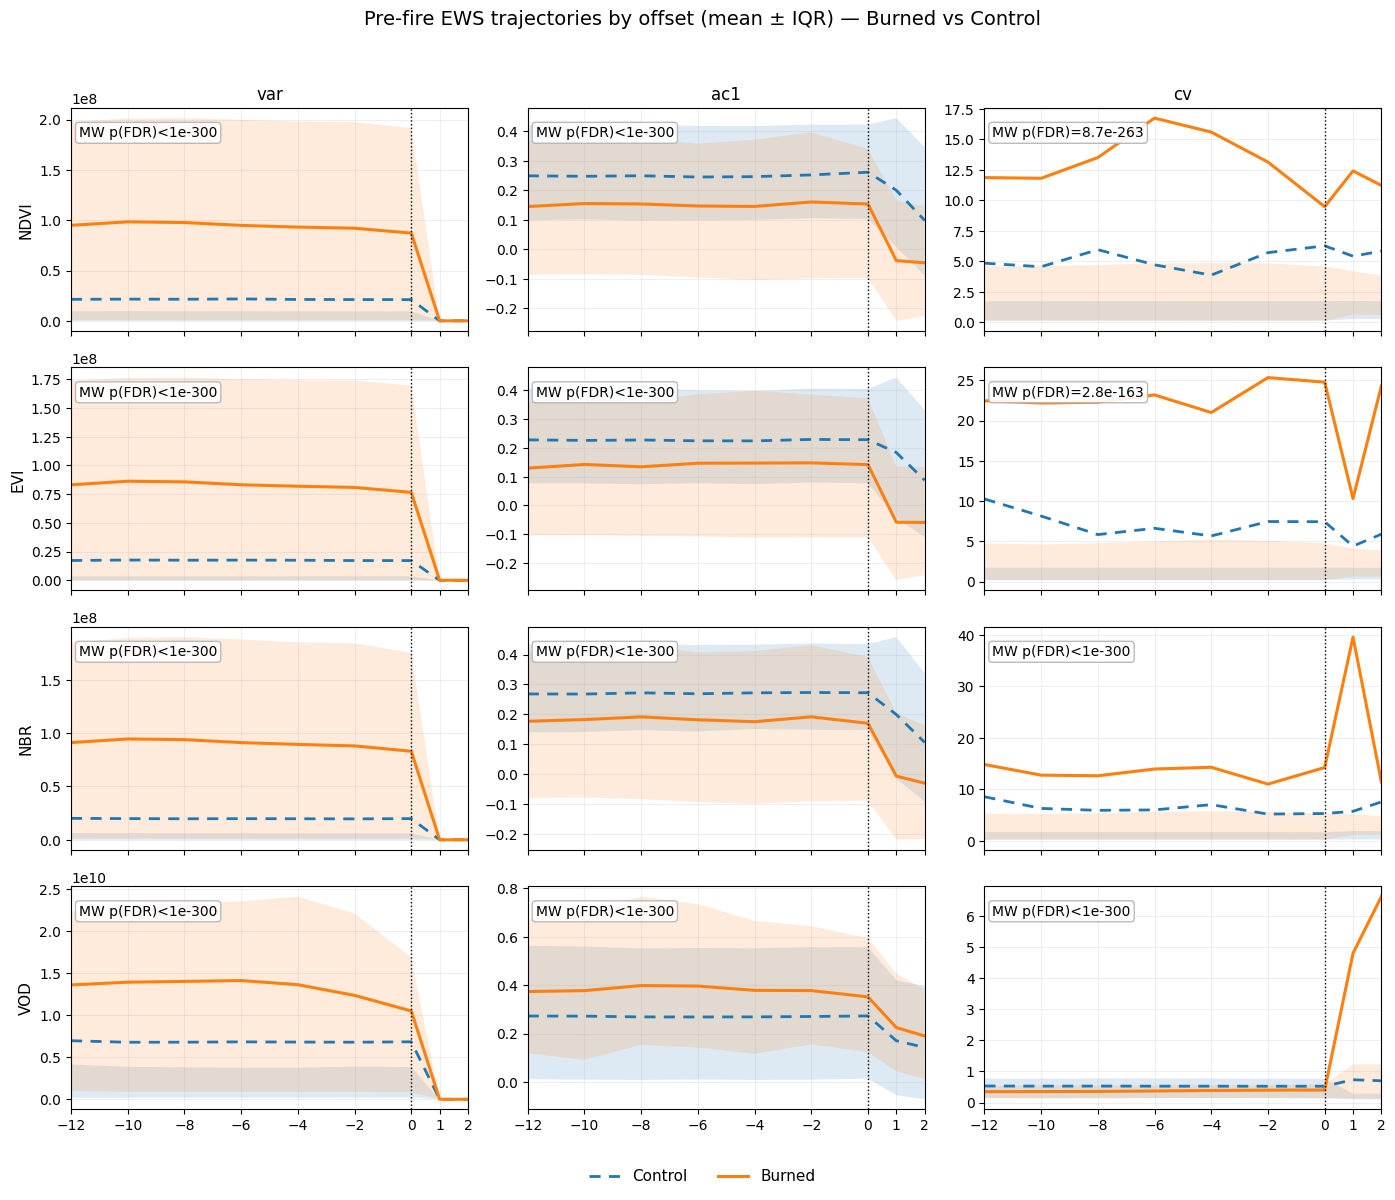

In [ ]:
# @title Painel 3x4 (média ± IQR), offsets [-12..+2], fontes maiores e título mais próximo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
IN_CSV = ROOT/'index/outputs/trend/summary/ews_offset_panel_stats.csv'

df = pd.read_csv(IN_CSV)

# Limita o pré-fogo a 6 bimestres e mantém +1,+2
df = df[(df['offset']>=-12) & (df['offset']<=2)].copy()

indices = ['NDVI','EVI','NBR','VOD']
metrics = ['var','ac1','cv']

# Estilo
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'legend.fontsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

fig, axes = plt.subplots(len(indices), len(metrics), figsize=(14,12), sharex=True)
fig.suptitle('Pre-fire EWS trajectories by offset (mean ± IQR) — Burned vs Control',
             y=0.98, fontsize=14)

# Cabeçalhos das colunas
col_titles = {'var':'var','ac1':'ac1','cv':'cv'}

for r, idx in enumerate(indices):
    for c, met in enumerate(metrics):
        ax = axes[r, c]
        sub = df[(df['index']==idx) & (df['metric']==met)].sort_values('offset')
        if sub.empty:
            ax.set_visible(False); continue

        x = sub['offset'].values

        # médias e IQR já prontos no CSV
        yb, q25b, q75b = sub['mean_b'].values, sub['q25_b'].values, sub['q75_b'].values
        yc, q25c, q75c = sub['mean_c'].values, sub['q25_c'].values, sub['q75_c'].values

        # controle = azul tracejado; queimado = laranja contínuo
        ax.plot(x, yc, linestyle=(0,(4,3)), linewidth=2.0, label='Control')
        ax.fill_between(x, q25c, q75c, alpha=0.15)

        ax.plot(x, yb, linestyle='-', linewidth=2.2, label='Burned')
        ax.fill_between(x, q25b, q75b, alpha=0.15)

        # Linha vertical no evento (0)
        ax.axvline(0, color='k', linestyle=':', linewidth=1.0)

        # MW p(FDR) no canto (se houver)
        if 'p_fdr' in sub.columns and np.isfinite(sub['p_fdr']).any():
            try:
                pval = float(sub['p_fdr'].iloc[0])
                txt = f"MW p(FDR)={pval:.1e}" if pval>0 else "MW p(FDR)<1e-300"
                ax.text(0.02, 0.92, txt, transform=ax.transAxes,
                        ha='left', va='top', fontsize=10,
                        bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='0.7', alpha=0.9))
            except Exception:
                pass

        # Rótulos do eixo Y: nome do índice na linha da esquerda
        if c==0:
            ax.set_ylabel(idx)

        # Títulos das colunas uma única vez
        if r==0:
            ax.set_title(col_titles[met])

        # Eixo X com poucos ticks e mais “aberto”
        ax.set_xlim(-12, 2)
        ax.set_xticks([-12,-10,-8,-6,-4,-2,0,1,2])

        ax.grid(alpha=0.2)

# Legenda única
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.01))

fig.tight_layout(rect=[0,0.03,1,0.96])
plt.show()


Plotando linhas: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


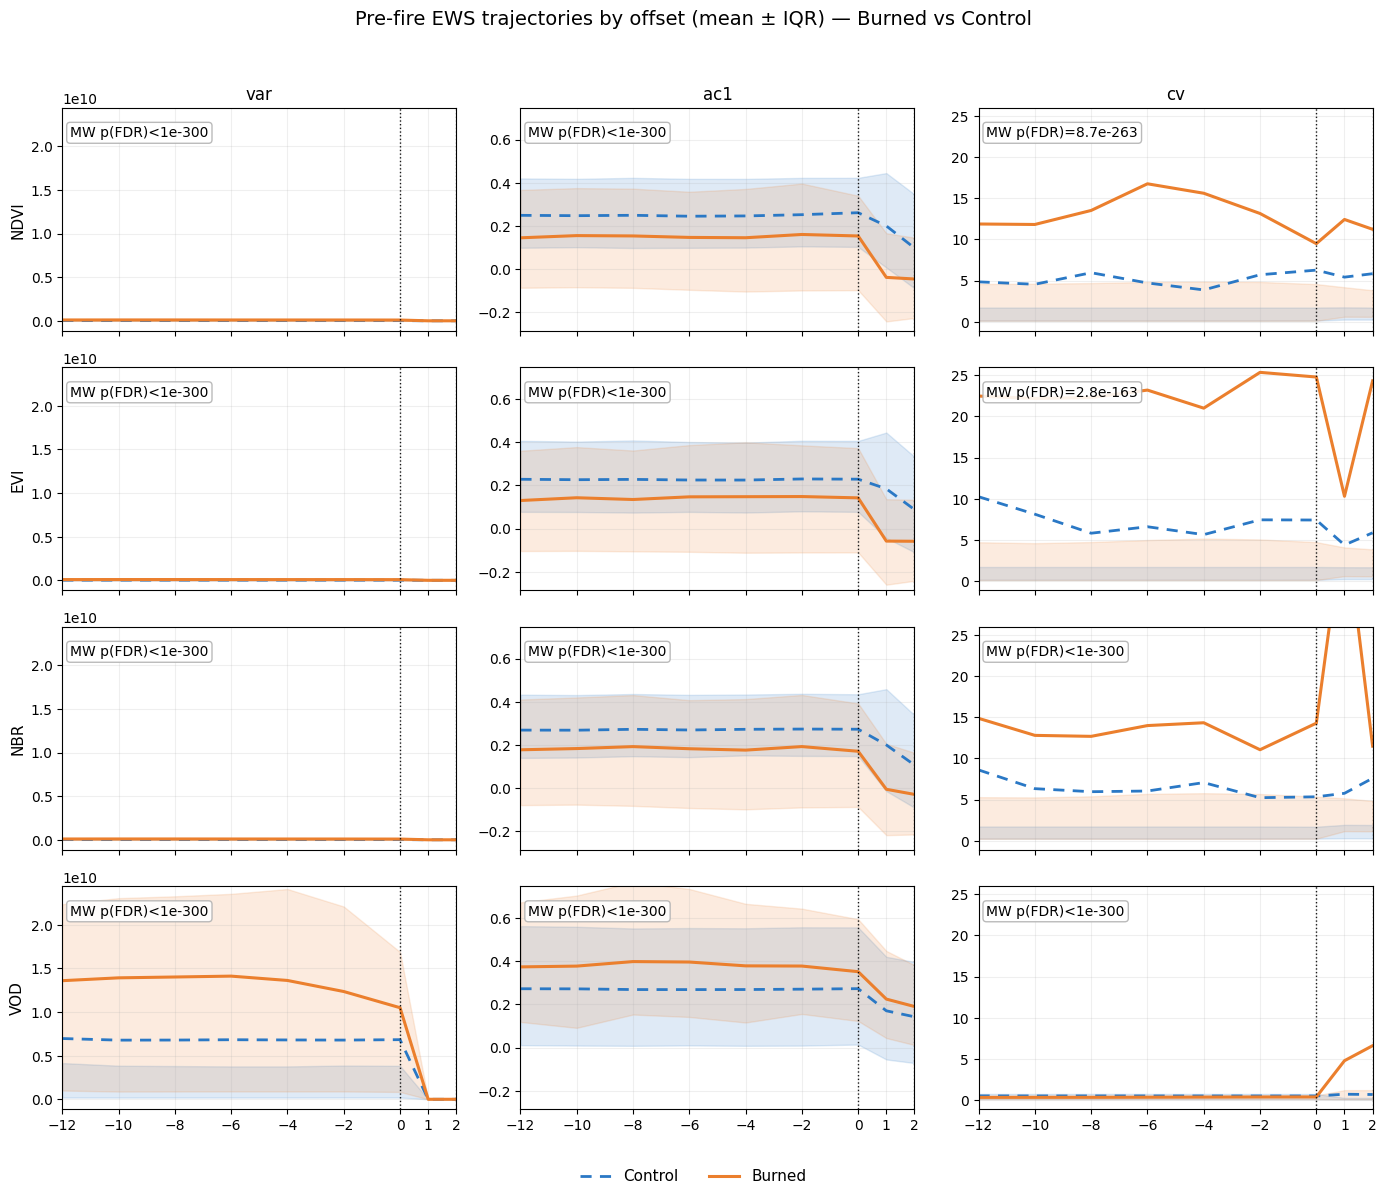

In [ ]:
#  @title Painel 3x4 (média ± IQR), offsets [-12..+2], escala comparável por MÉTRICA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# ---------- ENTRADA ----------
ROOT   = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
IN_CSV = ROOT/'index/outputs/trend/summary/ews_offset_panel_stats.csv'  # (seu arquivo)
OFF_MIN, OFF_MAX = -12, 2

# Ordem e aparência
indices = ['NDVI','EVI','NBR','VOD']
metrics = ['var','ac1','cv']
COLOR_CTRL = "#2a78c5"  # azul (controle)
COLOR_BURN = "#eb7f2d"  # laranja (queimado)
LW_CTRL, LW_BURN = 2.0, 2.2
ALPHA_BAND = 0.15

# ---------- COMO DEFINIR A ESCALA ----------
# 'metric'        -> mesma escala por MÉTRICA (var/ac1/cv) em todos os índices (recomendado p/ comparar painéis)
# 'metric_index'  -> escala por MÉTRICA+ÍNDICE (mantém variação própria de cada índice)
MATCH_SCALE_MODE = 'metric'

# Clip robusto (evita que 1 ou 2 valores extremos "estourem" o eixo)
ROBUST_CLIP = True
ROBUST_QS   = (0.01, 0.99)

# Definir limites manualmente (opcional): por métrica (quando MATCH_SCALE_MODE='metric')
# Ex.: MANUAL_YLIMS = {'var':(-0.5,2.0), 'ac1':(0.0,1.0), 'cv':(0.0,1.2)}
MANUAL_YLIMS = {}  # deixe vazio para calcular dos dados

# ---------- ESTILO ----------
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'legend.fontsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

# ---------- CARREGA E FILTRA ----------
df = pd.read_csv(IN_CSV)
df = df[(df['offset']>=OFF_MIN) & (df['offset']<=OFF_MAX)].copy()
df['index']  = pd.Categorical(df['index'],  indices, ordered=True)
df['metric'] = pd.Categorical(df['metric'], metrics, ordered=True)
df.sort_values(['index','metric','offset'], inplace=True)

# ---------- FUNÇÃO PARA CALCULAR YLIMS ----------
def calc_ylims(subframe):
    vals = np.concatenate([
        subframe[['mean_b','q25_b','q75_b']].values.ravel(),
        subframe[['mean_c','q25_c','q75_c']].values.ravel()
    ])
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return (0.0, 1.0)
    if ROBUST_CLIP:
        lo, hi = np.quantile(vals, ROBUST_QS)
    else:
        lo, hi = np.min(vals), np.max(vals)
    pad = 0.05*(hi - lo) if (hi - lo) > 0 else 1.0
    return (lo - pad, hi + pad)

# ---------- PREPARA LIMITES ----------
ylims_metric = {}
ylims_metric_index = {}

# escala por MÉTRICA
for met in metrics:
    if MANUAL_YLIMS.get(met) is not None and MATCH_SCALE_MODE=='metric':
        ylims_metric[met] = tuple(MANUAL_YLIMS[met])
    else:
        ylims_metric[met] = calc_ylims(df[df['metric']==met])

# escala por MÉTRICA+ÍNDICE (se necessário)
if MATCH_SCALE_MODE == 'metric_index':
    for idx in indices:
        for met in metrics:
            key = (idx, met)
            ylims_metric_index[key] = calc_ylims(df[(df['index']==idx)&(df['metric']==met)])

# ---------- PLOT ----------
fig, axes = plt.subplots(len(indices), len(metrics), figsize=(14,12), sharex=True)
fig.suptitle('Pre-fire EWS trajectories by offset (mean ± IQR) — Burned vs Control',
             y=0.98, fontsize=14)

for r, idx in enumerate(tqdm(indices, desc="Plotando linhas")):
    for c, met in enumerate(metrics):
        ax  = axes[r, c]
        sub = df[(df['index']==idx) & (df['metric']==met)].sort_values('offset')
        if sub.empty:
            ax.set_visible(False); continue

        x = sub['offset'].values

        # --- Controle (azul tracejado) ---
        yc, q25c, q75c = sub['mean_c'].values, sub['q25_c'].values, sub['q75_c'].values
        ax.plot(x, yc, color=COLOR_CTRL, linestyle=(0,(4,3)), linewidth=LW_CTRL, label='Control')
        ax.fill_between(x, q25c, q75c, color=COLOR_CTRL, alpha=ALPHA_BAND)

        # --- Queimado (laranja contínuo) ---
        yb, q25b, q75b = sub['mean_b'].values, sub['q25_b'].values, sub['q75_b'].values
        ax.plot(x, yb, color=COLOR_BURN, linestyle='-', linewidth=LW_BURN, label='Burned')
        ax.fill_between(x, q25b, q75b, color=COLOR_BURN, alpha=ALPHA_BAND)

        # Evento (0) e +2
        ax.axvline(0, color='k', linestyle=':', linewidth=1.0, alpha=0.9)
        ax.axvline(2, color='k', linestyle=':', linewidth=1.0, alpha=0.6)

        # Limites Y conforme modo escolhido
        if MATCH_SCALE_MODE == 'metric':
            ax.set_ylim(*ylims_metric[met])
        else:
            ax.set_ylim(*ylims_metric_index[(idx,met)])

        # Eixo X
        ax.set_xlim(OFF_MIN, OFF_MAX)
        ax.set_xticks([-12,-10,-8,-6,-4,-2,0,1,2])
        ax.grid(alpha=0.2)

        # MW p(FDR) no canto, se existir
        if 'p_fdr' in sub.columns and np.isfinite(sub['p_fdr']).any():
            try:
                pval = float(sub['p_fdr'].iloc[0])
                txt = f"MW p(FDR)={pval:.1e}" if pval>0 else "MW p(FDR)<1e-300"
                ax.text(0.02, 0.92, txt, transform=ax.transAxes,
                        ha='left', va='top', fontsize=10,
                        bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='0.7', alpha=0.9))
            except Exception:
                pass

        # Rótulos
        if c==0:
            ax.set_ylabel(idx)
        if r==0:
            ax.set_title(met)

# Legenda única (primeiro eixo)
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], loc='lower center', ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.01))

fig.tight_layout(rect=[0,0.03,1,0.96])
plt.show()



In [ ]:
# @title R3-P3-A — Amostragem estratificada por tempo de recuperação POR ÍNDICE (C1–C4) [COM CHECKPOINT]
import numpy as np, pandas as pd
from pathlib import Path
import rasterio as rio
from rasterio.transform import xy

ROOT = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()

DESEAS_DIR   = ROOT/'index/outputs/deseason'   # z-scores
FIRE_DATE_FP = ROOT/'index/outputs/recovery_nb3/first_fire_yyyymm.tif'
RECOV_DIR    = ROOT/'index/outputs/recovery_nb3'  # contém recovery_time_{INDEX}_bimestres.tif

OUT_DIR   = ROOT/'index/outputs/trend/summary'
OUT_DIR.mkdir(parents=True, exist_ok=True)
PAIRS_CSV = OUT_DIR/'pairs_recov_by_index.csv'  # << saída principal (todas as amostras)

INDICES = ['NDVI','EVI','NBR','VOD']
N_TOTAL_PER_INDEX = 60000
RNG_SEED = 42
CLASSES = {  # limites em bimestres
    'C1_0to6'   : (0, 6),
    'C2_7to12'  : (7, 12),
    'C3_13to18' : (13, 18),
    'C4_gt18'   : (19, 10_000),
}
MIN_PER_CLASS = 5000  # por índice

# -------- checks base ----------
assert FIRE_DATE_FP.exists(), f'first_fire_yyyymm não encontrado: {FIRE_DATE_FP}'
with rio.open(FIRE_DATE_FP) as ds_fire:
    fire_meta = ds_fire.meta.copy()
    H, W = ds_fire.height, ds_fire.width
    fire = ds_fire.read(1).astype('f8')
    nd_f = ds_fire.nodata
    if nd_f is not None:
        fire = np.where(fire==nd_f, np.nan, fire)

rng = np.random.default_rng(RNG_SEED)
all_rows = []

for idx in INDICES:
    recov_fp = RECOV_DIR / f'recovery_time_{idx}_bimestres.tif'
    assert recov_fp.exists(), f'Raster de recovery por índice não encontrado: {recov_fp}'
    with rio.open(recov_fp) as ds_rec:
        # validade espacial
        assert ds_rec.crs == fire_meta['crs'] and ds_rec.transform == fire_meta['transform'] \
               and ds_rec.width == W and ds_rec.height == H, f'Grade/CRS não batem para {idx}'
        rec = ds_rec.read(1).astype('f8')
        nd_r = ds_rec.nodata
        if nd_r is not None:
            rec = np.where(rec==nd_r, np.nan, rec)

    m_valid = np.isfinite(fire) & np.isfinite(rec)

    # classifica cada pixel queimado do índice
    cls = np.full_like(rec, '', dtype=object)
    for cname, (a, b) in CLASSES.items():
        cls = np.where(m_valid & (rec>=a) & (rec<=b), cname, cls)

    per_class_idx = {k: np.where(cls==k) for k in CLASSES.keys()}
    avail = {k: len(per_class_idx[k][0]) for k in CLASSES.keys()}
    sum_avail = sum(avail.values())
    if sum_avail == 0:
        print(f'⚠ {idx}: sem pixels válidos com tempo de recuperação.')
        continue

    base_each = max(MIN_PER_CLASS, N_TOTAL_PER_INDEX // max(len(CLASSES),1))
    alloc = {}
    rest = N_TOTAL_PER_INDEX
    for k in CLASSES.keys():
        take = min(avail[k], base_each)
        alloc[k] = take
        rest -= take

    if rest > 0:
        weights = np.array([max(avail[k]-alloc[k], 0) for k in CLASSES.keys()], dtype='f8')
        if weights.sum() > 0:
            share = np.floor(rest * (weights/weights.sum())).astype(int)
            for w,(k) in zip(share, CLASSES.keys()):
                add = int(min(avail[k]-alloc[k], w))
                alloc[k] += add
                rest -= add
    if rest > 0:
        for k in CLASSES.keys():
            if rest==0: break
            if alloc[k] < avail[k]:
                alloc[k] += 1
                rest -= 1

    # amostra e salva
    with rio.open(FIRE_DATE_FP) as ds_fire:
        for k in CLASSES.keys():
            n = alloc[k]
            if n <= 0: continue
            rr, cc = per_class_idx[k]
            pick = rng.choice(len(rr), size=n, replace=False)
            r_sel, c_sel = rr[pick], cc[pick]
            xs, ys = [], []
            for r,c in zip(r_sel, c_sel):
                x, y = xy(ds_fire.transform, r, c, offset='center')
                xs.append(x); ys.append(y)
            fy = fire[r_sel, c_sel].astype('f8')
            rt = rec[r_sel, c_sel].astype('f8')
            for x,y,fy_i,rt_i in zip(xs,ys,fy,rt):
                all_rows.append(dict(index=idx, x=x, y=y,
                                     fire_ym=int(fy_i), recov_bi=int(rt_i),
                                     recov_class=k))

pairs = pd.DataFrame(all_rows)
pairs.to_csv(PAIRS_CSV, index=False)
print(f"✓ Amostragem estratificada POR ÍNDICE salva ({len(pairs)} pts) → {PAIRS_CSV}")
pairs.groupby('index')['recov_class'].value_counts().unstack(fill_value=0)



✓ Amostragem estratificada POR ÍNDICE salva (240000 pts) → /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/pairs_recov_by_index.csv


recov_class,C1_0to6,C2_7to12,C3_13to18
index,,,
EVI,42875,15159,1966
NBR,42083,15381,2536
NDVI,44188,15067,745
VOD,28085,16236,15679


In [ ]:
# @title P3-A — Painel de recuperação (queimados) → CSV (−6..+18) c/ checkpoint
import os, re, json, math
from pathlib import Path
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.windows import Window
from tqdm.auto import tqdm

# ---------- Config ----------
ROOT = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
DESEAS_DIR  = ROOT/'index/outputs/deseason'  # z-scores por índice
FIRE_DATE   = ROOT/'index/outputs/recovery_nb3/first_fire_yyyymm.tif'
RECOV_DIR   = ROOT/'index/outputs/recovery_nb3'  # recovery_time_<IDX>_bimestres.tif (por índice)
OUT_SUM_DIR = ROOT/'index/outputs/trend/summary'
OUT_SUM_DIR.mkdir(parents=True, exist_ok=True)

PANEL_CSV   = OUT_SUM_DIR/'p3_offset_panel_stats.csv'
PANEL_CSV_BY= OUT_SUM_DIR/'p3_offset_panel_stats_by_index.csv'
CKPT_JSON   = OUT_SUM_DIR/'p3_ckpt.json'

INDICES   = ['NDVI','EVI','NBR','VOD']
METRICS   = ['var','ac1','cv']
BIMES_SET = (1,3,5,7,9,11)
OFFSETS   = list(range(-6, 19))  # −6..+18
W         = 8                     # janela em bimestres
N_BURN    = 60000                 # amostra de queimados
SEED      = 42
NODATA    = -32768.0

# ---------- Utils ----------
def build_catalog_z(idx:str):
    pat = re.compile(rf'(^|/){idx}.*_deseason_z_(\d{{6}}).*_300m\.tif$', re.IGNORECASE)
    hits = {}
    for p in (DESEAS_DIR/idx).glob('*.tif'):
        m = pat.search(str(p))
        if m:
            ym = int(m.group(2))
            hits[ym] = p
    return dict(sorted(hits.items()))

def ym_add(yyyymm:int, k:int)->int:
    y = yyyymm//100; m = yyyymm%100
    m2 = m + 2*k                  # passo bimestral
    y += (m2-1)//12
    m = ((m2-1)%12)+1
    # ajustar para BIMES_SET (1,3,5,7,9,11)
    if m not in BIMES_SET:
        # "encaixa" no bimestre válido mais próximo abaixo
        m = max([b for b in BIMES_SET if b<=m] or [1])
    return y*100 + m

def ac1_lag1(x, axis=0):
    x = np.asarray(x, float)
    mu = np.nanmean(x, axis=axis, keepdims=True)
    x0 = x - mu
    num = np.nanmean(x0.take(range(1,x.shape[axis]), axis=axis)*
                     x0.take(range(0,x.shape[axis]-1), axis=axis), axis=axis)
    den = np.nanvar(x, axis=axis)
    out = np.divide(num, den, out=np.full_like(num, np.nan), where=den>0)
    return out

def roll_metrics_from_z(stack):  # stack shape: (T, H, W)
    mu  = np.nanmean(stack, axis=0)
    sd  = np.nanstd(stack, axis=0, ddof=0)
    var = sd**2
    with np.errstate(divide='ignore', invalid='ignore'):
        cv = np.where(mu!=0, sd/np.abs(mu), np.nan)
    ac1 = ac1_lag1(stack, axis=0)
    return var, ac1, cv

def load_ckpt():
    if CKPT_JSON.exists():
        try: return json.loads(CKPT_JSON.read_text())
        except: return {}
    return {}

def save_ckpt(obj):
    CKPT_JSON.write_text(json.dumps(obj))

# ---------- Amostra de queimados ----------
rng = np.random.default_rng(SEED)
assert FIRE_DATE.exists(), f"first_fire_yyyymm.tif não encontrado: {FIRE_DATE}"

with rio.open(FIRE_DATE) as dsf:
    fire_meta = dsf.meta.copy()
    H, Wd = dsf.height, dsf.width
    fire_all = dsf.read(1).astype('f8')
    nd = dsf.nodata
    if nd is not None:
        fire_all = np.where(fire_all==nd, np.nan, fire_all)
    burned_mask = np.isfinite(fire_all)  # pixel queimado tem um yyyymm
    yy = np.where(burned_mask)[0]; xx = np.where(burned_mask)[1]
    if yy.size==0:
        raise RuntimeError("Máscara de queimados vazia (first_fire sem dados finitos).")
    take = min(N_BURN, yy.size)
    idx_sel = rng.choice(np.arange(yy.size), size=take, replace=False)
    samp_rc = list(zip(yy[idx_sel], xx[idx_sel]))

# ---------- Loop por índice ----------
ckpt = load_ckpt()
rows_all = []   # (compacto) soma/percentis por offset/índice/métrica
rows_by  = []   # (detalhado) amostras por índice

for idx in INDICES:
    # catálogo de z-scores
    catalog = build_catalog_z(idx)
    assert len(catalog)>0, f"[{idx}] nenhum z-score encontrado em {DESEAS_DIR/idx}"

    # recovery_time por índice
    rec_fp = RECOV_DIR/f"recovery_time_{idx}_bimestres.tif"
    assert rec_fp.exists(), f"Arquivo de recovery por índice não encontrado: {rec_fp}"

    done_key = f"{idx}::done_offsets"
    done_set = set(ckpt.get(done_key, []))

    # Construir matriz (R,C) da data de fogo para lookup rápido
    with rio.open(FIRE_DATE) as dsf:
        fire = dsf.read(1).astype('i4')
        if dsf.nodata is not None:
            fire = np.where(fire==dsf.nodata, 0, fire)

    # Pré-carrega recovery_time (usaremos só para filtrar classes se precisar depois)
    with rio.open(rec_fp) as dsr:
        rec_time = dsr.read(1).astype('i4')
        if dsr.nodata is not None:
            rec_time = np.where(rec_time==dsr.nodata, -1, rec_time)

    # Pré-carrega catálogo em dict (para acesso rápido)
    # (não lê os arrays aqui; só mapeia meses → caminho)
    z_catalog = catalog

    # Função auxiliar: devolve pilha (T, n) para uma lista de yyyymm
    def read_stack_points(ym_list, points):
        T = len(ym_list); n = len(points)
        M = np.full((T, n), np.nan, 'f4')
        for t, ym in enumerate(ym_list):
            fp = z_catalog.get(ym)
            if fp is None:
                continue
            with rio.open(fp) as ds:
                for j,(r,c) in enumerate(points):
                    val = ds.read(1, window=Window(c, r, 1, 1))[0,0]
                    if ds.nodata is not None and val==ds.nodata:
                        val = np.nan
                    M[t, j] = val
        return M

    # Barra de progresso por offsets
    pbar = tqdm(OFFSETS, desc=f"P3 {idx} (−6..+18)", unit="off")
    for t_off in pbar:
        if t_off in done_set:
            continue

        # para cada ponto amostral, computa a janela de W bimestres que termina no offset t_off relativo ao first_fire
        # lista de yms por ponto (variável): para eficiência, vamos agrupar por ym_ref alvo e reutilizar leituras
        # 1) descobrir todos os YM alvo que aparecem na amostra para este t_off
        ym_targets = {}
        for (r,c) in samp_rc:
            fy = int(fire[r,c])
            if fy<=0:
                continue
            ym_ref = ym_add(fy, t_off)   # yyyymm no offset
            # constrói a janela de W bimestres terminando em ym_ref
            yms = [ym_add(ym_ref, -k) for k in range(W-1, -1, -1)]
            ym_targets.setdefault(tuple(yms), []).append((r,c))

        # 2) para cada grupo de yms iguais, lê a pilha em bloco para esses pontos
        list_means = {m:[] for m in METRICS}
        for yms, pts in ym_targets.items():
            M = read_stack_points(list(yms), pts)  # shape (W, n_pts)
            # calcula métricas por ponto (no tempo)
            mu  = np.nanmean(M, axis=0)
            sd  = np.nanstd(M, axis=0, ddof=0)
            var = sd**2
            with np.errstate(divide='ignore', invalid='ignore'):
                cv = np.where(mu!=0, sd/np.abs(mu), np.nan)
            # AC1 no tempo (lag-1)
            m = M
            m0 = m[:-1,:] - np.nanmean(m, axis=0, keepdims=True)
            m1 = m[1: ,:] - np.nanmean(m, axis=0, keepdims=True)
            num = np.nanmean(m0*m1, axis=0)
            den = np.nanvar(m, axis=0)
            ac1 = np.divide(num, den, out=np.full_like(num, np.nan), where=den>0)

            list_means['var'].extend(var.tolist())
            list_means['ac1'].extend(ac1.tolist())
            list_means['cv' ].extend(cv.tolist())

        # 3) agrega estatística robusta para o painel
        for met in METRICS:
            arr = np.array(list_means[met], dtype='f4')
            arr = arr[np.isfinite(arr)]
            if arr.size==0:
                row = dict(index=idx, metric=met, offset=t_off,
                           mean_b=np.nan, q25_b=np.nan, q75_b=np.nan, n_b=0)
            else:
                q25, q75 = (np.quantile(arr, 0.25), np.quantile(arr, 0.75))
                row = dict(index=idx, metric=met, offset=t_off,
                           mean_b=float(np.nanmean(arr)),
                           q25_b=float(q25), q75_b=float(q75), n_b=int(arr.size))
            rows_all.append(row)
            rows_by.append({**row, 'group':'burned'})

        # checkpoint por offset
        done_set.add(t_off)
        ckpt[done_key] = sorted(done_set)
        save_ckpt(ckpt)

        # flush incremental a cada 4 offsets
        if len(rows_all) >= 12:
            df_all = pd.DataFrame(rows_all)
            mode='a' if PANEL_CSV.exists() else 'w'
            df_all.to_csv(PANEL_CSV, index=False, mode=mode, header=not PANEL_CSV.exists())
            rows_all.clear()
        if len(rows_by) >= 12:
            df_by = pd.DataFrame(rows_by)
            mode='a' if PANEL_CSV_BY.exists() else 'w'
            df_by.to_csv(PANEL_CSV_BY, index=False, mode=mode, header=not PANEL_CSV_BY.exists())
            rows_by.clear()

    pbar.close()

# flush final
if rows_all:
    df_all = pd.DataFrame(rows_all)
    mode='a' if PANEL_CSV.exists() else 'w'
    df_all.to_csv(PANEL_CSV, index=False, mode=mode, header=not PANEL_CSV.exists())
if rows_by:
    df_by = pd.DataFrame(rows_by)
    mode='a' if PANEL_CSV_BY.exists() else 'w'
    df_by.to_csv(PANEL_CSV_BY, index=False, mode=mode, header=not PANEL_CSV_BY.exists())

print("✓ P3 painel (CSV) pronto:")
print("  →", PANEL_CSV)
print("  →", PANEL_CSV_BY)


/tmp/ipython-input-128096141.py:125: RuntimeWarning: invalid value encountered in cast
  rec_time = dsr.read(1).astype('i4')


P3 NDVI (−6..+18):   0%|          | 0/25 [00:00<?, ?off/s]

P3 EVI (−6..+18):   0%|          | 0/25 [00:00<?, ?off/s]

P3 NBR (−6..+18):   0%|          | 0/25 [00:00<?, ?off/s]

P3 VOD (−6..+18):   0%|          | 0/25 [00:00<?, ?off/s]

/tmp/ipython-input-128096141.py:182: RuntimeWarning: Mean of empty slice
  num = np.nanmean(m0*m1, axis=0)
/tmp/ipython-input-128096141.py:173: RuntimeWarning: Mean of empty slice
  mu  = np.nanmean(M, axis=0)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-128096141.py:180: RuntimeWarning: Mean of empty slice
  m0 = m[:-1,:] - np.nanmean(m, axis=0, keepdims=True)
/tmp/ipython-input-128096141.py:181: RuntimeWarning: Mean of empty slice
  m1 = m[1: ,:] - np.nanmean(m, axis=0, keepdims=True)
/tmp/ipython-input-128096141.py:183: RuntimeWarning: Degrees of freedom <= 0 for slice.
  den = np.nanvar(m, axis=0)


✓ P3 painel (CSV) pronto:
  → /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/p3_offset_panel_stats.csv
  → /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/p3_offset_panel_stats_by_index.csv


✓ Painel salvo em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/p3_panel_3x4_offsets.png


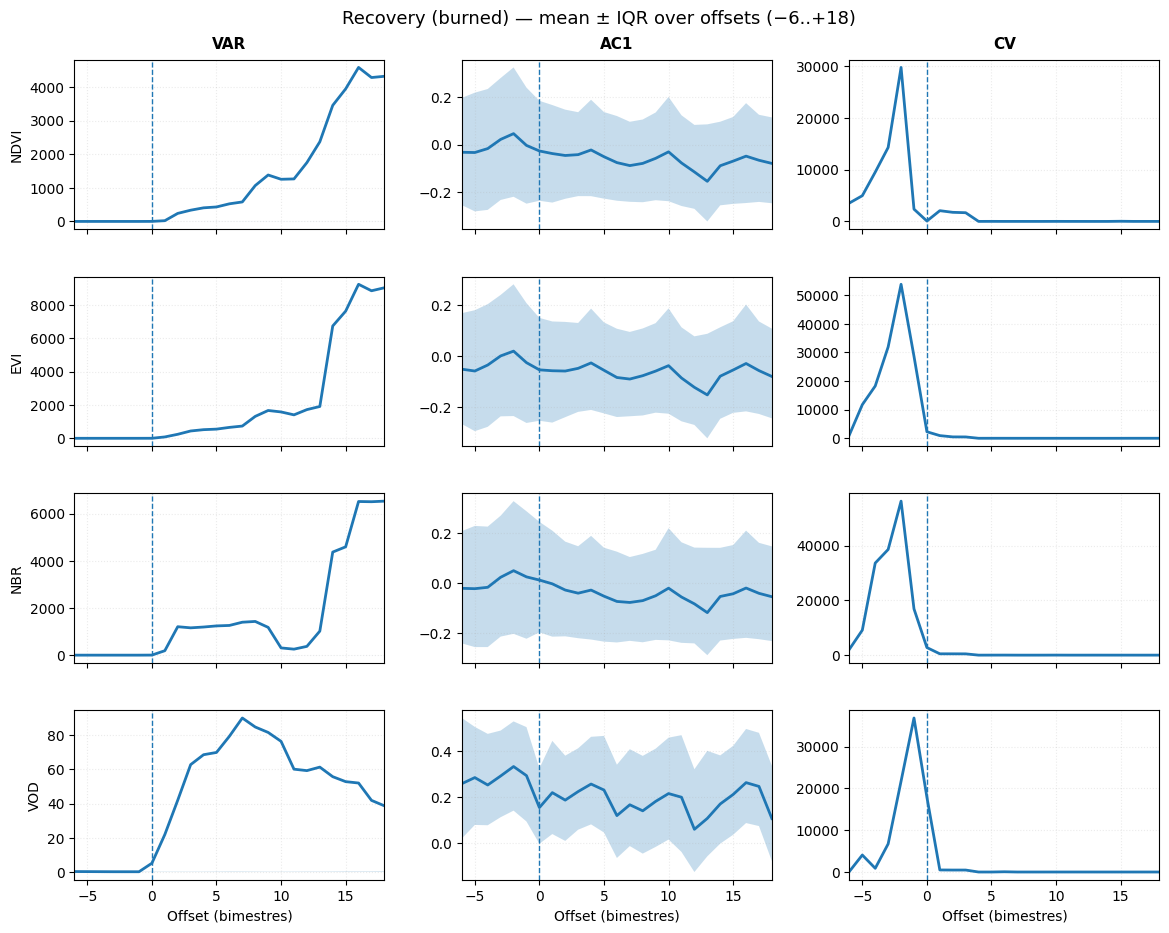

In [ ]:
# @title P3-B — Painel 3×4 offsets (−6..+18) queimados: média + IQR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
IN_CSV = ROOT/'index/outputs/trend/summary/p3_offset_panel_stats.csv'
OUT_PNG= ROOT/'index/outputs/trend/summary/p3_panel_3x4_offsets.png'

df = pd.read_csv(IN_CSV)
df = df[df['offset'].between(-6, 18)].copy()

INDICES = ['NDVI','EVI','NBR','VOD']
METRICS = ['var','ac1','cv']

fig, axes = plt.subplots(len(INDICES), len(METRICS), figsize=(14, 10), sharex=True)
plt.subplots_adjust(top=0.93, wspace=0.25, hspace=0.28)

for i, idx in enumerate(INDICES):
    for j, met in enumerate(METRICS):
        ax = axes[i, j]
        sub = df[(df['index']==idx) & (df['metric']==met)].sort_values('offset')
        x  = sub['offset'].values
        mu = sub['mean_b'].values
        q1 = sub['q25_b'].values
        q3 = sub['q75_b'].values

        ax.plot(x, mu, linestyle='-', linewidth=2)
        ax.fill_between(x, q1, q3, alpha=0.25, linewidth=0)

        # eixo e guias
        ax.axvline(0, lw=1, ls='--')
        ax.set_xlim(-6, 18)
        ax.grid(True, alpha=0.25, linestyle=':')
        if i==len(INDICES)-1:
            ax.set_xlabel("Offset (bimestres)")
        if j==0:
            ax.set_ylabel(idx)  # um índice por linha

        if i==0:
            ax.set_title(met.upper(), pad=8, fontsize=11, weight='bold')

fig.suptitle("Recovery (burned) — mean ± IQR over offsets (−6..+18)", fontsize=13, y=0.98)
fig.savefig(OUT_PNG, dpi=200, bbox_inches='tight')
print("✓ Painel salvo em:", OUT_PNG)


In [ ]:
# @title P3-C — Direction table (pós-fogo +1..+18) com τ, β̂ e p-stars (queimados)
import numpy as np, pandas as pd, math
from pathlib import Path

ROOT = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
IN_CSV = ROOT/'index/outputs/trend/summary/p3_offset_panel_stats.csv'
OUT_TAB= ROOT/'index/outputs/trend/summary/p3_direction_table_sig.csv'

INDICES = ['NDVI','EVI','NBR','VOD']
METRICS = ['var','ac1','cv']

def kendall_tau_p(x):
    x = np.asarray(x, float)
    msk = np.isfinite(x); x = x[msk]
    n = x.size
    if n<2: return np.nan, np.nan
    conc=disc=0
    for i in range(n-1):
        d = x[i+1:] - x[i]
        conc += np.sum(d>0); disc += np.sum(d<0)
    S = conc - disc
    P = n*(n-1)//2
    tau = np.nan if P==0 else S/float(P)
    # aproximação normal (sem empates fortes)
    v0 = (n*(n-1)*(2*n+5))/18
    if v0<=0: return tau, np.nan
    z = S/ math.sqrt(v0)
    p = 2.0*(0.5*math.erfc(abs(z)/math.sqrt(2)))
    return tau, p

def sen_slope(y):
    y = np.asarray(y, float)
    m = np.isfinite(y)
    y = y[m]
    n = y.size
    if n<2: return np.nan
    slopes=[]
    for i in range(n-1):
        dy = y[i+1:] - y[i]
        slopes.extend(dy.tolist())  # dt=1 entre offsets consecutivos
    return float(np.median(slopes)) if slopes else np.nan

def pstars(p):
    if not np.isfinite(p): return ""
    return "***" if p<1e-4 else ("**" if p<1e-2 else ("*" if p<5e-2 else ""))

df = pd.read_csv(IN_CSV)
df = df[(df['offset']>=1) & (df['offset']<=18)].copy()  # pós-fogo
rows=[]
for idx in INDICES:
    for met in METRICS:
        sub = df[(df['index']==idx)&(df['metric']==met)].sort_values('offset')
        yb  = sub['mean_b'].values
        tau_b, p_b = kendall_tau_p(yb)
        sen_b = sen_slope(yb)
        dir_b = 'increasing' if (np.nan_to_num(tau_b)>0 and np.nan_to_num(sen_b)>0) else \
                ('decreasing' if (np.nan_to_num(tau_b)<0 and np.nan_to_num(sen_b)<0) else 'mixed')
        rows.append(dict(index=idx, metric=met,
                         tau_b=round(tau_b,2) if np.isfinite(tau_b) else np.nan,
                         senslope_b=f"{sen_b:.2e}" if np.isfinite(sen_b) else np.nan,
                         dir_b=dir_b, sig_b=pstars(p_b)))
tab = pd.DataFrame(rows)
tab.to_csv(OUT_TAB, index=False)
print("✓ Saved:", OUT_TAB)
tab


✓ Saved: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/p3_direction_table_sig.csv


,index,metric,tau_b,senslope_b,dir_b,sig_b
0,NDVI,var,0.95,1.32e+03,increasing,***
1,NDVI,ac1,-0.36,-1.72e-02,decreasing,*
2,NDVI,cv,-0.46,-2.35e+00,decreasing,**
3,EVI,var,0.93,1.43e+03,increasing,***
4,EVI,ac1,-0.14,-3.19e-03,decreasing,
5,EVI,cv,-0.45,-2.76e+00,decreasing,**
6,NBR,var,0.45,1.00e+03,increasing,**
7,NBR,ac1,-0.18,-1.04e-02,decreasing,
8,NBR,cv,-0.32,-4.69e+00,decreasing,
9,VOD,var,-0.29,-8.09e+00,decreasing,


In [ ]:
# @title R3-P3-A (rebuild) — Amostra estratificada por TTR **por pixel** (gera pairs_recov_by_index.csv)
import json, math, random
from pathlib import Path
import numpy as np, pandas as pd
import rasterio as rio
from rasterio.transform import xy
from tqdm.auto import tqdm

ROOT = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
REC_DIR   = ROOT/'index/outputs/recovery_nb3'         # onde estão recovery_time_<IDX>_bimestres.tif
FIRE_FP   = ROOT/'index/outputs/recovery_nb3/first_fire_yyyymm.tif'
OUT_DIR   = ROOT/'index/outputs/trend/summary'
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV   = OUT_DIR/'pairs_recov_by_index.csv'
CKPT_JSON = OUT_DIR/'pairs_recov_pairs_ckpt.json'

INDICES = ['NDVI','EVI','NBR','VOD']
# classes de TTR (em bimestres)
BINS = [(0,6,'≤6'), (7,12,'7–12'), (13,18,'13–18')]
TARGET_PER_GROUP = 15000   # ajuste se quiser mais/menos
RANDOM_SEED = 42

def load_ckpt():
    if CKPT_JSON.exists():
        try:
            return json.loads(CKPT_JSON.read_text())
        except Exception:
            return {}
    return {}

def save_ckpt(d):
    CKPT_JSON.write_text(json.dumps(d))

rng = np.random.default_rng(RANDOM_SEED)
ckpt = load_ckpt()
done = set(ckpt.get('done_idx', []))

rows = []
if OUT_CSV.exists():
    # se já existir, carregue para continuar sem duplicar
    df_exist = pd.read_csv(OUT_CSV)
    rows.extend(df_exist.to_dict('records'))
    done.update(sorted(df_exist['index'].unique().tolist()))

with rio.open(FIRE_FP) as ds_fire:
    fire_nd = ds_fire.nodata
    fire_meta = ds_fire.meta.copy()

    for idx in tqdm(INDICES, desc="Build pairs by index"):
        if idx in done:
            continue

        rec_fp = REC_DIR / f"recovery_time_{idx}_bimestres.tif"
        assert rec_fp.exists(), f"[{idx}] não encontrei {rec_fp}"

        with rio.open(rec_fp) as dsr:
            H, W = dsr.height, dsr.width
            rec_nd = dsr.nodata

            # varre por blocos para economizar memória
            block = dsr.block_shapes[0] if dsr.block_shapes else (256,256)
            by, bx = block

            # coletores por grupo
            bag = {lab: [] for _,_,lab in BINS}

            for row in range(0, H, by):
                h = min(by, H-row)
                for col in range(0, W, bx):
                    w = min(bx, W-col)
                    window = rio.windows.Window(col_off=col, row_off=row, width=w, height=h)
                    ttr = dsr.read(1, window=window).astype('f4')
                    if rec_nd is not None:
                        ttr[ttr==rec_nd] = np.nan

                    # pega fire_ym no mesmo bloco (uma vez só)
                    fire = ds_fire.read(1, window=window).astype('f8')
                    if fire_nd is not None:
                        fire[fire==fire_nd] = np.nan

                    # centro dos pixels
                    # (linhas y0..y0+h-1, cols x0..x0+w-1)
                    r0, c0 = row, col
                    rr, cc = np.mgrid[r0:r0+h, c0:c0+w]
                    xs, ys = xy(dsr.transform, rr, cc, offset='center')
                    xs = np.asarray(xs, 'f8'); ys = np.asarray(ys, 'f8')

                    for lo, hi, lab in BINS:
                        m = (ttr>=lo) & (ttr<=hi) & np.isfinite(fire)
                        if not np.any(m):
                            continue
                        xs_sel = xs[m]; ys_sel = ys[m]; fire_sel = fire[m]
                        for x,y,fym in zip(xs_sel, ys_sel, fire_sel):
                            bag[lab].append((x,y,int(fym)))

            # amostra por grupo com teto TARGET_PER_GROUP
            for _,_,lab in BINS:
                pts = bag[lab]
                if not pts:
                    continue
                if len(pts) > TARGET_PER_GROUP:
                    idxs = rng.choice(len(pts), size=TARGET_PER_GROUP, replace=False)
                    pts = [pts[i] for i in idxs]
                # adiciona linhas
                for x,y,fym in pts:
                    rows.append(dict(x=x, y=y, index=idx, group=lab, fire_ym=int(fym)))

        # grava incremental por índice
        if rows:
            pd.DataFrame(rows).to_csv(OUT_CSV, index=False)
        done.add(idx)
        ckpt['done_idx'] = sorted(done)
        save_ckpt(ckpt)

print("✓ Amostra por pixel criada/atualizada →", OUT_CSV)


Build pairs by index:   0%|          | 0/4 [00:00<?, ?it/s]

✓ Amostra por pixel criada/atualizada → /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/pairs_recov_by_index.csv


In [ ]:
# @title R3-P3-fixcols — Normaliza cabeçalhos do pairs_recov_by_index.csv
import shutil, time
from pathlib import Path
import pandas as pd
import numpy as np
import re

ROOT = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
IN_CSV  = ROOT/'index/outputs/trend/summary/pairs_recov_by_index.csv'
assert IN_CSV.exists(), f"Não achei: {IN_CSV}"

# 1) ler de forma robusta (auto-separador; aceita ; ou ,; remove BOM)
df = pd.read_csv(IN_CSV, engine='python', sep=None)

# 2) normalizar nomes (lower, strip, troca variações comuns)
orig_cols = df.columns.tolist()
norm = {c: re.sub(r'\s+', '', c.strip().lower()) for c in df.columns}
df.rename(columns=norm, inplace=True)

# mapeamentos possíveis -> alvo
aliases = {
    'lon':'x','longitude':'x','long':'x','lng':'x','xcoord':'x','coordx':'x',
    'lat':'y','latitude':'y','ycoord':'y','coordy':'y',
    'idx':'index','indice':'index','índice':'index',
    'grupo':'group','recov_class':'group','class':'group'
}
for a,t in aliases.items():
    if a in df.columns and t not in df.columns:
        df.rename(columns={a:t}, inplace=True)

# 3) checar/ajustar mínimos
required = {'x','y','index','group'}
missing = required - set(df.columns)
assert not missing, f"Ainda faltam colunas: {missing} (colunas atuais: {list(df.columns)})"

# 4) padronizar valores
# index em maiúsculas (NDVI/EVI/NBR/VOD)
df['index'] = df['index'].astype(str).str.upper().str.strip()

# group: aceitar variações e mapear para '≤6','7–12','13–18'
def norm_group(g):
    s = str(g).strip()
    s = s.replace('C1_0to6','≤6').replace('C2_7to12','7–12').replace('C3_13to18','13–18')
    s = s.replace('<=6','≤6').replace('≤ 6','≤6').replace('7-12','7–12').replace('13-18','13–18')
    return s
df['group'] = df['group'].apply(norm_group)

# tipos numéricos para coords; fire_ym se existir vira int
df['x'] = pd.to_numeric(df['x'], errors='coerce')
df['y'] = pd.to_numeric(df['y'], errors='coerce')
if 'fire_ym' in df.columns:
    df['fire_ym'] = pd.to_numeric(df['fire_ym'], errors='coerce').astype('Int64')

# 5) remover linhas sem coord/index/group válidos
before = len(df)
df = df[df[['x','y','index','group']].notnull().all(axis=1)].copy()
after = len(df)

# 6) backup e salvar por cima
bak = IN_CSV.with_suffix(f".bak_{int(time.time())}.csv")
shutil.copy2(IN_CSV, bak)
df.to_csv(IN_CSV, index=False)

print("✓ Normalizado.")
print("Arquivo:", IN_CSV)
print("Backup  :", bak)
print(f"Linhas: {after} (removidas {before-after} inválidas)")
print("Colunas:", list(df.columns))
print("\nAmostra:")
display(df.head(5))


✓ Normalizado.
Arquivo: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/pairs_recov_by_index.csv
Backup  : /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/pairs_recov_by_index.bak_1762480207.csv
Linhas: 240000 (removidas 0 inválidas)
Colunas: ['index', 'x', 'y', 'fire_ym', 'recov_bi', 'group']

Amostra:


,index,x,y,fire_ym,recov_bi,group
0,NDVI,-739050.0,7906650.0,199909,1,≤6
1,NDVI,-791850.0,7882950.0,201309,2,≤6
2,NDVI,-609750.0,8138850.0,199107,4,≤6
3,NDVI,-877350.0,7771050.0,199607,1,≤6
4,NDVI,-800850.0,7644750.0,199509,1,≤6


In [ ]:
# @title R3-P3-fastTTR — Painel por grupos de TTR (C1/C2/C3): média e IQR de VAR/AC1/CV por offset (−6..+18) com checkpoint
import os, re, json, math, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.windows import Window
from tqdm.auto import tqdm

warnings.filterwarnings("ignore", message="Mean of empty slice")
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice.")

# --------------------- Config ---------------------
ROOT      = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
DESEAS    = ROOT/'index/outputs/deseason'         # contém *_deseason_z_YYYYMM_300m.tif
PAIRSCSV  = ROOT/'index/outputs/trend/summary/pairs_recov_by_index.csv'  # 240k pontos estratificados por índice (com TTR)
OUT_SUM   = ROOT/'index/outputs/trend/summary'
OUT_SUM.mkdir(parents=True, exist_ok=True)

OUT_CSV   = OUT_SUM/'p3_offset_panel_stats_by_TTR.csv'
CKPT_JSON = OUT_SUM/'p3_byTTR_ckpt.json'

INDICES   = ['NDVI','EVI','NBR','VOD']
BIMES     = (1,3,5,7,9,11)
Y0, Y1    = 1987, 2021
W         = 8                                    # janela (bimestres) para as métricas
OFFS      = list(range(-6, 19))                  # offsets −6 .. +18 (pós-fogo para recuperação)
BATCH_FLUSH = 5000                               # linhas para flush incremental

# Colunas alvo do CSV final
CSV_COLS = ['index','group','metric','offset','mean','q25','q75','n']

# --------------------- Checkpoint helpers ---------------------
def load_ckpt():
    if CKPT_JSON.exists():
        try:
            return json.loads(CKPT_JSON.read_text())
        except Exception:
            pass
    return {}

def save_ckpt(obj):
    CKPT_JSON.write_text(json.dumps(obj))

ckpt = load_ckpt()
done_indices = set(ckpt.get("done_indices", []))

# --------------------- Utilitários ---------------------
def build_catalog_z(idx: str):
    """
    Mapeia YYYYMM -> caminho do z-score dessazonalizado para o índice.
    Ex.: NDVI_deseason_z_199901_300m.tif
    """
    pat = re.compile(rf'(^|/){idx}.*_deseason_z_(\d{{6}}).*_300m\.tif$', re.IGNORECASE)
    hits = {}
    for p in (DESEAS/idx).glob('*.tif'):
        m = pat.search(str(p))
        if m:
            ym = int(m.group(2))
            if (Y0*100+1) <= ym <= (Y1*100+11):
                hits[ym] = p
    # também vasculha recursivo caso a estrutura não esteja por subpastas:
    if not hits:
        for p in DESEAS.rglob('*.tif'):
            m = pat.search(str(p))
            if m:
                ym = int(m.group(2))
                if (Y0*100+1) <= ym <= (Y1*100+11):
                    hits[ym] = p
    return dict(sorted(hits.items()))

def ac1_lag1(series_2d):
    # series_2d: T x N
    if series_2d.size == 0:
        return np.full(series_2d.shape[1] if series_2d.ndim==2 else 0, np.nan, dtype='f4')
    mu = np.nanmean(series_2d, axis=0, keepdims=True)
    m0 = series_2d[:-1,:] - mu
    m1 = series_2d[1: ,:] - mu
    num = np.nanmean(m0*m1, axis=0)
    den = np.nanvar(series_2d, axis=0)
    with np.errstate(invalid='ignore', divide='ignore'):
        out = np.where(den>0, num/den, np.nan)
    return out.astype('f4')

def roll_metrics(stack_TxN, W=8):
    """
    Recebe stack T x N (z-scores ao longo do tempo para N pontos) e
    devolve dict end_ti -> (var[N], ac1[N], cv[N]) para cada janela de tamanho W.
    """
    T, N = stack_TxN.shape
    res = {}
    if T < W:
        return res
    for end in range(W-1, T):
        win = stack_TxN[end-W+1:end+1, :]
        if not np.isfinite(win).any():
            continue
        mu  = np.nanmean(win, axis=0)
        sd  = np.nanstd (win, axis=0, ddof=0)
        var = (sd**2).astype('f4')
        with np.errstate(invalid='ignore', divide='ignore'):
            cv  = np.where(mu!=0, sd/np.abs(mu), np.nan).astype('f4')
        ac1 = ac1_lag1(win)
        res[end] = (var, ac1, cv)
    return res

def yyyymm_iter(y0, y1, months=BIMES):
    for y in range(y0, y1+1):
        for m in months:
            yield y*100+m

def align_month_to_bimes(m):
    if m in BIMES:
        return m
    # usa o maior bimestre <= m; se nada, devolve 11 (comportamento conservador)
    le = [mm for mm in BIMES if mm <= m]
    return max(le) if le else 11

# --------------------- Entrada: amostra (pontos) ---------------------
assert PAIRSCSV.exists(), f"Amostra não encontrada: {PAIRSCSV}"
pairs = pd.read_csv(PAIRSCSV)

# Normaliza nomes (aceita 'recov_class' ou 'group')
if 'group' not in pairs.columns and 'recov_class' in pairs.columns:
    pairs = pairs.rename(columns={'recov_class':'group'})

# Precisamos de: index, x, y, group, fire_ym (se existir; se não, ancoramos no último YM)
need = {'index','x','y','group'}
assert need.issubset(set(pairs.columns)), \
    f"Amostra precisa das colunas: {need}. Colunas presentes: {list(pairs.columns)}"

# Tipos seguros
for col in ('x','y'):
    pairs[col] = pd.to_numeric(pairs[col], errors='coerce').astype('float64')
if 'fire_ym' in pairs.columns:
    pairs['fire_ym'] = pd.to_numeric(pairs['fire_ym'], errors='coerce').astype('float64')

# Limpa inválidos
pairs = pairs[np.isfinite(pairs['x']) & np.isfinite(pairs['y'])].copy()

# Ordena por índice para processamento por bloco
pairs['index'] = pairs['index'].astype('category')
pairs.sort_values(['index','group'], inplace=True)

# --------------------- Execução por índice (com checkpoint) ---------------------
if OUT_CSV.exists() and OUT_CSV.stat().st_size == 0:
    OUT_CSV.unlink()  # remove CSV vazio

rows_buffer = []

for idx in INDICES:
    if idx in done_indices:
        print(f"• {idx}: checkpoint — já processado, pulando.")
        continue

    sub = pairs[pairs['index']==idx].copy()
    if len(sub)==0:
        print(f"⚠ {idx}: nenhum ponto na amostra — pulando.")
        done_indices.add(idx); ckpt['done_indices'] = sorted(done_indices); save_ckpt(ckpt)
        continue

    # Catálogo de z-scores
    catalog = build_catalog_z(idx)
    if not catalog:
        print(f"⚠ {idx}: z-scores não encontrados em {DESEAS} — pulando.")
        done_indices.add(idx); ckpt['done_indices'] = sorted(done_indices); save_ckpt(ckpt)
        continue

    all_ym = np.array(sorted(catalog.keys()), dtype=int)
    ym_to_ti = {ym:i for i,ym in enumerate(all_ym)}
    T = len(all_ym)

    # Constrói coordenadas (x,y) para amostragem rápida
    coords_xy = list(zip(sub['x'].to_numpy(float), sub['y'].to_numpy(float)))
    N = len(coords_xy)
    stack = np.full((T, N), np.nan, dtype='f4')

    # Carrega T imagens z-score e amostra todos os N pontos
    pbar = tqdm(total=T, desc=f"{idx} carregar Z (T={T}, N={N})", unit="ym")
    for ti, ym in enumerate(all_ym):
        fp = catalog[ym]
        try:
            with rio.open(fp) as ds:
                vals_all = np.fromiter((v[0] for v in ds.sample(coords_xy)), dtype='f4', count=N)
                nd = ds.nodata
            if nd is not None:
                vals_all = np.where(vals_all==nd, np.nan, vals_all)
            stack[ti,:] = vals_all
        except Exception as e:
            # Se falhar leitura de um YM específico, deixa como NaN e continua
            stack[ti,:] = np.nan
        pbar.update(1)
    pbar.close()

    # Pré-calcula métricas de janela (por ti de término)
    metrics_by_end = roll_metrics(stack, W=W)  # dict end_ti -> (var, ac1, cv)

    # fire_ym por ponto (se não houver, ancora no último)
    if 'fire_ym' in sub.columns and sub['fire_ym'].notna().any():
        fire = sub['fire_ym'].to_numpy(dtype='float64')
    else:
        fire = np.full(N, float(all_ym.max()), dtype='float64')

    # Processa por grupo TTR (C1/C2/C3)
    groups = list(sub['group'].astype(str).unique())
    for gname in groups:
        gmask = (sub['group'].astype(str) == str(gname)).to_numpy()
        if not np.any(gmask):
            continue

        # Aloca buffer de linhas para cada grupo/offset
        rows_local = []

        # Para cada offset, encontra o ti de término correspondente por ponto
        off_bar = tqdm(total=len(OFFS), desc=f"{idx} {gname} offsets", unit="off", leave=False)
        for off in OFFS:
            ym_targets = fire + off
            ti_list = []
            for v in ym_targets[gmask]:
                if not np.isfinite(v):
                    ti_list.append(None);
                    continue
                y = int(v // 100)
                m = align_month_to_bimes(int(v % 100))
                ym_ok = y*100 + m
                ti_list.append(ym_to_ti.get(ym_ok, None))
            ti_arr = np.array([-1 if t is None else t for t in ti_list], dtype=int)

            # pontos válidos dentro do grupo
            ok_points = ti_arr >= (W-1)
            if not np.any(ok_points):
                off_bar.update(1); continue

            # índices globais dos pontos (dentro de sub) que pertencem a gname
            group_idx_global = np.where(gmask)[0]
            ok_glob = group_idx_global[ok_points]
            end_idx = ti_arr[ok_points]

            # coleta valores de métricas nas posições válidas
            var_vals = np.full(ok_glob.size, np.nan, dtype='f4')
            ac1_vals = np.full(ok_glob.size, np.nan, dtype='f4')
            cv_vals  = np.full(ok_glob.size, np.nan, dtype='f4')

            for j, (gi, end) in enumerate(zip(ok_glob, end_idx)):
                mac = metrics_by_end.get(int(end))
                if mac is None:
                    continue
                v, a, c = mac
                var_vals[j] = v[gi]
                ac1_vals[j] = a[gi]
                cv_vals [j] = c[gi]

            # agrega média/IQR
            for met_name, arr in (('var',var_vals),('ac1',ac1_vals),('cv',cv_vals)):
                aa = arr[np.isfinite(arr)]
                if aa.size == 0:
                    mean=q25=q75=np.nan; n=0
                else:
                    mean = float(np.nanmean(aa))
                    q25, q75 = np.nanpercentile(aa, [25, 75])
                    n = int(aa.size)
                rows_local.append(dict(index=idx, group=gname, metric=met_name,
                                       offset=int(off), mean=mean, q25=float(q25), q75=float(q75), n=n))
            off_bar.update(1)
        off_bar.close()

        # flush incremental
        if rows_local:
            rows_buffer.extend(rows_local)
            if len(rows_buffer) >= BATCH_FLUSH:
                df_flush = pd.DataFrame(rows_buffer, columns=CSV_COLS)
                mode  = 'a' if OUT_CSV.exists() else 'w'
                header = not OUT_CSV.exists()
                df_flush.to_csv(OUT_CSV, index=False, mode=mode, header=header)
                rows_buffer.clear()

    # checkpoint por índice
    done_indices.add(idx)
    ckpt['done_indices'] = sorted(done_indices)
    save_ckpt(ckpt)
    print(f"✓ {idx}: concluído e checkpoint salvo.")

# flush final
if rows_buffer:
    df_flush = pd.DataFrame(rows_buffer, columns=CSV_COLS)
    mode  = 'a' if OUT_CSV.exists() else 'w'
    header = not OUT_CSV.exists()
    df_flush.to_csv(OUT_CSV, index=False, mode=mode, header=header)
    rows_buffer.clear()

print("\n✅ P3 (TTR) — Estatísticas por offset salvas em:", OUT_CSV)
print("Checkpoint:", CKPT_JSON)




NDVI carregar Z (T=206, N=60000):   0%|          | 0/206 [00:00<?, ?ym/s]

NDVI 13–18 offsets:   0%|          | 0/25 [00:00<?, ?off/s]

NDVI 7–12 offsets:   0%|          | 0/25 [00:00<?, ?off/s]

NDVI ≤6 offsets:   0%|          | 0/25 [00:00<?, ?off/s]

✓ NDVI: concluído e checkpoint salvo.


EVI carregar Z (T=206, N=60000):   0%|          | 0/206 [00:00<?, ?ym/s]

EVI 13–18 offsets:   0%|          | 0/25 [00:00<?, ?off/s]

EVI 7–12 offsets:   0%|          | 0/25 [00:00<?, ?off/s]

EVI ≤6 offsets:   0%|          | 0/25 [00:00<?, ?off/s]

✓ EVI: concluído e checkpoint salvo.


NBR carregar Z (T=206, N=60000):   0%|          | 0/206 [00:00<?, ?ym/s]

NBR 13–18 offsets:   0%|          | 0/25 [00:00<?, ?off/s]

NBR 7–12 offsets:   0%|          | 0/25 [00:00<?, ?off/s]

NBR ≤6 offsets:   0%|          | 0/25 [00:00<?, ?off/s]

✓ NBR: concluído e checkpoint salvo.


VOD carregar Z (T=206, N=60000):   0%|          | 0/206 [00:00<?, ?ym/s]

VOD 13–18 offsets:   0%|          | 0/25 [00:00<?, ?off/s]

VOD 7–12 offsets:   0%|          | 0/25 [00:00<?, ?off/s]

VOD ≤6 offsets:   0%|          | 0/25 [00:00<?, ?off/s]

✓ VOD: concluído e checkpoint salvo.

✅ P3 (TTR) — Estatísticas por offset salvas em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/p3_offset_panel_stats_by_TTR.csv
Checkpoint: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/p3_byTTR_ckpt.json


=== Disponibilidade por índice/metric/grupo ===
 - NDVI:
 metric group  rows
   ac1 13–18    25
   ac1  7–12    25
   ac1    ≤6    25
    cv 13–18    25
    cv  7–12    25
    cv    ≤6    25
   var 13–18    25
   var  7–12    25
   var    ≤6    25
 - EVI:
 metric group  rows
   ac1 13–18    25
   ac1  7–12    25
   ac1    ≤6    25
    cv 13–18    25
    cv  7–12    25
    cv    ≤6    25
   var 13–18    25
   var  7–12    25
   var    ≤6    25
 - NBR:
 metric group  rows
   ac1 13–18    25
   ac1  7–12    25
   ac1    ≤6    25
    cv 13–18    25
    cv  7–12    25
    cv    ≤6    25
   var 13–18    25
   var  7–12    25
   var    ≤6    25
 - VOD:
 metric group  rows
   ac1 13–18    25
   ac1  7–12    25
   ac1    ≤6    25
    cv 13–18    25
    cv  7–12    25
    cv    ≤6    25
   var 13–18    25
   var  7–12    25
   var    ≤6    25
✓ Painel salvo em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/p3_panel_recovery_groups_3x4.png


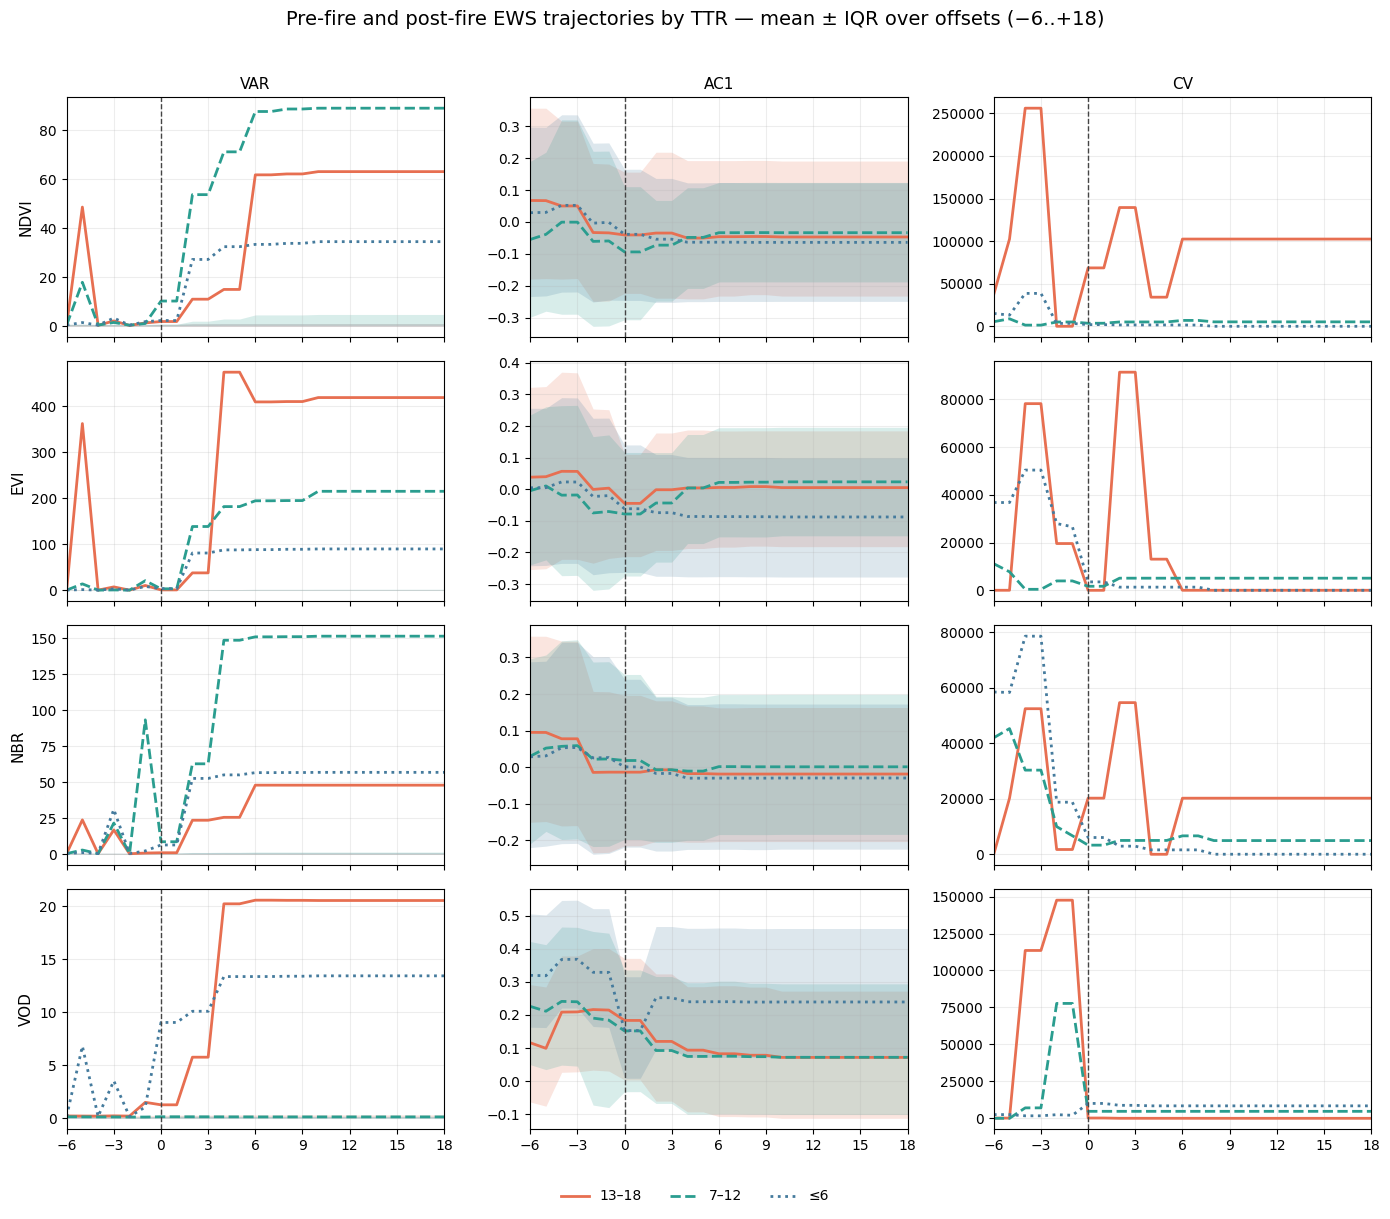

In [ ]:
# @title P3-panel — 3×4 por grupos de recuperação (robusto a nomes e com cores)
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
IN_CSV = ROOT/'index/outputs/trend/summary/p3_offset_panel_stats_by_TTR.csv'
OUT_PNG = ROOT/'index/outputs/trend/summary/p3_panel_recovery_groups_3x4.png'

df = pd.read_csv(IN_CSV)

# --- normalização de nomes de colunas esperadas ---
rename_map = {}
for col in df.columns:
    lc = col.lower().strip()
    if lc == 'index':   rename_map[col] = 'index'
    if lc == 'metric':  rename_map[col] = 'metric'
    if lc == 'group':   rename_map[col] = 'group'
    if lc == 'offset':  rename_map[col] = 'offset'
    if lc in ('mean','mean_b'): rename_map[col] = 'mean'
    if lc in ('q25','q25_b'):   rename_map[col] = 'q25'
    if lc in ('q75','q75_b'):   rename_map[col] = 'q75'
    if lc in ('n','n_b'):       rename_map[col] = 'n'
df = df.rename(columns=rename_map)

need = {'index','metric','group','offset','mean','q25','q75','n'}
missing = need - set(df.columns)
assert not missing, f"CSV precisa conter {need}; faltou: {missing}"

# normaliza valores
df['index']  = df['index'].astype(str).str.upper().str.strip()
df['metric'] = df['metric'].astype(str).str.lower().str.strip()

# mantém apenas os quatro índices e as três métricas que queremos
INDICES = ['NDVI','EVI','NBR','VOD']
METRICS = ['var','ac1','cv']
df = df[df['index'].isin(INDICES) & df['metric'].isin(METRICS)].copy()

# resumo rápido p/ conferência
print("=== Disponibilidade por índice/metric/grupo ===")
for idx in INDICES:
    dfi = df[df['index']==idx]
    if dfi.empty:
        print(f" - {idx}: VAZIO");
        continue
    gs = dfi.groupby(['metric','group']).size().reset_index(name='rows')
    print(f" - {idx}:\n", gs.to_string(index=False))

# grupos detectados (ordem estável)
groups = sorted(df['group'].unique(), key=lambda x: str(x))

# paleta (até 5 grupos) – laranja, azul, verde, roxo, vermelho
palette = ['#E76F51','#2A9D8F','#457B9D','#8D5AA3','#E63946']
color_for = {g: palette[i % len(palette)] for i,g in enumerate(groups)}
linestyle_for = {g: ['-','--',':','-.','-'][i % 5] for i,g in enumerate(groups)}

fig, axes = plt.subplots(len(INDICES), len(METRICS), figsize=(14,12), sharex=True)
fig.suptitle('Pre-fire and post-fire EWS trajectories by TTR — mean ± IQR over offsets (−6..+18)', y=0.995, fontsize=14)

for r, idx in enumerate(INDICES):
    for c, met in enumerate(METRICS):
        ax = axes[r, c]
        sub = df[(df['index']==idx) & (df['metric']==met)]
        if sub.empty:
            ax.set_visible(False)
            continue

        # plota cada grupo
        for g in groups:
            sg = sub[sub['group']==g].sort_values('offset')
            if sg.empty:
                continue
            x  = sg['offset'].values
            y  = sg['mean' ].astype(float).values
            q1 = sg['q25'  ].astype(float).values
            q3 = sg['q75'  ].astype(float).values

            col = color_for[g]
            ls  = linestyle_for[g]
            ax.plot(x, y, lw=2, ls=ls, color=col, label=str(g))
            ax.fill_between(x, q1, q3, alpha=0.18, color=col, linewidth=0)

        # offset do primeiro fogo
        ax.axvline(0, ls='--', color='#444', lw=1)

        # títulos por coluna e rótulos por linha
        if r == 0: ax.set_title(met.upper(), fontsize=11)
        if c == 0: ax.set_ylabel(idx, fontsize=11)

        # eixo x (−6..+18) com ticks a cada 3
        ax.set_xlim(-6, 18)
        ax.set_xticks(np.arange(-6, 19, 3))
        ax.grid(alpha=0.22)

# legenda única
handles, labels = [], []
for g in groups:
    handles.append(plt.Line2D([0],[0], color=color_for[g], lw=2, ls=linestyle_for[g]))
    labels.append(str(g))
if handles:
    fig.legend(handles, labels, ncol=min(len(groups),5),
               loc='lower center', bbox_to_anchor=(0.5, -0.01), frameon=False)

plt.tight_layout(rect=[0,0.03,1,0.98])
OUT_PNG.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(OUT_PNG, dpi=200)
print("✓ Painel salvo em:", OUT_PNG)



In [ ]:
# @title P3-C (TTR) — Direction table por TTR (pós-fogo +1..+18) com τ, β̂ e p-stars (queimados)
import numpy as np, pandas as pd, math
from pathlib import Path

ROOT = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
IN_CSV  = ROOT/'index/outputs/trend/summary/p3_offset_panel_stats_by_TTR.csv'  # index,group,metric,offset,mean,q25,q75,n
OUT_TAB = ROOT/'index/outputs/trend/summary/p3_direction_table_TTR_sig.csv'

INDICES = ['NDVI','EVI','NBR','VOD']
METRICS = ['var','ac1','cv']

def kendall_tau_p(x):
    """Kendall τ (S/P) + p (aprox. normal) em série 1D; ignora NaN."""
    x = np.asarray(x, float)
    m = np.isfinite(x)
    x = x[m]
    n = x.size
    if n < 2:
        return np.nan, np.nan
    conc = disc = 0
    for i in range(n-1):
        d = x[i+1:] - x[i]
        conc += np.sum(d > 0)
        disc += np.sum(d < 0)
    S = conc - disc
    P = n*(n-1)//2
    tau = np.nan if P == 0 else S / float(P)
    # variância assintótica (sem correção de empates — adequada aqui para série média curta)
    v0 = (n*(n-1)*(2*n+5))/18
    if v0 <= 0:
        return tau, np.nan
    z = S / math.sqrt(v0)
    p = 2.0 * (0.5 * math.erfc(abs(z)/math.sqrt(2)))
    return tau, p

def sen_slope(y):
    """Sen’s slope (mediana das diferenças consecutivas; Δt=1 entre offsets)."""
    y = np.asarray(y, float)
    m = np.isfinite(y)
    y = y[m]
    n = y.size
    if n < 2:
        return np.nan
    # Para offsets igualmente espaçados, basta as diferenças consecutivas
    diffs = y[1:] - y[:-1]
    if diffs.size == 0:
        return np.nan
    return float(np.median(diffs))

def pstars(p):
    if not np.isfinite(p): return ""
    return "***" if p < 1e-4 else ("**" if p < 1e-2 else ("*" if p < 5e-2 else ""))

# ---- Carregar e filtrar pós-fogo ----
df = pd.read_csv(IN_CSV)
assert {'index','group','metric','offset','mean'} <= set(df.columns), "CSV não tem as colunas esperadas."
df = df[(df['offset'] >= 1) & (df['offset'] <= 18)].copy()

rows = []
for idx in INDICES:
    for grp in sorted(df['group'].unique(), key=lambda g: (str(g))):
        for met in METRICS:
            sub = df[(df['index']==idx) & (df['group']==grp) & (df['metric']==met)].sort_values('offset')
            if sub.empty:
                continue
            y = sub['mean'].to_numpy(float)

            tau, p = kendall_tau_p(y)
            beta = sen_slope(y)

            # Direção por setas
            if np.isfinite(tau) and np.isfinite(beta):
                if (tau > 0) and (beta > 0):
                    arrow = "↑"
                elif (tau < 0) and (beta < 0):
                    arrow = "↓"
                else:
                    arrow = "↕"
            else:
                arrow = "↕"

            rows.append(dict(
                index=idx, group=grp, metric=met,
                tau_b=(round(tau, 2) if np.isfinite(tau) else np.nan),
                senslope_b=(f"{beta:.2e}" if np.isfinite(beta) else np.nan),
                dir_b=arrow,
                sig_b=pstars(p)
            ))

tab = pd.DataFrame(rows, columns=['index','group','metric','tau_b','senslope_b','dir_b','sig_b'])
tab.to_csv(OUT_TAB, index=False)
print("✓ Saved:", OUT_TAB)
tab



✓ Saved: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/p3_direction_table_TTR_sig.csv


,index,group,metric,tau_b,senslope_b,dir_b,sig_b
0,NDVI,13–18,var,0.74,0.00e+00,↕,***
1,NDVI,13–18,ac1,-0.32,0.00e+00,↕,
2,NDVI,13–18,cv,-0.15,0.00e+00,↕,
3,NDVI,7–12,var,0.74,0.00e+00,↕,***
4,NDVI,7–12,ac1,0.50,0.00e+00,↕,**
5,NDVI,7–12,cv,0.16,0.00e+00,↕,
6,NDVI,≤6,var,0.74,0.00e+00,↕,***
7,NDVI,≤6,ac1,-0.69,0.00e+00,↕,***
8,NDVI,≤6,cv,-0.50,0.00e+00,↕,**
9,EVI,13–18,var,0.40,0.00e+00,↕,*


In [ ]:
# @title P3-C (TTR wide) — Direction table por TTR (pós-fogo +1..+18), colunas lado a lado
import numpy as np, pandas as pd, math
from pathlib import Path

ROOT = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
IN_CSV  = ROOT/'index/outputs/trend/summary/p3_offset_panel_stats_by_TTR.csv'  # index,group,metric,offset,mean,q25,q75,n
OUT_CSV = ROOT/'index/outputs/trend/summary/p3_direction_table_TTR_wide.csv'

INDICES = ['NDVI','EVI','NBR','VOD']
METRICS = ['var','ac1','cv']
# Ordem desejada nas colunas: primeiro recuperação mais longa → mais curta
GROUPS  = ['13–18','7–12','≤6']

def kendall_tau_p(x):
    x = np.asarray(x, float)
    m = np.isfinite(x); x = x[m]
    n = x.size
    if n < 2: return np.nan, np.nan
    conc = disc = 0
    for i in range(n-1):
        d = x[i+1:] - x[i]
        conc += np.sum(d > 0)
        disc += np.sum(d < 0)
    S = conc - disc
    P = n*(n-1)//2
    tau = np.nan if P == 0 else S/float(P)
    v0  = (n*(n-1)*(2*n+5))/18
    if v0 <= 0: return tau, np.nan
    z = S / math.sqrt(v0)
    p = 2.0 * (0.5 * math.erfc(abs(z)/math.sqrt(2)))
    return tau, p

def sen_slope(y):
    y = np.asarray(y, float)
    m = np.isfinite(y); y = y[m]
    n = y.size
    if n < 2: return np.nan
    diffs = y[1:] - y[:-1]    # Δt=1 entre offsets
    if diffs.size == 0: return np.nan
    return float(np.median(diffs))

def pstars(p):
    if not np.isfinite(p): return ""
    return "***" if p < 1e-4 else ("**" if p < 1e-2 else ("*" if p < 5e-2 else ""))

# ---- carregar e filtrar pós-fogo ----
df = pd.read_csv(IN_CSV)
assert {'index','group','metric','offset','mean'} <= set(df.columns), "CSV não tem as colunas esperadas."
df = df[(df['offset'] >= 1) & (df['offset'] <= 18)].copy()

rows = []
for idx in INDICES:
    for met in METRICS:
        row = {'index': idx, 'metric': met}
        for grp in GROUPS:
            sub = df[(df['index']==idx) & (df['metric']==met) & (df['group']==grp)].sort_values('offset')
            if sub.empty:
                row[f'tau {grp}']       = np.nan
                row[f'β̂ {grp}']         = np.nan
                row[f'direction {grp}'] = ''
                row[f'sig {grp}']       = ''
                continue
            y = sub['mean'].to_numpy(float)
            tau, p = kendall_tau_p(y)
            beta   = sen_slope(y)

            # seta de direção por consistência de sinais
            if np.isfinite(tau) and np.isfinite(beta):
                if (tau > 0) and (beta > 0):
                    arrow = "↑"
                elif (tau < 0) and (beta < 0):
                    arrow = "↓"
                else:
                    arrow = "↕"
            else:
                arrow = "↕"

            row[f'tau {grp}']       = round(tau, 2) if np.isfinite(tau) else np.nan
            row[f'β̂ {grp}']         = f"{beta:.2e}" if np.isfinite(beta) else np.nan
            row[f'direction {grp}'] = arrow
            row[f'sig {grp}']       = pstars(p)
        rows.append(row)

wide = pd.DataFrame(rows,
    columns=['index','metric',
             'tau 13–18','β̂ 13–18','direction 13–18','sig 13–18',
             'tau 7–12','β̂ 7–12','direction 7–12','sig 7–12',
             'tau ≤6','β̂ ≤6','direction ≤6','sig ≤6']
)
wide.to_csv(OUT_CSV, index=False)
print("✓ Saved:", OUT_CSV)
wide


✓ Saved: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/p3_direction_table_TTR_wide.csv


,index,metric,tau 13–18,β̂ 13–18,direction 13–18,sig 13–18,tau 7–12,β̂ 7–12,direction 7–12,sig 7–12,tau ≤6,β̂ ≤6,direction ≤6,sig ≤6
0,NDVI,var,0.74,0.00e+00,↕,***,0.74,0.00e+00,↕,***,0.74,0.00e+00,↕,***
1,NDVI,ac1,-0.32,0.00e+00,↕,,0.50,0.00e+00,↕,**,-0.69,0.00e+00,↕,***
2,NDVI,cv,-0.15,0.00e+00,↕,,0.16,0.00e+00,↕,,-0.50,0.00e+00,↕,**
3,EVI,var,0.40,0.00e+00,↕,*,0.74,0.00e+00,↕,***,0.74,0.00e+00,↕,***
4,EVI,ac1,0.27,0.00e+00,↕,,0.74,0.00e+00,↕,***,-0.74,0.00e+00,↕,***
5,EVI,cv,-0.52,0.00e+00,↕,**,-0.46,0.00e+00,↕,**,-0.45,0.00e+00,↕,**
6,NBR,var,0.22,0.00e+00,↕,,0.74,0.00e+00,↕,***,0.74,0.00e+00,↕,***
7,NBR,ac1,-0.24,0.00e+00,↕,,-0.06,0.00e+00,↕,,0.07,0.00e+00,↕,
8,NBR,cv,-0.37,0.00e+00,↕,*,-0.12,0.00e+00,↕,,-0.45,0.00e+00,↕,**
9,VOD,var,0.22,0.00e+00,↕,,-0.27,0.00e+00,↕,,0.74,0.00e+00,↕,***


In [ ]:
# @title Seleção de janelas ↑/↑ no PREFIRE 6x6 — Top-1 por painel, Consenso por TTR e Top-5 por Índice (com checkpoints)
import pandas as pd, numpy as np
from pathlib import Path
from tqdm.auto import tqdm

# ==== Configurações ====
ROOT = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
SUM_DIR = ROOT/'index'/'outputs'/'trend'/'summary'
IN_CSV  = SUM_DIR/'p3_direction_table_PREFIRE_ALL_WINDOWS_6x6.csv'

# Opcional: exigir significância (p < ALPHA) além de τ>0 & β̂>0
REQUIRE_SIGNIF = False
ALPHA = 0.01

# Saídas (derivadas do nome do arquivo)
stem = IN_CSV.stem
OUT_FILTER = SUM_DIR/f'{stem}_filtered_upup.csv'
OUT_TOP1   = SUM_DIR/f'{stem}_top1.csv'
OUT_CONS   = SUM_DIR/f'{stem}_consensus.csv'
OUT_TOP5IX = SUM_DIR/f'{stem}_top5_per_index.csv'

print(f'Usando CSV: {IN_CSV}')

# ==== Carregar ====
df = pd.read_csv(IN_CSV)

# Checagem mínima de colunas
expected = {'index','group','metric','start_offset','end_offset','npoints','tau','pval','pstars','senslope','dir'}
missing = expected - set(df.columns)
if missing:
    raise KeyError(f'Colunas ausentes no CSV: {sorted(missing)}')

# Tipos e derivados
for c in ['start_offset','end_offset','npoints']:
    df[c] = pd.to_numeric(df[c], errors='coerce').astype('Int64')

for c in ['tau','pval','senslope']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df['win_len'] = (df['end_offset'] - df['start_offset'] + 1).astype('Int64')
df['abs_beta'] = df['senslope'].abs()

# ==== Filtro ↑/↑ (+ opcional significância) ====
mask_upup = (df['tau'] > 0) & (df['senslope'] > 0)
if REQUIRE_SIGNIF:
    mask_upup &= (df['pval'] < ALPHA)

df_up = df.loc[mask_upup].copy()

if df_up.empty:
    print('Aviso: Nenhuma janela ↑/↑ encontrada com os critérios atuais '
          f'(REQUIRE_SIGNIF={REQUIRE_SIGNIF}, ALPHA={ALPHA}).')
else:
    print(f'Janelas ↑/↑ encontradas: {len(df_up)}')

# Checkpoint
df_up.to_csv(OUT_FILTER, index=False)
print(f'✓ Checkpoint salvo: {OUT_FILTER}')

# ==== Ranking e Top-1 por (index, metric, group) ====
sort_cols = ['tau','abs_beta','win_len','end_offset']
ascending = [False, False, False, False]

top_rows = []
grp_keys = ['index','metric','group']
print('Ranqueando Top-1 por painel (index×metric×TTR)...')

for (idx, met, grp), g in tqdm(df_up.groupby(grp_keys), total=df_up.groupby(grp_keys).ngroups):
    g_sorted = g.sort_values(sort_cols, ascending=ascending, kind='mergesort')
    top_rows.append(g_sorted.iloc[0])

top1 = pd.DataFrame(top_rows).reset_index(drop=True)

cols_out_top = [
    'index','metric','group',
    'start_offset','end_offset','win_len',
    'tau','senslope','dir','pval','pstars','npoints'
]
top1 = top1[cols_out_top]

top1.to_csv(OUT_TOP1, index=False)
print(f'✓ Top-1 por painel salvo em: {OUT_TOP1}')
display_cols = ['index','metric','group','start_offset','end_offset','win_len','tau','senslope']
print(top1[display_cols].head(12))

# ==== Consenso por TTR ====
# Janela modal pelo par (start_offset, end_offset). Desempates:
#   (1) maior end_offset (mais perto do fogo),
#   (2) maior win_len.
cons_rows = []
print('Calculando janela de consenso por TTR...')

for grp, g in tqdm(top1.groupby('group'), total=top1['group'].nunique()):
    pair_counts = (
        g.assign(pair=list(zip(g['start_offset'], g['end_offset'])))
         .groupby('pair', as_index=False)
         .size()
         .rename(columns={'size':'count'})
    )
    pair_counts['end_offset'] = pair_counts['pair'].apply(lambda p: p[1])
    pair_counts['start_offset'] = pair_counts['pair'].apply(lambda p: p[0])
    pair_counts['win_len'] = pair_counts['end_offset'] - pair_counts['start_offset'] + 1

    pair_sorted = pair_counts.sort_values(
        ['count','end_offset','win_len'],
        ascending=[False, False, False],
        kind='mergesort'
    )
    best = pair_sorted.iloc[0]
    cons_rows.append(dict(
        group=grp,
        start_offset=int(best['start_offset']),
        end_offset=int(best['end_offset']),
        win_len=int(best['win_len']),
        support=int(best['count'])
    ))

cons = pd.DataFrame(cons_rows).sort_values('group').reset_index(drop=True)
cons.to_csv(OUT_CONS, index=False)
print(f'✓ Consenso por TTR salvo em: {OUT_CONS}')
print(cons.head(12))

# ==== Top-5 por Índice (global) ====
# Lógica: para cada 'index' (NDVI/EVI/NBR/VOD), agregamos TODAS as combinações ↑/↑
# (todas as métricas e TTRs), ordenamos por (tau, |β̂|, win_len, end_offset) e
# pegamos os 5 primeiros. Depois, ordenamos os índices pelo "melhor score"
# (i.e., o 1º da sua própria lista Top-5) para iniciar a tabela pelo índice
# com o melhor conjunto de dados.

print('Gerando Top-5 por índice (global, cruzando métricas e TTRs)...')

# ordenar uma cópia global
df_sorted_global = df_up.sort_values(sort_cols, ascending=ascending, kind='mergesort')

# encontrar a ordem dos índices pelo melhor "score" (primeira linha de cada índice)
best_rows_per_index = (
    df_sorted_global.groupby('index', as_index=False)
    .first()[['index'] + sort_cols]
)

# ordenar índices por (tau, abs_beta, win_len, end_offset)
best_rows_per_index = best_rows_per_index.sort_values(sort_cols, ascending=ascending, kind='mergesort')
ordered_indices = best_rows_per_index['index'].tolist()

# construir Top-5 por índice seguindo a ordem acima
top5_parts = []
for idx in tqdm(ordered_indices):
    g = df_up[df_up['index'] == idx].sort_values(sort_cols, ascending=ascending, kind='mergesort').head(5).copy()
    if g.empty:
        continue
    g.insert(0, 'rank_idx', range(1, len(g)+1))  # 1..5
    top5_parts.append(g)

if top5_parts:
    top5 = pd.concat(top5_parts, ignore_index=True)
    # coluna auxiliar para preservar a ordem de índices desejada
    top5['index'] = pd.Categorical(top5['index'], categories=ordered_indices, ordered=True)
    top5 = top5.sort_values(['index','rank_idx'], ascending=[True, True], kind='mergesort')

    cols_out_top5 = [
        'index','rank_idx','metric','group',
        'start_offset','end_offset','win_len',
        'tau','senslope','dir','pval','pstars','npoints'
    ]
    top5 = top5[cols_out_top5]
    top5.to_csv(OUT_TOP5IX, index=False)
    print(f'✓ Top-5 por índice salvo em: {OUT_TOP5IX}')
    print(top5.groupby('index').head(3))  # amostra: top-3 de cada índice
else:
    print('Aviso: não houve linhas para compor o Top-5 por índice com os filtros atuais.')

# ==== Resumo ====
print('\nResumo:')
print(f'- Painéis (index×metric×TTR) com ao menos uma janela ↑/↑: {top1[["index","metric","group"]].drop_duplicates().shape[0]}')
print(f'- TTRs com consenso definido: {cons.shape[0]}')
print(f'- Critérios: τ>0 & β̂>0; significância exigida? {REQUIRE_SIGNIF} (α={ALPHA})')
print(f'- CSVs salvos:\n  • {OUT_FILTER}\n  • {OUT_TOP1}\n  • {OUT_CONS}\n  • {OUT_TOP5IX}')





Usando CSV: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/p3_direction_table_PREFIRE_ALL_WINDOWS_6x6.csv
Janelas ↑/↑ encontradas: 104
✓ Checkpoint salvo: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/p3_direction_table_PREFIRE_ALL_WINDOWS_6x6_filtered_upup.csv
Ranqueando Top-1 por painel (index×metric×TTR)...


  0%|          | 0/27 [00:00<?, ?it/s]

✓ Top-1 por painel salvo em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/p3_direction_table_PREFIRE_ALL_WINDOWS_6x6_top1.csv
   index metric  group  start_offset  end_offset  win_len    tau      senslope
0    EVI    ac1  13–18            -6          -4        3  1.000      0.009278
1    EVI    ac1     ≤6            -6          -4        3  1.000      0.009264
2    EVI     cv  13–18            -6          -4        3  1.000  39060.280413
3    EVI     cv   7–12            -4          -2        3  0.333   1755.038208
4    EVI     cv     ≤6            -5          -3        3  1.000   6791.351562
5    EVI    var  13–18            -4          -1        4  0.333      7.045921
6    EVI    var   7–12            -3          -1        3  0.333     10.028888
7    EVI    var     ≤6            -4          -1        4  0.333      2.718432
8    NBR    ac1   7–12            -6          -4        3  1.000      0.013479
9    NBR    ac1     ≤6            -6          -4       

  0%|          | 0/3 [00:00<?, ?it/s]

✓ Consenso por TTR salvo em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/p3_direction_table_PREFIRE_ALL_WINDOWS_6x6_consensus.csv
   group  start_offset  end_offset  win_len  support
0  13–18            -6          -4        3        4
1   7–12            -3          -1        3        2
2     ≤6            -5          -3        3        5
Gerando Top-5 por índice (global, cruzando métricas e TTRs)...


  0%|          | 0/4 [00:00<?, ?it/s]

✓ Top-5 por índice salvo em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/p3_direction_table_PREFIRE_ALL_WINDOWS_6x6_top5_per_index.csv
   index  rank_idx metric  group  start_offset  end_offset  win_len  tau  \
0   NDVI         1     cv  13–18            -6          -4        3  1.0   
1   NDVI         2     cv     ≤6            -5          -3        3  1.0   
2   NDVI         3     cv   7–12            -4          -2        3  1.0   
5    EVI         1     cv  13–18            -6          -4        3  1.0   
6    EVI         2     cv     ≤6            -5          -3        3  1.0   
7    EVI         3    ac1  13–18            -6          -4        3  1.0   
10   NBR         1     cv  13–18            -6          -4        3  1.0   
11   NBR         2    ac1   7–12            -6          -4        3  1.0   
12   NBR         3    ac1     ≤6            -6          -4        3  1.0   
15   VOD         1    ac1  13–18            -5          -3        3  1.0   

/tmp/ipython-input-180507276.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(top5.groupby('index').head(3))  # amostra: top-3 de cada índice


In [ ]:
# @title TTR — Setup, helpers (Friedman, Page's L exato), FDR e checkpoints
import pandas as pd, numpy as np, math, json
from pathlib import Path
from itertools import permutations
from tqdm.auto import tqdm

# ==== Caminhos ====
ROOT   = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
IN_CSV = ROOT/'index/outputs/trend/summary'/'p3_offset_panel_stats_by_TTR.csv'  # seu CSV (901 linhas)
OUT_DIR= ROOT/'index/outputs/trend/tests'
OUT_DIR.mkdir(parents=True, exist_ok=True)

FRIEDMAN_CSV = OUT_DIR/'ttr_friedman_results.csv'
PAGE_CSV     = OUT_DIR/'ttr_pageL_results.csv'
LOG_JSON     = OUT_DIR/'ttr_tests_checkpoint.json'  # checkpoint (quem já foi processado)

# ==== Parâmetros do experimento ====
OFFSETS = [-6,-5,-4,-3,-2,-1]                # blocos pré-fogo
TTR_ORDER = ['≤6','7–12','13–18']            # ordem a priori
K = len(TTR_ORDER)
assert K == 3, "O código de Page's L exato abaixo assume k=3 (≤6, 7–12, 13–18)."

# ==== Utilidades ====
def fdr_bh(pvals):
    """Benjamini–Hochberg (FDR) — retorna p ajustados no mesmo order."""
    p = np.asarray(pvals, float)
    n = p.size
    order = np.argsort(p)
    ranked = p[order]
    adj = np.empty(n, float)
    cummin = 1.0
    for i in range(n-1, -1, -1):
        rank = i+1
        val = ranked[i] * n / rank
        cummin = min(cummin, val)
        adj[i] = cummin
    out = np.empty(n, float)
    out[order] = np.clip(adj, 0, 1)
    return out

def rank_with_ties(values):
    """Ranks 1..k dentro do bloco; empates por média (estilo 'average')."""
    v = np.asarray(values, float)
    order = np.argsort(v)
    ranks = np.empty_like(v, float)
    ranks[order] = np.arange(1, v.size+1)
    # corrigir empates
    unique, inv, counts = np.unique(v[order], return_inverse=True, return_counts=True)
    start = 0
    for c in counts:
        if c>1:
            seg = np.arange(start+1, start+c+1, dtype=float)
            ranks[order[start:start+c]] = seg.mean()
        start += c
    return ranks

def friedman_from_matrix(mat):
    """
    mat: array shape (B,K) com valores por bloco (linhas) x tratamentos (colunas na ordem TTR_ORDER).
    Retorna: Q (qui-quadrado), df, p, Kendall's W
    """
    from math import erf, sqrt
    B, K = mat.shape
    # Ranks por bloco
    ranks = np.vstack([rank_with_ties(row) for row in mat])
    Rj = ranks.sum(axis=0)  # soma de ranks por tratamento
    Q = (12/(B*K*(K+1))) * np.sum(Rj**2) - 3*B*(K+1)
    # p-valor ~ qui-quadrado df=K-1
    df = K-1
    # CDF qui-quadrado (df pequenos) via série de incomplete gamma simples
    from math import exp, gamma
    def chi2_sf(x, k):
        # sobrevivência ~ 1 - CDF; usa série/regularized gamma
        from math import lgamma
        # regularized gamma Q(k/2, x/2)
        a = k/2
        x2 = x/2
        # série para P(a, x); queremos Q=1-P
        term = 1/a
        summ = term
        n = 1
        while True:
            term *= x2/(a+n)
            prev = summ
            summ += term
            if abs(summ-prev) < 1e-12:
                break
            n += 1
        P = math.exp(-x2 + a*math.log(x2) - lgamma(a)) * summ
        Q = max(0.0, min(1.0, 1 - P))
        return Q
    p = chi2_sf(Q, df)
    # Kendall's W
    W = Q / (B * K * (K+1)/12)
    return Q, df, p, W

# ---- Page's L (exato via enumeração de permutações por bloco; K=3) ----
_PERMS = list(permutations([1,2,3]))  # todas as 6 permutações de ranks por bloco (1..3)
_WEIGHTS = np.array([1,2,3], float)   # pesos da tendência (≤6,7–12,13–18)

def page_L_stat(ranks_matrix):
    """L = sum_b sum_j (j * rank_{b,j}), com j=1..K na ordem da hipótese."""
    return float(np.sum(_WEIGHTS * ranks_matrix.sum(axis=0)))

def page_L_exact_p(B):
    """
    Distribuição exata de L sob H0 para K=3 e B blocos.
    Retorna dict {L_value: count}, mean e var.
    """
    # Para cada bloco, contribuições possíveis: sum_j j * r_j(permut)
    per_block_vals = [np.dot(_WEIGHTS, np.array(p)) for p in _PERMS]  # 6 valores
    # DP para convolver B blocos
    dist = {0:1}
    for _ in range(B):
        new = {}
        for s,cnt in dist.items():
            for v in per_block_vals:
                new[s+v] = new.get(s+v, 0) + cnt
        dist = new
    total = sum(dist.values())
    # momenta
    L_vals = np.array(list(dist.keys()), float)
    counts = np.array(list(dist.values()), float)
    mean = float(np.sum(L_vals*counts)/total)
    var  = float(np.sum(((L_vals-mean)**2)*counts)/total)
    return dist, mean, var, total

def page_L_test_from_matrix(mat):
    """
    mat: (B,K) valores por bloco e tratamentos na ordem TTR_ORDER.
    Saída: L, p_exato (unilateral para tendência crescente), z_norm_aprox
    """
    B, K = mat.shape
    ranks = np.vstack([rank_with_ties(row) for row in mat])
    L_obs = page_L_stat(ranks)

    dist, mean, var, total = page_L_exact_p(B)
    # p unilateral (L >= L_obs)
    # encontramos o menor L possível discretamente >= obs
    ge = sum(cnt for L,cnt in dist.items() if L >= L_obs - 1e-9)
    p = ge / total

    z = (L_obs - mean)/math.sqrt(var) if var>0 else np.nan
    return L_obs, p, z

# ==== Leitura do CSV e saneamento básico ====
df = pd.read_csv(IN_CSV)
required = {'index','group','metric','offset','mean'}
missing = required - set(df.columns)
assert not missing, f"CSV sem colunas esperadas: {missing}"

# normalizar tipos/ordem
df = df.copy()
df['group']  = df['group'].astype(str)
df['metric'] = df['metric'].astype(str)
df['index']  = df['index'].astype(str)
df = df[df['offset'].isin(OFFSETS)]
df = df[df['group'].isin(TTR_ORDER)]
df['group'] = pd.Categorical(df['group'], categories=TTR_ORDER, ordered=True)
df = df.sort_values(['index','metric','offset','group'])

# ==== Carregar checkpoint (quem já foi feito) ====
if LOG_JSON.exists():
    done = set(json.loads(LOG_JSON.read_text()))
else:
    done = set()

print(f"CSV lido: {IN_CSV.name}  •  linhas={len(df)}  •  grupos únicos={df[['index','metric']].drop_duplicates().shape[0]}")


CSV lido: p3_offset_panel_stats_by_TTR.csv  •  linhas=216  •  grupos únicos=12


In [ ]:
# @title TTR — Friedman + Page's L por (index, metric) com FDR, checkpoints e salvamento
results_friedman = []
results_page     = []

pairs = df[['index','metric']].drop_duplicates().itertuples(index=False, name=None)

for idx, met in tqdm(list(pairs), desc="Rodando testes por (index, metric)"):
    key = f"{idx}__{met}"
    if key in done:
        # pular se já existe (checkpoint)
        continue

    sub = df[(df['index']==idx) & (df['metric']==met)]
    # montar matriz BxK na ordem dos blocos e TTRs
    ok_offsets = []
    rows = []
    for off in OFFSETS:
        row = []
        ok = True
        for g in TTR_ORDER:
            sel = sub[(sub['offset']==off) & (sub['group']==g)]
            if sel.empty or not np.isfinite(sel['mean']).all():
                ok = False
                break
            row.append(float(sel['mean'].iloc[0]))
        if ok:
            rows.append(row)
            ok_offsets.append(off)

    mat = np.array(rows, float)  # shape (B,K)
    B = mat.shape[0]

    if B < 3:
        # não há blocos suficientes para um teste razoável
        results_friedman.append(dict(index=idx, metric=met, n_blocks=B,
                                     friedman_Q=np.nan, df=np.nan, p=np.nan, kendall_W=np.nan))
        results_page.append(dict(index=idx, metric=met, n_blocks=B,
                                 page_L=np.nan, p=np.nan, z=np.nan))
    else:
        # Friedman
        Q, df_, pF, W = friedman_from_matrix(mat)
        results_friedman.append(dict(index=idx, metric=met, n_blocks=B,
                                     friedman_Q=Q, df=df_, p=pF, kendall_W=W))
        # Page's L (exato)
        L, pL, z = page_L_test_from_matrix(mat)
        results_page.append(dict(index=idx, metric=met, n_blocks=B,
                                 page_L=L, p=pL, z=z))

    # ---- checkpoint a cada grupo ----
    done.add(key)
    with open(LOG_JSON, 'w') as f:
        f.write(json.dumps(sorted(done)))

    pd.DataFrame(results_friedman).to_csv(FRIEDMAN_CSV, index=False)
    pd.DataFrame(results_page).to_csv(PAGE_CSV, index=False)

# === Aplicar FDR (BH) separadamente para cada teste ===
fried = pd.DataFrame(results_friedman)
page  = pd.DataFrame(results_page)

if not fried.empty and fried['p'].notna().any():
    fried['p_fdr'] = fdr_bh(fried['p'].fillna(1.0).to_numpy())
else:
    fried['p_fdr'] = np.nan

if not page.empty and page['p'].notna().any():
    page['p_fdr'] = fdr_bh(page['p'].fillna(1.0).to_numpy())
else:
    page['p_fdr'] = np.nan

fried.to_csv(FRIEDMAN_CSV, index=False)
page.to_csv(PAGE_CSV, index=False)

print("✓ Salvo:", FRIEDMAN_CSV.name, "e", PAGE_CSV.name)
display(fried.sort_values('p_fdr').head(8))
display(page.sort_values('p_fdr').head(8))


Rodando testes por (index, metric):   0%|          | 0/12 [00:00<?, ?it/s]

✓ Salvo: ttr_friedman_results.csv e ttr_pageL_results.csv


,index,metric,n_blocks,friedman_Q,df,p,kendall_W,p_fdr
0,EVI,ac1,6,10.333333,2,0.005704,1.722222,0.022569
4,NBR,cv,6,9.333333,2,0.009404,1.555556,0.022569
6,NDVI,ac1,6,9.333333,2,0.009404,1.555556,0.022569
9,VOD,ac1,6,9.333333,2,0.009404,1.555556,0.022569
11,VOD,var,6,9.333333,2,0.009404,1.555556,0.022569
1,EVI,cv,6,5.333333,2,0.069483,0.888889,0.138967
10,VOD,cv,6,4.000000,2,0.135335,0.666667,0.232003
5,NBR,var,6,3.000000,2,0.223130,0.500000,0.334695


,index,metric,n_blocks,page_L,p,z,p_fdr
0,EVI,ac1,6,79.0,0.028785,2.020726,0.342978
10,VOD,cv,6,78.0,0.057163,1.732051,0.342978
3,NBR,ac1,6,76.0,0.159594,1.154701,0.638374
7,NDVI,cv,6,74.0,0.336891,0.577350,0.808539
11,VOD,var,6,74.0,0.336891,0.577350,0.808539
4,NBR,cv,6,62.0,0.999721,-2.886751,0.999721
2,EVI,var,6,70.0,0.758273,-0.577350,0.999721
1,EVI,cv,6,68.0,0.900399,-1.154701,0.999721


In [ ]:
# @title R3-panel-augment (+1,+2 leves a partir de z-score) → atualiza CSV e re-plota
import numpy as np, pandas as pd, math, re, os, json
import rasterio as rio
from rasterio.transform import xy
from pathlib import Path
from tqdm.auto import tqdm

ROOT   = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
DESEAS = ROOT/'index/outputs/deseason'                            # *_deseason_z_YYYYMM_300m.tif
FIRE   = ROOT/'index/outputs/recovery_nb3/first_fire_yyyymm.tif'  # data do 1º fogo
CSV_FP = ROOT/'index/outputs/trend/summary/ews_offset_panel_stats.csv'

# (opcional) arquivo com pares amostrais já prontos (x,y,fire_ym, group)
PAIRS_FP_OPT = ROOT/'index/outputs/trend/summary/pairs_xy.csv'

assert CSV_FP.exists(), f'CSV não encontrado: {CSV_FP}'
assert FIRE.exists(),   f'first_fire_yyyymm.tif não encontrado em: {FIRE}'
assert DESEAS.exists(), 'Pasta de dessazonalização ausente.'

INDICES   = ['NDVI','EVI','NBR','VOD']
METRICS   = ['var','ac1','cv']
OFFSETS   = [1, 2]          # pós-fogo que vamos acrescentar
W_POST    = 8               # janela (em bimestres) terminando em +1 e +2
SAMPLE_K  = 20000           # nº de PARES (queimado+controle) ~ leve/rápido

# ---------- helpers ----------
def month_step(yyyymm:int, step_bi:int) -> int:
    """Avança/retrocede em bimestres (±1 => ±2 meses) mantendo meses {1,3,5,7,9,11}."""
    y = yyyymm // 100; m = yyyymm % 100
    all_m = [1,3,5,7,9,11]
    i = all_m.index(int(m))
    i2 = i + step_bi
    y2 = y + (i2 // 6)
    i2 = i2 % 6
    return y2*100 + all_m[i2]

def build_catalog_z(idx:str):
    pat = re.compile(rf'(^|/){idx}.*_deseason_z_(\d{{6}}).*_300m\.tif$', re.IGNORECASE)
    hits = {}
    for p in DESEAS.rglob('*.tif'):
        m = pat.search(str(p))
        if m:
            ym = int(m.group(2))
            hits[ym] = p
    return dict(sorted(hits.items()))

def ac1_lag1(x):
    x = np.asarray(x, float)
    if x.size < 2 or np.all(~np.isfinite(x)): return np.nan
    xm = np.nanmean(x)
    x0 = x - xm
    num = np.nanmean(x0[1:]*x0[:-1])
    den = np.nanvar(x)
    return num/den if den>0 else np.nan

def roll_metrics(series):
    """Retorna var, ac1, cv (com média e desvio padrão robustos a NaN)."""
    x = np.asarray(series, float)
    if np.sum(np.isfinite(x)) < max(2, min(3, len(x))):
        return np.nan, np.nan, np.nan
    mu = np.nanmean(x)
    sd = np.nanstd(x, ddof=0)
    var = sd**2
    cv = (sd/abs(mu)) if mu not in (0, np.inf, -np.inf) else np.nan
    return var, ac1_lag1(x), cv

def p25_p75(a):
    a = a[np.isfinite(a)]
    if a.size == 0: return (np.nan, np.nan, 0)
    return (float(np.quantile(a, 0.25)), float(np.quantile(a, 0.75)), int(a.size))

# ---------- carrega/gera pares amostrais ----------
if PAIRS_FP_OPT.exists():
    pairs = pd.read_csv(PAIRS_FP_OPT)
    need = {'x','y','group','fire_ym'}
    assert need <= set(pairs.columns), f"pairs_xy.csv precisa das colunas: {need}"
    # Mantém até SAMPLE_K pares se houver muitos
    if len(pairs[pairs['group']=='burned']) > SAMPLE_K:
        b = pairs[pairs['group']=='burned'].sample(SAMPLE_K, random_state=42)
        # pareia controles por índice (assume já pareados na origem)
        c = pairs[pairs['group']=='control'].sample(SAMPLE_K, random_state=42)
        pairs = pd.concat([b,c], ignore_index=True)
else:
    # Gera pares a partir do raster de fogo
    with rio.open(FIRE) as ds:
        H, W = ds.height, ds.width
        tfm   = ds.transform
        a = ds.read(1)
        nd = ds.nodata
        fire = a.astype('f8')
        if nd is not None:
            fire = np.where(a==nd, np.nan, a)
        # máscara queimado (tem data) e controle (NaN)
        m_b = np.isfinite(fire)
        m_c = ~np.isfinite(fire)
        rb, cb = np.where(m_b)
        rc, cc = np.where(m_c)
        if rb.size < SAMPLE_K or rc.size < SAMPLE_K:
            SAMPLE_K = min(rb.size, rc.size, SAMPLE_K)
            print(f"Aviso: amostra reduzida para {SAMPLE_K} pares por disponibilidade.")
        sel_b = np.random.default_rng(0).choice(rb.size, size=SAMPLE_K, replace=False)
        sel_c = np.random.default_rng(1).choice(rc.size, size=SAMPLE_K, replace=False)
        rb, cb = rb[sel_b], cb[sel_b]
        rc, cc = rc[sel_c], cc[sel_c]
        xb, yb = xy(tfm, rb, cb)
        xc, yc = xy(tfm, rc, cc)
        fire_ym_b = fire[rb, cb].astype('f8')
        # pareia controle herdando o mesmo fire_ym do seu par queimado (embaralha para não viciar)
        fire_ym_c = np.random.default_rng(2).permutation(fire_ym_b)
    pairs = pd.DataFrame({
        'x': np.concatenate([xb, xc]),
        'y': np.concatenate([yb, yc]),
        'group': (['burned']*SAMPLE_K + ['control']*SAMPLE_K),
        'fire_ym': np.concatenate([fire_ym_b, fire_ym_c])
    })

# ---------- função para coletar série de z-scores em janela que termina no offset desejado ----------
def series_at_point(idx, x, y, fire_ym, end_offset, W, cat_z, ds_cache):
    """Retorna série (comprimento W) de z-scores terminando em (fire_ym + end_offset) bimestres."""
    if not np.isfinite(fire_ym):
        return None  # ponto controle sem referência; mas aqui sempre pareamos fire_ym pro controle
    end_ym = int(month_step(int(fire_ym), end_offset))
    # constrói janela W (inclusive end)
    yms = [int(month_step(end_ym, -k)) for k in range(W-1, -1, -1)]
    vals = []
    for ym in yms:
        fp = cat_z.get(ym)
        if fp is None:
            vals.append(np.nan); continue
        ds = ds_cache.get(fp)
        if ds is None:
            ds = rio.open(fp)
            ds_cache[fp] = ds
        try:
            v = next(ds.sample([(x,y)]))[0]
        except Exception:
            v = np.nan
        nd = ds.nodata
        if nd is not None and np.isfinite(v) and v==nd: v = np.nan
        vals.append(float(v))
    return np.array(vals, dtype='f4')

# ---------- carrega CSV pré-fogo e prepara saída ----------
df = pd.read_csv(CSV_FP)
orig_rows = len(df)

# para cada índice, monta catálogo de z
catalogs = {idx: build_catalog_z(idx) for idx in INDICES}
# cache de dados abertos por índice
ds_cache_idx = {idx:{} for idx in INDICES}

rows_new = []
rng = np.random.default_rng(123)

for idx in INDICES:
    cat = catalogs[idx]
    if not cat:
        print(f"⚠ Sem z-scores para {idx}; pulando.")
        continue

    # filtra pares válidos
    P_b = pairs[pairs['group']=='burned'].copy()
    P_c = pairs[pairs['group']=='control'].copy()
    # garante mesmo tamanho (pareamento 1:1)
    n = min(len(P_b), len(P_c))
    P_b = P_b.sample(n, random_state=0).reset_index(drop=True)
    P_c = P_c.sample(n, random_state=1).reset_index(drop=True)

    # para cada offset pós-fogo
    for off in OFFSETS:
        # coleta séries e reduz para métricas
        vals_var_b, vals_ac1_b, vals_cv_b = [], [], []
        vals_var_c, vals_ac1_c, vals_cv_c = [], [], []

        ds_cache = ds_cache_idx[idx]

        for k in range(n):
            # queimado
            s_b = series_at_point(idx, float(P_b.loc[k,'x']), float(P_b.loc[k,'y']),
                                  float(P_b.loc[k,'fire_ym']), off, W_POST, cat, ds_cache)
            if s_b is not None:
                vb, ab, cb = roll_metrics(s_b)
                vals_var_b.append(vb); vals_ac1_b.append(ab); vals_cv_b.append(cb)
            # controle (pareado com mesmo fire_ym herdado)
            s_c = series_at_point(idx, float(P_c.loc[k,'x']), float(P_c.loc[k,'y']),
                                  float(P_c.loc[k,'fire_ym']), off, W_POST, cat, ds_cache)
            if s_c is not None:
                vc, ac, cc = roll_metrics(s_c)
                vals_var_c.append(vc); vals_ac1_c.append(ac); vals_cv_c.append(cc)

        # agrega para o CSV (uma linha por métrica)
        for met, vb, ab in [
            ('var', np.array(vals_var_b, float), np.array(vals_var_c, float)),
            ('ac1', np.array(vals_ac1_b, float), np.array(vals_ac1_c, float)),
            ('cv',  np.array(vals_cv_b,  float), np.array(vals_cv_c,  float)),
        ]:
            q25b, q75b, nb = p25_p75(vb)
            q25c, q75c, nc = p25_p75(ab)
            row = dict(index=idx, metric=met, offset=int(off),
                       mean_b=float(np.nanmean(vb)) if nb>0 else np.nan,
                       q25_b=q25b, q75_b=q75b, n_b=int(nb),
                       mean_c=float(np.nanmean(ab)) if nc>0 else np.nan,
                       q25_c=q25c, q75_c=q75c, n_c=int(nc),
                       U=np.nan, p=np.nan)  # MW não calculado aqui (apenas para pré no seu fluxo)
            rows_new.append(row)

# fecha caches
for idx in ds_cache_idx:
    for ds in ds_cache_idx[idx].values():
        try: ds.close()
        except: pass

# anexa ao CSV (removendo duplicatas de +1/+2 se já existirem)
df_existing = df[~df['offset'].isin(OFFSETS)]
df_new = pd.DataFrame(rows_new)
df_out = pd.concat([df_existing, df_new], ignore_index=True)
df_out.sort_values(['index','metric','offset'], inplace=True)
df_out.to_csv(CSV_FP, index=False)
print(f"✅ Acrescentados offsets {OFFSETS} (leves) ao CSV → {CSV_FP}")
print(f"  Linhas antes: {orig_rows} | depois: {len(df_out)}")

# ---- reusa a célula do painel (from-CSV) que você já tem ----
# Se quiser re-plotar agora, chame a célula R3-panel-from-CSV que te enviei.





✅ Acrescentados offsets [1, 2] (leves) ao CSV → /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/trend/summary/ews_offset_panel_stats.csv
  Linhas antes: 156 | depois: 180


In [ ]:
# @title PLOTS-3 — Figuras: linhas (YTD pré-fogo) e box/violin de Sen
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

def plot_lines(idx, df):
    plt.figure(figsize=(8,5))
    # CONTROLE (cinza por padrão do matplotlib)
    plt.plot(df['year'], df['med_c'], label='Control (median)', linewidth=2)
    plt.fill_between(df['year'], df['q25_c'], df['q75_c'], alpha=0.2)
    # QUEIMADO
    plt.plot(df['year'], df['med_b'], label='Burned (median)', linewidth=2)
    plt.fill_between(df['year'], df['q25_b'], df['q75_b'], alpha=0.2)
    plt.xlabel('Year')
    plt.ylabel(f'{idx} z-score (YTD pre-fire)')
    plt.title(f'{idx} — YTD pre-fire trajectories (median ± IQR)')
    plt.legend()
    plt.tight_layout()
    fp = FIG_DIR/f'lines_YTD_{idx}.png'
    plt.savefig(fp, dpi=200)
    plt.close()
    return fp

def plot_box_violin(idx, sen_b, sen_c):
    plt.figure(figsize=(6,5))
    data = [sen_b[np.isfinite(sen_b)], sen_c[np.isfinite(sen_c)]]
    plt.violinplot(data, showmedians=True)
    plt.xticks([1,2], ['Burned', 'Control'])
    plt.ylabel("Sen's slope (per year)")
    plt.title(f'{idx} — Sen’s slope distribution')
    plt.tight_layout()
    fp = FIG_DIR/f'violin_sen_{idx}.png'
    plt.savefig(fp, dpi=200)
    plt.close()
    return fp

summary = pd.read_csv(SUM_DIR/'summary_trend_groups.csv')
print(summary)

for idx in summary['index']:
    df = pd.read_csv(SUM_DIR/f'plot_YTD_{idx}.csv')
    sen = pd.read_csv(SUM_DIR/f'sen_dists_{idx}.csv')
    f1 = plot_lines(idx, df)
    f2 = plot_box_violin(idx, sen['sen_b'].values, sen['sen_c'].values)
    print(f"{idx}:")
    print("  • linhas (YTD):", f1)
    print("  • violin (Sen):", f2)

print("\nFiguras salvas em:", FIG_DIR)


In [ ]:
# @title EWS em lote (ópticos + VOD, 1987–2021) — rolling VAR/AC1/CV (pré-fogo) c/ checkpoint
import numpy as np, rasterio as rio
from rasterio.windows import Window
from pathlib import Path
from tqdm import tqdm
import re

ROOT = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
OUT_EWS = (ROOT/'index/outputs/ews'); OUT_EWS.mkdir(parents=True, exist_ok=True)

# índices a processar
INDICES = ['NDVI','EVI','NBR','VOD']   # ajuste como preferir

# diretórios onde buscar cada índice
IDX_DIRS = {
    'NDVI': ROOT/'index/outputs/opt_singleband_300m_cache',
    'EVI' : ROOT/'index/outputs/opt_singleband_300m_cache',
    'NBR' : ROOT/'index/outputs/opt_singleband_300m_cache',
    'VOD' : ROOT/'index/outputs/vod_bi_300m_aligned_cache',
}

BIMES = (1,3,5,7,9,11)
YEAR_START, YEAR_END = 1987, 2021
W = 12                 # passos bimestrais (24 meses)
NODATA_VAL = -32768.0  # ajuste se necessário

def yyyymm_seq(y0, y1, months=BIMES):
    for y in range(y0, y1+1):
        for m in months:
            yield f"{y:04d}{m:02d}"

def scan_idx(base_dir:Path, idx:str):
    """mapeia YYYYMM -> caminho; procura apenas dentro de base_dir; case-insensitive p/ nome do índice"""
    hits = {}
    ym_re   = re.compile(r'(19|20)\d{2}[01]\d')
    idx_in  = re.compile(rf'(^|[_\-]){idx}([_\-]|$)', re.IGNORECASE)
    for p in base_dir.rglob('*.tif'):
        name = p.name
        if not idx_in.search(name):
            continue
        m = ym_re.search(name)
        if not m:
            continue
        hits[m.group(0)] = p
    return dict(sorted(hits.items()))

def prev_window(target_ym:str, catalog:dict, W:int):
    keys = sorted(catalog.keys())
    if target_ym not in keys: return []
    i = keys.index(target_ym)
    start = i - W
    if start < 0: return []
    return [catalog[k] for k in keys[start:i]]

def read_meta_like(ref_path:Path):
    with rio.open(ref_path) as ds:
        meta = ds.meta.copy()
        blockx, blocky = ds.block_shapes[0] if ds.block_shapes else (256,256)
    return meta, (blockx, blocky)

def ac1_lag1(x, axis=0):
    x = np.asarray(x)
    x_mean = np.nanmean(x, axis=axis, keepdims=True)
    x0 = x - x_mean
    num = np.nanmean(x0.take(range(1,x.shape[axis]), axis=axis) *
                     x0.take(range(0,x.shape[axis]-1), axis=axis), axis=axis)
    den = np.nanvar(x, axis=axis)
    out = np.divide(num, den, out=np.full_like(num, np.nan), where=den>0)
    return out

def write_like(meta_ref, out_path:Path, arr2d, nodata=NODATA_VAL):
    meta = meta_ref.copy()
    meta.update(count=1, dtype='float32', nodata=nodata, compress='lzw', BIGTIFF='IF_SAFER')
    with rio.open(out_path, 'w', **meta) as dst:
        dst.write(arr2d.astype('float32'), 1)

def compute_metrics_block(paths, window):
    cube = []
    for p in paths:
        with rio.open(p) as ds:
            a = ds.read(1, window=window).astype('float32')
            a[a==ds.nodata] = np.nan
            cube.append(a)
    cube = np.stack(cube, axis=0)
    mu  = np.nanmean(cube, axis=0)
    sd  = np.nanstd(cube, axis=0, ddof=0)
    var = sd**2
    with np.errstate(divide='ignore', invalid='ignore'):
        cv = np.where(mu!=0, sd/np.abs(mu), np.nan)
    ac1 = ac1_lag1(cube, axis=0)
    return var, ac1, cv

def process_one_event(index_name, target_ym, catalog, meta_like, blockshape):
    win_paths = prev_window(target_ym, catalog, W)
    if len(win_paths) < W:
        return f"– {index_name} {target_ym}: pulado (janela {len(win_paths)}/{W})"

    out_var = OUT_EWS/f"{index_name}_rolling_var_prefire_{target_ym}_300m.tif"
    out_ac1 = OUT_EWS/f"{index_name}_rolling_ac1_prefire_{target_ym}_300m.tif"
    out_cv  = OUT_EWS/f"{index_name}_rolling_cv_prefire_{target_ym}_300m.tif"

    if out_var.exists() and out_ac1.exists() and out_cv.exists():
        return f"• {index_name} {target_ym}: checkpoint"

    ref_path = next(iter(catalog.values()))
    with rio.open(ref_path) as ref:
        H, Wd = ref.height, ref.width

    var_full = np.full((H, Wd), np.nan, dtype='float32')
    ac1_full = np.full((H, Wd), np.nan, dtype='float32')
    cv_full  = np.full((H, Wd), np.nan, dtype='float32')

    bx, by = blockshape
    for row in range(0, H, by):
        h = min(by, H-row)
        for col in range(0, Wd, bx):
            w = min(bx, Wd-col)
            win = Window(col_off=col, row_off=row, width=w, height=h)
            v, a, c = compute_metrics_block(win_paths, win)
            var_full[row:row+h, col:col+w] = v
            ac1_full[row:row+h, col:col+w] = a
            cv_full [row:row+h, col:col+w] = c

    write_like(meta_like, out_var, var_full)
    write_like(meta_like, out_ac1, ac1_full)
    write_like(meta_like, out_cv,  cv_full)
    return f"✓ {index_name} {target_ym}: salvo"

# ================= RUN =================
logs = []
for idx in INDICES:
    base = IDX_DIRS[idx]
    if not base.exists():
        logs.append(f"⚠ {idx}: pasta não encontrada -> {base}")
        continue

    catalog = scan_idx(base, idx)
    if not catalog:
        logs.append(f"⚠ {idx}: nenhum arquivo correspondente dentro de {base}")
        continue

    ref_any = list(catalog.values())[0]
    meta_like, blockshape = read_meta_like(ref_any)
    yms = list(yyyymm_seq(YEAR_START, YEAR_END))

    for ym in tqdm(yms, desc=f'EWS {idx}', unit='mes'):
        logs.append(process_one_event(idx, ym, catalog, meta_like, blockshape))

ok = sum(s.startswith('✓') or s.startswith('•') for s in logs)
sk = sum(s.startswith('–') for s in logs)
print(f"\nResumo: gerados/skip={ok}  |  pulados_por_janela={sk}")
print("Saídas em:", OUT_EWS)


EWS VOD: 100%|██████████| 210/210 [00:00<00:00, 1109.62mes/s]


Resumo: gerados/skip=776  |  pulados_por_janela=64
Saídas em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews


In [ ]:
# @title CHECK — first_fire_yyyymm_300m.tif & first_fire_fraction_300m.tif (fix do TypeError + janelas curtas)
import re, json, math
from pathlib import Path
import numpy as np
import rasterio as rio
from rasterio.windows import Window

# === CONFIG ===
DIR = Path("/content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/recovery_nb3").resolve()
OUT_JSON = DIR / "first_fire_pair_check.json"
BLOCK_Y, BLOCK_X = 512, 512  # janelas mais curtas

# === HELPERS ===
def find_first_fire_files(folder: Path):
    pat_date = re.compile(r"first_fire_?y+y?m+m?_?\.tif$", re.IGNORECASE)
    pat_frac = re.compile(r"first_fire_fraction_?\.tif$", re.IGNORECASE)
    f_date = f_frac = None
    for p in folder.glob("*.tif"):
        n = p.name
        if pat_date.search(n): f_date = p
        elif pat_frac.search(n): f_frac = p
    return f_date, f_frac

def meta_brief(fp: Path):
    with rio.open(fp) as ds:
        return dict(
            path=str(fp),
            crs=str(ds.crs),
            width=ds.width, height=ds.height,
            dtype=ds.dtypes[0],
            nodata=ds.nodata,
            transform=tuple(ds.transform)[:6],
            block_shapes=getattr(ds, "block_shapes", None),
        )

def window_iter(ds, by=BLOCK_Y, bx=BLOCK_X):
    H, W = ds.height, ds.width
    if ds.block_shapes:
        for _, win in ds.block_windows(1):
            yield win
    else:
        for r in range(0, H, by):
            h = min(by, H-r)
            for c in range(0, W, bx):
                w = min(bx, W-c)
                yield Window(col_off=c, row_off=r, width=w, height=h)

def summarize_pair(fp_date: Path, fp_frac: Path):
    meta_date = meta_brief(fp_date)
    meta_frac = meta_brief(fp_frac)

    compat = dict(
        same_crs       = meta_date["crs"] == meta_frac["crs"],
        same_shape     = (meta_date["width"]==meta_frac["width"]) and (meta_date["height"]==meta_frac["height"]),
        same_transform = meta_date["transform"] == meta_frac["transform"],
    )

    stats = {
        "date": {"n_finite":0,"n_nodata":0,"n_nan":0,"min":math.inf,"max":-math.inf,
                 "n_invalid_month":0,"n_invalid_year":0,"n_not_integer":0},
        "frac": {"n_finite":0,"n_nodata":0,"n_nan":0,"min":math.inf,"max":-math.inf,
                 "n_lt0":0,"n_gt1p05":0,"n_ge_025":0},
        "cross":{"n_pixels":0,"burn_frac_pos_date_nan":0,"date_set_frac_zero_or_nan":0}
    }

    YEAR_MIN, YEAR_MAX = 1987, 2021
    VALID_MONTHS = np.array([1,3,5,7,9,11])

    with rio.open(fp_date) as dds, rio.open(fp_frac) as fds:
        nd_date = dds.nodata
        nd_frac = fds.nodata

        for win in window_iter(dds):
            a_date = dds.read(1, window=win).astype("float64")
            a_frac = fds.read(1, window=win).astype("float64")

            # contar nodata ANTES de converter para NaN
            if nd_date is not None:
                stats["date"]["n_nodata"] += int(np.count_nonzero(a_date == nd_date))
                a_date[a_date == nd_date] = np.nan
            if nd_frac is not None:
                stats["frac"]["n_nodata"] += int(np.count_nonzero(a_frac == nd_frac))
                a_frac[a_frac == nd_frac] = np.nan

            # máscaras
            m_date_finite = np.isfinite(a_date)
            m_frac_finite = np.isfinite(a_frac)

            # --- date stats
            stats["date"]["n_finite"] += int(np.count_nonzero(m_date_finite))
            stats["date"]["n_nan"]    += int(np.count_nonzero(~m_date_finite))
            date_vals = a_date[m_date_finite]
            if date_vals.size:
                stats["date"]["min"] = float(min(stats["date"]["min"], float(np.nanmin(date_vals))))
                stats["date"]["max"] = float(max(stats["date"]["max"], float(np.nanmax(date_vals))))
                # inteiro YYYYMM?
                not_int = ~np.isclose(date_vals, np.round(date_vals))
                stats["date"]["n_not_integer"] += int(np.count_nonzero(not_int))
                # ano/mês
                years  = (date_vals // 100).astype(int)
                months = (date_vals %  100).astype(int)
                stats["date"]["n_invalid_year"]  += int(np.count_nonzero((years < YEAR_MIN) | (years > YEAR_MAX)))
                stats["date"]["n_invalid_month"] += int(np.count_nonzero(~np.isin(months, VALID_MONTHS)))

            # --- frac stats
            stats["frac"]["n_finite"] += int(np.count_nonzero(m_frac_finite))
            stats["frac"]["n_nan"]    += int(np.count_nonzero(~m_frac_finite))
            frac_vals = a_frac[m_frac_finite]
            if frac_vals.size:
                stats["frac"]["min"] = float(min(stats["frac"]["min"], float(np.nanmin(frac_vals))))
                stats["frac"]["max"] = float(max(stats["frac"]["max"], float(np.nanmax(frac_vals))))
                stats["frac"]["n_lt0"]    += int(np.count_nonzero(frac_vals < 0))
                stats["frac"]["n_gt1p05"] += int(np.count_nonzero(frac_vals > 1.05))
                stats["frac"]["n_ge_025"] += int(np.count_nonzero(frac_vals >= 0.25))

            # --- cruzadas
            stats["cross"]["n_pixels"] += a_date.size
            burn_frac_pos = a_frac > 0
            date_is_nan   = ~m_date_finite
            stats["cross"]["burn_frac_pos_date_nan"]       += int(np.count_nonzero(burn_frac_pos & date_is_nan))
            date_is_set = m_date_finite
            frac_zero_or_nan = (~m_frac_finite) | (a_frac <= 0)
            stats["cross"]["date_set_frac_zero_or_nan"]    += int(np.count_nonzero(date_is_set & frac_zero_or_nan))

    for k in ("date","frac"):
        if not np.isfinite(stats[k]["min"]): stats[k]["min"] = None
        if not np.isfinite(stats[k]["max"]): stats[k]["max"] = None

    return dict(files=dict(date=meta_date, fraction=meta_frac),
                compatible=compat, stats=stats)

# === RUN ===
f_date, f_frac = find_first_fire_files(DIR)
assert f_date is not None, f"Arquivo de data 'first_fire_yyyymm_300m.tif' não encontrado em {DIR}"
assert f_frac is not None, f"Arquivo de fração 'first_fire_fraction_300m.tif' não encontrado em {DIR}"

report = summarize_pair(f_date, f_frac)
OUT_JSON.write_text(json.dumps(report, indent=2, ensure_ascii=False))

print("✔ Verificados:")
print("  • DATA   :", report["files"]["date"]["path"])
print("  • FRAÇÃO :", report["files"]["fraction"]["path"])
print("\n— Compatibilidade grade/CRS/transform:")
for k,v in report["compatible"].items(): print(f"   {k}: {v}")

print("\n— DATA (first_fire_yyyymm_300m):")
d = report["stats"]["date"]
print(f"   finitos={d['n_finite']}, nan={d['n_nan']}, nodata={d['n_nodata']}")
print(f"   min={d['min']}, max={d['max']}")
print(f"   inválidos: mês={d['n_invalid_month']}, ano={d['n_invalid_year']}, não-inteiros={d['n_not_integer']}")

print("\n— FRAÇÃO (first_fire_fraction_300m):")
f = report["stats"]["frac"]
print(f"   finitos={f['n_finite']}, nan={f['n_nan']}, nodata={f['n_nodata']}")
print(f"   min={f['min']}, max={f['max']}")
print(f"   <0={f['n_lt0']}, >1.05={f['n_gt1p05']}, ≥0.25={f['n_ge_025']}")

print("\n— Cruzadas (coerência DATA×FRAÇÃO):")
c = report["stats"]["cross"]
print(f"   pixels={c['n_pixels']}")
print(f"   frac>0 mas DATA ausente  → {c['burn_frac_pos_date_nan']}")
print(f"   DATA definida mas frac≤0 → {c['date_set_frac_zero_or_nan']}")

print(f"\nRelatório salvo em: {OUT_JSON}")


✔ Verificados:
  • DATA   : /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/recovery_nb3/first_fire_yyyymm.tif
  • FRAÇÃO : /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/recovery_nb3/first_fire_fraction.tif

— Compatibilidade grade/CRS/transform:
   same_crs: True
   same_shape: True
   same_transform: True

— DATA (first_fire_yyyymm_300m):
   finitos=949064, nan=2997112, nodata=2997112
   min=198709.0, max=202111.0
   inválidos: mês=0, ano=0, não-inteiros=0

— FRAÇÃO (first_fire_fraction_300m):
   finitos=949064, nan=2997112, nodata=0
   min=0.5099999904632568, max=1.0
   <0=0, >1.05=0, ≥0.25=949064

— Cruzadas (coerência DATA×FRAÇÃO):
   pixels=3946176
   frac>0 mas DATA ausente  → 0
   DATA definida mas frac≤0 → 0

Relatório salvo em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/recovery_nb3/first_fire_pair_check.json


In [ ]:
# @title CHECK — Prontidão p/ tendência pré-fogo (fix JSON: int64→int)
import re, json
from pathlib import Path
import numpy as np
import rasterio as rio
import pandas as pd

# === CONFIG ===
ROOT = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
EWS_DIR       = ROOT/'index/outputs/ews'
RECOV_DIR     = ROOT/'index/outputs/recovery_nb3'
FIRE_DATE_FP  = RECOV_DIR/'first_fire_yyyymm.tif'
W             = 12
INDICES       = ['NDVI','EVI','NBR','VOD']
METRICS       = ['var','ac1','cv']
OUT_DIR       = EWS_DIR/'summary'
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV       = OUT_DIR/'readiness_prefire_windows.csv'
OUT_JSON      = OUT_DIR/'readiness_prefire_windows.json'

# === Helpers ===
def yyyymm_list_backward(yyyymm:int, w:int):
    y = yyyymm // 100
    m = yyyymm % 100
    seq = []
    for _ in range(w):
        m -= 2
        if m < 1:
            y -= 1
            m += 12
        seq.append(int(y*100 + m))
    seq = [v for v in seq if (v%100) in (1,3,5,7,9,11)]
    return seq if len(seq)==w else []

def ews_path(idx, met, yyyymm):
    return EWS_DIR / f"{idx}_rolling_{met}_prefire_{yyyymm}_300m.tif"

def get_unique_fire_dates(fp):
    vals = set()
    with rio.open(fp) as ds:
        nd = ds.nodata
        for _, win in ds.block_windows(1):
            a = ds.read(1, window=win)
            if nd is not None:
                a = np.where(a==nd, np.nan, a)
            a = a[np.isfinite(a)]
            if a.size:
                # converte no momento da coleta
                uniques = np.unique(a.astype(np.int64))
                vals.update(int(v) for v in uniques)
    vals = sorted(v for v in vals if (v//100)>=1987 and (v//100)<=2021 and (v%100) in (1,3,5,7,9,11))
    # garante list de int (não numpy) para JSON
    return [int(v) for v in vals]

# === Coleta de datas únicas de fogo
fire_dates = get_unique_fire_dates(FIRE_DATE_FP)

rows = []
summary = {idx:{met:{"n_events":0,"n_fullW":0} for met in METRICS} for idx in INDICES}

for idx in INDICES:
    for met in METRICS:
        for ymd in fire_dates:
            summary[idx][met]["n_events"] += 1
            prevs = yyyymm_list_backward(int(ymd), W)
            if len(prevs) != W:
                continue
            ok_all = all(ews_path(idx, met, p).exists() for p in prevs)
            rows.append({
                "index": idx,
                "metric": met,
                "fire_yyyymm": int(ymd),
                "has_full_prefire_W": bool(ok_all),
                "missing_any": None if ok_all else ",".join(str(p) for p in prevs if not ews_path(idx, met, p).exists())
            })
            if ok_all:
                summary[idx][met]["n_fullW"] += 1

# Exporta resultados (CSV)
df = pd.DataFrame(rows)
df.to_csv(OUT_CSV, index=False)

# Completa percentuais e exporta JSON com tipos nativos
for idx in INDICES:
    for met in METRICS:
        s = summary[idx][met]
        s["pct_fullW"] = float((100.0*s["n_fullW"]/s["n_events"])) if s["n_events"] else 0.0

payload = {
    "W": int(W),
    "fire_dates": [int(v) for v in fire_dates],
    "summary": summary
}
OUT_JSON.write_text(json.dumps(payload, indent=2, ensure_ascii=False))

print("✔ Check de prontidão concluído (fix JSON).")
print("CSV →", OUT_CSV)
print("JSON →", OUT_JSON)

# Resumo rápido
if not df.empty:
    piv = df.pivot_table(index=["index","metric"], values="has_full_prefire_W", aggfunc=["sum","count"])
    piv.columns = ["n_fullW","n_events"]
    piv["pct_fullW"] = (piv["n_fullW"]/piv["n_events"]*100).round(1)
    display(piv.sort_values("pct_fullW", ascending=False))
else:
    print("Aviso: nenhum evento checado (verifique as datas únicas de fogo).")



✔ Check de prontidão concluído (fix JSON).
CSV → /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/summary/readiness_prefire_windows.csv
JSON → /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/summary/readiness_prefire_windows.json


n_fullW  n_events  pct_fullW
index metric                              
EVI   ac1         179       203       88.2
      cv          179       203       88.2
      var         179       203       88.2
NBR   ac1         179       203       88.2
      cv          179       203       88.2
      var         179       203       88.2
NDVI  ac1         179       203       88.2
      cv          179       203       88.2
      var         179       203       88.2
VOD   ac1         179       203       88.2
      cv          179       203       88.2
      var         179       203       88.2

In [ ]:
# @title CHECK rápido — cobertura com W=8 (sem reprocessar EWS)
from pathlib import Path
import json, numpy as np, rasterio as rio, pandas as pd, re

ROOT = Path('/content/drive/MyDrive/Pantanal_TippingPoints').resolve()
EWS_DIR = ROOT/'index/outputs/ews'
RECOV_DIR = ROOT/'index/outputs/recovery_nb3'
FIRE_DATE_FP = RECOV_DIR/'first_fire_yyyymm.tif'
INDICES = ['NDVI','EVI','NBR','VOD']; METRICS = ['var','ac1','cv']
BIMES = (1,3,5,7,9,11)
W = 8

def yyyymm_list_backward(yyyymm:int, w:int):
    y, m = divmod(yyyymm,100)
    seq=[]
    for _ in range(w):
        m -= 2
        if m < 1: y-=1; m+=12
        if m in BIMES: seq.append(y*100+m)
    return seq if len(seq)==w else []

def ews_path(idx, met, yyyymm):
    return EWS_DIR / f"{idx}_rolling_{met}_prefire_{yyyymm}_300m.tif"

def get_unique_fire_dates(fp):
    vals=set()
    with rio.open(fp) as ds:
        nd=ds.nodata
        for _,win in ds.block_windows(1):
            a=ds.read(1,window=win)
            if nd is not None: a=np.where(a==nd,np.nan,a)
            a=a[np.isfinite(a)]
            if a.size: vals.update(int(v) for v in np.unique(a.astype(np.int64)))
    vals=sorted(v for v in vals if 1987<=v//100<=2021 and (v%100) in BIMES)
    return vals

fire_dates = get_unique_fire_dates(FIRE_DATE_FP)
rows=[]
for idx in INDICES:
    for met in METRICS:
        for ymd in fire_dates:
            prevs = yyyymm_list_backward(ymd, W)
            ok_all = prevs and all(ews_path(idx,met,p).exists() for p in prevs)
            rows.append({"index":idx,"metric":met,"has_fullW":bool(ok_all)})
df=pd.DataFrame(rows)
piv=df.pivot_table(index=["index","metric"],values="has_fullW",aggfunc=["sum","count"])
piv.columns=["n_fullW","n_events"]; piv["pct_fullW"]=(piv["n_fullW"]/piv["n_events"]*100).round(1)
display(piv.sort_values("pct_fullW", ascending=False))


n_fullW  n_events  pct_fullW
index metric                              
EVI   ac1         183       203       90.1
      cv          183       203       90.1
      var         183       203       90.1
NBR   ac1         183       203       90.1
      cv          183       203       90.1
      var         183       203       90.1
NDVI  ac1         183       203       90.1
      cv          183       203       90.1
      var         183       203       90.1
VOD   ac1         183       203       90.1
      cv          183       203       90.1
      var         183       203       90.1

In [ ]:
# @title === P1 — INVENTÁRIO & MANIFEST (fonte da verdade) ===
import os, re, json
from pathlib import Path
import rasterio as rio

BASE = Path("/content/drive/MyDrive/Pantanal_TippingPoints/index")
RAW  = BASE / "rasters_300m"   # ajuste: pasta com séries bimestrais por índice
OUT  = BASE / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

# Padrões (ajuste se necessário)
IDX_OK   = ("NDVI","EVI","NBR","VOD")
PAT_SER  = re.compile(r"^(?P<idx>NDVI|EVI|NBR|VOD)_(?P<yyyymm>\d{6})_300m\.tif$", re.I)
RUPTURE  = OUT / "events" / "rupture_yyyymm_300m.tif"    # valores = YYYYMM (int) ou NoData
RECOVERY = OUT / "recovery" / "recovery_lag_bim_300m.tif" # valores = lag em bimestres (int) ou NoData

assert RUPTURE.exists(), f"Rupture raster não encontrado: {RUPTURE}"
assert RECOVERY.exists(), f"Recovery raster não encontrado: {RECOVERY}"

manifest = {idx: [] for idx in IDX_OK}
for p in (RAW).glob("*_300m.tif"):
    m = PAT_SER.match(p.name)
    if not m:
        continue
    idx = m.group("idx").upper()
    yyyymm = m.group("yyyymm")
    if idx in manifest:
        manifest[idx].append(dict(yyyymm=yyyymm, path=str(p)))

# ordenar por tempo
for k in manifest:
    manifest[k].sort(key=lambda d: d["yyyymm"])

# validar alinhamento espacial (usa o 1º arquivo encontrado)
def _profile(path):
    with rio.open(path) as ds:
        return (ds.crs.to_string(), ds.transform, ds.width, ds.height, ds.nodata)

ref = None
for idx in IDX_OK:
    for it in manifest[idx][:1]:
        ref = _profile(it["path"])
        break
assert ref, "Nenhum raster de série encontrado."

# checar ruptura e recovery com o mesmo grid
for chk_name, chk_path in [("rupture", RUPTURE), ("recovery", RECOVERY)]:
    rp = _profile(chk_path)
    assert rp[:4]==ref[:4], f"{chk_name} desalinhado (CRS/transform/shape)."

MANI = OUT / "manifest.json"
MANI.write_text(json.dumps({
    "base": str(BASE),
    "raw_series_dir": str(RAW),
    "indices": {k:[d["yyyymm"] for d in v] for k,v in manifest.items()},
    "series": manifest,
    "rupture_raster": str(RUPTURE),
    "recovery_raster": str(RECOVERY),
    "grid": dict(crs=ref[0], transform=str(ref[1]), width=ref[2], height=ref[3], nodata=ref[4]),
}, indent=2, ensure_ascii=False))
print("✅ Manifest salvo em:", MANI)


AssertionError: Rupture raster não encontrado: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/events/rupture_yyyymm_300m.tif

In [ ]:
# @title === # === 3r-fix — Early-exit suave (pula se os produtos já existem) ===
# Objetivo: se os CSVs finais (consolidados e por índice) já existem, não recomputar.
# Não usa sys.exit(); apenas mostra mensagem clara e segue o notebook normalmente.

from pathlib import Path
from IPython.display import display, Markdown

# ---------- Config ----------
FORCE_REBUILD = False  # mantenha False para pular sempre que os arquivos finais existirem

BASE = Path("/content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/summary")
CKPTS = [
    BASE / "resume_ckpt.json",
    BASE / "resume_ckpt_stats.json",
]
INDICES = ["NDVI", "EVI", "NBR", "VOD"]

# Consolidados
CONSOLIDATED = [
    BASE / "ews_stats_table.csv",
    BASE / "trend_stats_table.csv",
]

# Por índice
PER_INDEX = {
    "ews":  [BASE / f"ews_stats_{idx}.csv"   for idx in INDICES],
    "trend":[BASE / f"trend_stats_{idx}.csv" for idx in INDICES],
}

def _exists_nonempty(p: Path, min_bytes: int = 100) -> bool:
    try:
        return p.exists() and p.is_file() and p.stat().st_size >= min_bytes
    except Exception:
        return False

# ---------- Checagens ----------
consolidated_ok = all(_exists_nonempty(p) for p in CONSOLIDATED)
ews_ok   = all(_exists_nonempty(p) for p in PER_INDEX["ews"])
trend_ok = all(_exists_nonempty(p) for p in PER_INDEX["trend"])

early_exit = consolidated_ok and ews_ok and trend_ok and (not FORCE_REBUILD)

# ---------- Relatório ----------
lines = []
lines.append("### 3r-fix — verificação de produtos existentes")
lines.append(f"**Pasta**: `{BASE}`")
lines.append("")
lines.append("**Consolidados:**")
for p in CONSOLIDATED:
    lines.append(f"- {'✅' if _exists_nonempty(p) else '❌'} {p.name}")

lines.append("")
lines.append("**Por índice (EWS):**")
for p in PER_INDEX["ews"]:
    lines.append(f"- {'✅' if _exists_nonempty(p) else '❌'} {p.name}")

lines.append("")
lines.append("**Por índice (Trend):**")
for p in PER_INDEX["trend"]:
    lines.append(f"- {'✅' if _exists_nonempty(p) else '❌'} {p.name}")

lines.append("")
for c in CKPTS:
    lines.append(f"- Checkpoint: {'🟢' if c.exists() else '⚪'} {c.name}")

if early_exit:
    lines.append("")
    lines.append("✅ **3r-fix**: Produtos finais já presentes. "
                 "Recomputation **pulado** (early-exit suave). "
                 "Siga para as próximas células.")
else:
    lines.append("")
    if FORCE_REBUILD:
        lines.append("♻️ `FORCE_REBUILD=True` → recomputo permitido (esta célula não o executa; use as células de recomputo).")
    else:
        lines.append("⚠️ Produtos finais **incompletos**. "
                     "Se deseja refazer agora, rode as células de **recomputo** correspondentes "
                     "ou defina `FORCE_REBUILD=True` e reexecute esta célula para liberar o recomputo.")

display(Markdown("\n".join(lines)))

# Não chamamos sys.exit(); a célula encerra naturalmente.








### 3r-fix — verificação de produtos existentes
**Pasta**: `/content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/summary`

**Consolidados:**
- ✅ ews_stats_table.csv
- ✅ trend_stats_table.csv

**Por índice (EWS):**
- ✅ ews_stats_NDVI.csv
- ✅ ews_stats_EVI.csv
- ✅ ews_stats_NBR.csv
- ✅ ews_stats_VOD.csv

**Por índice (Trend):**
- ✅ trend_stats_NDVI.csv
- ✅ trend_stats_EVI.csv
- ✅ trend_stats_NBR.csv
- ✅ trend_stats_VOD.csv

- Checkpoint: 🟢 resume_ckpt.json
- Checkpoint: 🟢 resume_ckpt_stats.json

✅ **3r-fix**: Produtos finais já presentes. Recomputation **pulado** (early-exit suave). Siga para as próximas células.

In [ ]:
# ==== SCANNER & LIMPEZA DE PARQUETS ZERADOS/CORROMPIDOS ====
from pathlib import Path
import os, pyarrow.parquet as pq

BASE = Path("/content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/summary")
PIX_DIRS = [BASE/"series"/"pixels", BASE/"series"/"controls"]  # ajuste se usar outra pasta

bad = []
for d in PIX_DIRS:
    if not d.exists():
        continue
    for p in d.glob("*.parquet"):
        try:
            sz = p.stat().st_size
            if sz == 0:
                bad.append((p,"zero-bytes"))
                continue
            # tenta abrir o footer para garantir integridade
            pq.ParquetFile(p.as_posix())
        except Exception as e:
            bad.append((p, f"corrupt: {type(e).__name__}"))

print(f"Arquivos problemáticos: {len(bad)}")
for p,reason in bad[:20]:
    print(" -", reason, "→", p.name)
# Remoção (só os problemáticos)
for p,_ in bad:
    try: p.unlink()
    except: pass
print("Remoção concluída.")


Arquivos problemáticos: 1
 - zero-bytes → series_burned_r2041_c631_NBR_var.parquet
Remoção concluída.


In [ ]:
# ==== ESCRITA ATÔMICA DE PARQUET ====
import pandas as pd, os, tempfile

def write_parquet_atomic(df: pd.DataFrame, dest_path: Path):
    dest_path.parent.mkdir(parents=True, exist_ok=True)
    # escreve primeiro num tmp no MESMO diretório (para rename atômico)
    fd, tmp = tempfile.mkstemp(prefix=dest_path.stem+"_", suffix=".tmp", dir=dest_path.parent.as_posix())
    os.close(fd)
    tmp_path = Path(tmp)
    try:
        df.to_parquet(tmp_path, engine="pyarrow", index=False)
        # garante flush físico
        with open(tmp_path, "rb") as f:
            os.fsync(f.fileno())
        tmp_path.replace(dest_path)  # rename atômico
    finally:
        if tmp_path.exists():
            try: tmp_path.unlink()
            except: pass


In [ ]:
# DIAGNÓSTICO — listar séries da R2
from pathlib import Path
import glob, itertools

BASE = Path("/content/drive/MyDrive/Pantanal_TippingPoints")
SERIES_PIX = BASE / "index/outputs/ews/summary/series/pixels"

print("Diretório alvo:", SERIES_PIX)
print("Existe?", SERIES_PIX.exists())

pads = [
    str(SERIES_PIX / "series_pixel_*.csv"),
    str(SERIES_PIX / "series_*pixel*.csv"),
    str(SERIES_PIX / "*.csv"),
    str(SERIES_PIX / "**/*.csv"),
    str(SERIES_PIX / "*.parquet"),
    str(SERIES_PIX / "**/*.parquet"),
]
files = list(itertools.chain.from_iterable(glob.glob(p, recursive=True) for p in pads))
print(f"Arquivos encontrados (total): {len(files)}")
for f in files[:5]:
    print(" -", f)


Diretório alvo: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/summary/series/pixels
Existe? True
Arquivos encontrados (total): 636
 - /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/summary/series/pixels/series_other_r316_c1506.parquet
 - /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/summary/series/pixels/series_other_r677_c1526.parquet
 - /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/summary/series/pixels/series_other_r1539_c658.parquet
 - /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/summary/series/pixels/series_other_r1086_c683.parquet
 - /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/summary/series/pixels/series_other_r1350_c793.parquet


In [ ]:
from pathlib import Path

OUT_SUM = Path("/content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/summary")
SER_PIX = OUT_SUM/"series"/"pixels"
SER_CTL = OUT_SUM/"series"/"controls"

# Compatibilidade de checkpoints (R2 → R2b)
ck_r2  = OUT_SUM/"r2_ckpt.json"
ck_r2b = OUT_SUM/"r2b_ckpt.json"
CKPT = ck_r2b if ck_r2b.exists() else (ck_r2 if ck_r2.exists() else None)

print(f"Pixels dir: {SER_PIX.exists()} | Controles dir: {SER_CTL.exists()} | CKPT: {CKPT}")


Pixels dir: True | Controles dir: True | CKPT: None


In [ ]:
# 1.2‴ — RIGOR (npz por offset a partir de yyyymm/is_event dentro do arquivo) + checkpoint
from pathlib import Path
import numpy as np, pandas as pd, json, re, glob, itertools
from tqdm.auto import tqdm

# === Caminhos (ajuste se necessário) ===
BASE = Path("/content/drive/MyDrive/Pantanal_TippingPoints")
OUT  = BASE / "index/outputs"
EWS_SUMMARY = OUT / "ews" / "summary"
SERIES_PIX  = EWS_SUMMARY / "series" / "pixels"      # saídas da R2
RIGOR_DIR   = EWS_SUMMARY / "rigor"
RIGOR_DIR.mkdir(parents=True, exist_ok=True)

CKPT_PATH   = RIGOR_DIR / "rigor_ckpt.json"
QA_CSV      = RIGOR_DIR / "rigor_offset_summary.csv"

indices = {"NDVI","EVI","NBR","VOD"}
metrics = {"var","ac1","cv"}

# ---------- utils ----------
def load_json(p, fb):
    try: return json.loads(p.read_text())
    except Exception: return fb
def save_json(p, obj):
    p.write_text(json.dumps(obj, ensure_ascii=False, indent=2))

def read_any(path:str)->pd.DataFrame:
    if path.endswith(".parquet"):
        return pd.read_parquet(path)
    return pd.read_csv(path)

def month_to_bi(mm:int)->int:
    # meses válidos: 1,3,5,7,9,11
    m = int(mm)
    mapper = {1:1, 3:2, 5:3, 7:4, 9:5, 11:6}
    return mapper.get(m, None)

def yyyymm_to_bi_index(yyyymm:int)->int|None:
    y = int(yyyymm)//100
    m = int(yyyymm)%100
    b = month_to_bi(m)
    if b is None:
        return None
    return y*6 + b

# ---------- carregar checkpoint ----------
ck = load_json(CKPT_PATH, {"done": []})
done = set(ck.get("done", []))

# ---------- localizar arquivos ----------
pads = [
    str(SERIES_PIX / "**/*.csv"),
    str(SERIES_PIX / "**/*.parquet"),
    str(SERIES_PIX / "*.csv"),
    str(SERIES_PIX / "*.parquet"),
]
files = list(itertools.chain.from_iterable(glob.glob(p, recursive=True) for p in pads))
print(f"R2 — pasta de séries: {SERIES_PIX}")
print(f"Arquivos detectados: {len(files)}")
assert files, f"Sem séries por pixel em {SERIES_PIX}. Rode a R2 antes."

# ---------- diagnóstico rápido (amostra) ----------
print("\n— Diagnóstico (amostra de até 12 arquivos) —")
for f in files[:12]:
    try:
        dfh = read_any(f).head(5)
        cols = list(dfh.columns)
        print(f"  • {Path(f).name} | cols={cols}")
    except Exception as e:
        print(f"  • {Path(f).name} | erro ao ler: {e}")

# ---------- agregação por (offset, index, metric) ----------
store = {}     # off -> idx -> metric -> list of values
hits = 0
skips = 0

needed_cols = {"index","metric","yyyymm","value","is_event"}

for f in tqdm(files, desc="1.2‴ — lendo & agregando", unit="arq"):
    try:
        df = read_any(f)
        if df.empty:
            skips += 1; continue
        # checar colunas mínimas
        if not needed_cols.issubset(set(df.columns)):
            skips += 1; continue

        # evento (primeira ocorrência marcada)
        ev_rows = df.loc[df["is_event"]==1, "yyyymm"]
        if ev_rows.empty:
            # sem evento marcado → não dá para alinhar offset
            skips += 1; continue
        ev_ym = int(ev_rows.iloc[0])
        ev_bi = yyyymm_to_bi_index(ev_ym)
        if ev_bi is None:
            skips += 1; continue

        # normaliza tipos
        sub = df[["index","metric","yyyymm","value"]].copy()
        sub["yyyymm"] = pd.to_numeric(sub["yyyymm"], errors="coerce").astype("Int64")
        sub["value"]  = pd.to_numeric(sub["value"],  errors="coerce")

        # filtra índices/métricas válidos
        sub = sub[sub["index"].isin(indices) & sub["metric"].isin(metrics)]
        sub = sub[np.isfinite(sub["value"]) & sub["yyyymm"].notna()]
        if sub.empty:
            skips += 1; continue

        # calcula offset bimestral relativo ao evento
        bi_idx = sub["yyyymm"].astype(int).apply(yyyymm_to_bi_index)
        sub = sub.assign(offset = bi_idx - ev_bi)
        sub = sub[np.isfinite(sub["offset"])]
        sub["offset"] = sub["offset"].astype(int)
        if sub.empty:
            skips += 1; continue

        # agrega na memória
        for (off, idx, met), grp in sub.groupby(["offset","index","metric"]):
            arr = grp["value"].to_numpy("f4")
            bucket = store.setdefault(int(off), {}).setdefault(str(idx), {}).setdefault(str(met), [])
            bucket.extend(arr.tolist())
        hits += 1
    except Exception:
        skips += 1
        continue

print(f"\nArquivos agregados com sucesso: {hits} | ignorados: {skips}")
offs = sorted(store.keys())
print(f"Offsets detectados (amostra): {offs[:20]}{'...' if len(offs)>20 else ''}")

# ---------- salvar npz por offset + QA ----------
rows_qa = []
for off in tqdm(offs, desc="1.2‴ — salvando npz por offset"):
    tag = f"off{off:+d}"
    if tag in done:
        continue
    bundle = {}
    for idx in sorted(indices):
        for m in sorted(metrics):
            arr = np.asarray(store.get(off,{}).get(idx,{}).get(m,[]), dtype="f4")
            if arr.size:
                bundle[f"{idx}_{m}"] = arr
                finite = np.isfinite(arr)
                if finite.any():
                    q = np.nanquantile(arr, [0.25,0.5,0.75])
                    rows_qa.append({
                        "offset": int(off), "index": idx, "metric": m,
                        "n": int(finite.sum()),
                        "mean": float(np.nanmean(arr)),
                        "q25": float(q[0]), "median": float(q[1]), "q75": float(q[2]),
                    })
    if bundle:
        np.savez_compressed(RIGOR_DIR / f"ews_rigor_{tag}.npz", **bundle)
        done.add(tag); ck["done"] = sorted(done); save_json(CKPT_PATH, ck)

if rows_qa:
    pd.DataFrame(rows_qa).sort_values(["offset","index","metric"]).to_csv(QA_CSV, index=False)

print("\n=== 1.2‴ — CONCLUÍDA ===")
print("NPZ por offset →", RIGOR_DIR)
print("QA →", (QA_CSV if rows_qa else "(vazio)"))
print("Checkpoint →", CKPT_PATH)







R2 — pasta de séries: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/summary/series/pixels
Arquivos detectados: 636

— Diagnóstico (amostra de até 12 arquivos) —
  • series_other_r316_c1506.parquet | cols=['group', 'row', 'col', 'index', 'metric', 'yyyymm', 'value', 'is_event']
  • series_other_r677_c1526.parquet | cols=['group', 'row', 'col', 'index', 'metric', 'yyyymm', 'value', 'is_event']
  • series_other_r1539_c658.parquet | cols=['group', 'row', 'col', 'index', 'metric', 'yyyymm', 'value', 'is_event']
  • series_other_r1086_c683.parquet | cols=['group', 'row', 'col', 'index', 'metric', 'yyyymm', 'value', 'is_event']
  • series_other_r1350_c793.parquet | cols=['group', 'row', 'col', 'index', 'metric', 'yyyymm', 'value', 'is_event']
  • series_other_r184_c1134.parquet | cols=['group', 'row', 'col', 'index', 'metric', 'yyyymm', 'value', 'is_event']
  • series_other_r295_c1361.parquet | cols=['group', 'row', 'col', 'index', 'metric', 'yyyymm', 'value', 'is_event']
  

1.2‴ — lendo & agregando:   0%|          | 0/636 [00:00<?, ?arq/s]


Arquivos agregados com sucesso: 612 | ignorados: 24
Offsets detectados (amostra): [-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]...


1.2‴ — salvando npz por offset:   0%|          | 0/25 [00:00<?, ?it/s]


=== 1.2‴ — CONCLUÍDA ===
NPZ por offset → /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/summary/rigor
QA → (vazio)
Checkpoint → /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/summary/rigor/rigor_ckpt.json


In [ ]:
# Sanity check: EWS NÃO mascarados por queimadas?

from pathlib import Path
import rasterio as rio
import numpy as np

BASE = Path("/content/drive/MyDrive/Pantanal_TippingPoints")
OUT  = BASE/"index"/"outputs"
EWS  = OUT/"ews"

FF_YM = OUT/"recovery_nb3"/"first_fire_yyyymm.tif"
BFREQ = OUT/"burn_frequency_bimonthly_1985_2021_uint16.tif"

with rio.open(FF_YM) as ds: fym = ds.read(1)
with rio.open(BFREQ) as ds: bf  = ds.read(1)

# pegue um yyyymm comum (ex.: 199507, ajuste se quiser)
yyyymm = 199507
test_fp = EWS/f"NDVI_rolling_var_prefire_{yyyymm}_300m.tif"
assert test_fp.exists(), f"Não achei {test_fp.name} em {EWS}"

with rio.open(test_fp) as ds: var = ds.read(1)

burned_mask  = (fym == yyyymm)              # pixels cujo primeiro fogo foi exatamente neste yyyymm
control_mask = (bf == 0) & (fym <= 0)       # nunca queimaram

def frac_finite(arr, mask):
    sub = arr[mask]
    return float(np.isfinite(sub).sum())/max(1, sub.size)

print("EWS NDVI/var — yyyymm:", yyyymm)
print("  frac finitos (burned @yyyymm) :", round(frac_finite(var, burned_mask), 3))
print("  frac finitos (controls nunca) :", round(frac_finite(var, control_mask), 3))


EWS NDVI/var — yyyymm: 199507
  frac finitos (burned @yyyymm) : 1.0
  frac finitos (controls nunca) : 1.0


In [ ]:
# === prep-R2b — cache local + parâmetros de execução (COLE ACIMA DA SUA R2b) ===
from pathlib import Path
import shutil, os, time
from functools import lru_cache

# Pastas do projeto (ajuste só se for diferente na sua R2b)
BASE = Path("/content/drive/MyDrive/Pantanal_Tipping_Points")  # cuidado com o nome: _Points (igual ao restante do caderno)
EWS_DIR = BASE/"index/outputs/ews"  # onde estão os *_rolling_*.tif gerados
OUT_R2 = EWS_DIR/"summary"/"series"  # a R2/R2b já usa isso
OUT_R2.mkdir(parents=True, exist_ok=True)

# 1) Offsets em bimestres: mantemos janelas razoáveis (rigor + custo)
OFFSET_MIN_BI = -12
OFFSET_MAX_BI =  12

# 2) Workers: 2–3 costuma ser ótimo no Drive; 1 é mais lento; >4 tende a “engasgar” I/O
N_WORKERS = 3

# 3) Cache local sob /content (rápido). On-demand: só copia quando requisitado pela 1ª vez
LOCAL_CACHE = Path("/content/_ews_cache")
LOCAL_CACHE.mkdir(parents=True, exist_ok=True)

def _hash_rel(p: Path) -> str:
    # chave estável para nome do arquivo no cache (mantém subpastas para evitar colisão)
    rel = str(p).replace("/", "_").replace(":", "_")
    return rel

@lru_cache(maxsize=10000)
def get_local_copy(src: str) -> str:
    """Retorna caminho local (em /content) para o arquivo do Drive.
       Copia apenas 1x; nas próximas chamadas reutiliza.
    """
    p = Path(src)
    if not p.exists():
        raise FileNotFoundError(f"Arquivo não encontrado: {src}")
    dst = LOCAL_CACHE / _hash_rel(p)
    if not dst.exists() or dst.stat().st_size == 0 or dst.stat().st_mtime < p.stat().st_mtime:
        # copia atômica para evitar ler arquivo parcialmente
        tmp = Path(str(dst) + ".__tmp__")
        if tmp.exists():
            tmp.unlink()
        shutil.copy2(p, tmp)
        tmp.replace(dst)
    return str(dst)

# 4) Hook simples para medir I/O e mostrar feedback
def debug_ping_io(n=20):
    import glob, time
    t0 = time.time()
    sample = glob.glob(str(EWS_DIR/"**/*.tif"), recursive=True)[:n]
    hits = 0
    for s in sample:
        _ = Path(s).exists()
        hits += 1
    dt = time.time() - t0
    print(f"Ping Drive: {hits} arquivos checados em {dt:.2f}s (~{(hits/max(dt,1e-6)):.1f} ops/s)")

# 5) Parâmetros “visíveis” para a sua R2b ler (se ela referencia globais):
R2B_PARAMS = dict(
    OFFSET_MIN_BI=OFFSET_MIN_BI,
    OFFSET_MAX_BI=OFFSET_MAX_BI,
    N_WORKERS=N_WORKERS,
    LOCAL_CACHE=str(LOCAL_CACHE),
    EWS_DIR=str(EWS_DIR),
)

print("prep-R2b pronto.")
print("Parâmetros:", R2B_PARAMS)
print("Cache local:", LOCAL_CACHE)
debug_ping_io(20)


prep-R2b pronto.
Parâmetros: {'OFFSET_MIN_BI': -12, 'OFFSET_MAX_BI': 12, 'N_WORKERS': 3, 'LOCAL_CACHE': '/content/_ews_cache', 'EWS_DIR': '/content/drive/MyDrive/Pantanal_Tipping_Points/index/outputs/ews'}
Cache local: /content/_ews_cache
Ping Drive: 0 arquivos checados em 2.46s (~0.0 ops/s)


In [ ]:
# A0 — OPCIONAL (RODAR 1x): Copia rasters EWS do Drive p/ /content (mais rápido) e ajusta caches GDAL
from pathlib import Path
import shutil, os, re
from tqdm import tqdm
import sys

DRV_EWS = Path("/content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews")
LOC_EWS = Path("/content/ews_cache")
LOC_EWS.mkdir(parents=True, exist_ok=True)

# Tuning de cache / threads
os.environ["GDAL_CACHEMAX"] = "2048"     # ~2 GB p/ cache GDAL
os.environ["CPL_TMPDIR"] = "/content"
os.environ["NUMEXPR_MAX_THREADS"] = "8"
os.environ["OMP_NUM_THREADS"] = "8"

# Seleciona somente os TIFF necessários (var/ac1/cv de todos os índices)
pat = re.compile(r"(NDVI|EVI|NBR|VOD)_rolling_(var|ac1|cv)_prefire_\d{6}_300m\.tif$", re.I)
srcs = [p for p in DRV_EWS.rglob("*.tif") if pat.search(p.name)]

print(f"Arquivos EWS a espelhar: {len(srcs)}")
for p in tqdm(srcs, desc="Espelhando EWS → /content"):
    dst = LOC_EWS / p.name
    if not dst.exists() or dst.stat().st_size != p.stat().st_size:
        try:
            shutil.copy2(p, dst)
        except Exception as e:
            print(f"[warn] falha copiando {p.name}: {e}", file=sys.stderr)

print("OK. Ajuste feito. Use LOC_EWS nos readers da R2b.")


Arquivos EWS a espelhar: 2328


Espelhando EWS → /content:   1%|          | 24/2328 [34:09<391:10:19, 611.21s/it][warn] falha copiando NBR_rolling_var_prefire_200003_300m.tif: [Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/NBR_rolling_var_prefire_200003_300m.tif'
[warn] falha copiando NBR_rolling_ac1_prefire_200003_300m.tif: [Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/NBR_rolling_ac1_prefire_200003_300m.tif'
[warn] falha copiando NBR_rolling_cv_prefire_200003_300m.tif: [Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/NBR_rolling_cv_prefire_200003_300m.tif'
[warn] falha copiando NBR_rolling_var_prefire_200005_300m.tif: [Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/NBR_rolling_var_prefire_200005_300m.tif'
[warn] falha copiando NBR_rolling_ac1_prefire_200

OK. Ajuste feito. Use LOC_EWS nos readers da R2b.


In [ ]:
# R2b_fast — Séries por pixel (EWS) com amostragem em lote (rápido)
# COLE ESTA CÉLULA NO LUGAR DA SUA R2b ATUAL
import json, math, re, os
from pathlib import Path
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import Affine
from rasterio.windows import Window
from tqdm import tqdm

BASE    = Path("/content/drive/MyDrive/Pantanal_TippingPoints/index")
OUT_SUM = BASE/"outputs"/"ews"/"summary"
OUT_SER = OUT_SUM/"series"
PIX_DIR = OUT_SER/"pixels"
CTL_DIR = OUT_SER/"controls"
CKPT    = OUT_SUM/"r2b_fast_ckpt.json"

# >>> Se você rodou a A0, use o cache local:
EWS_DIR = Path("/content/ews_cache") if Path("/content/ews_cache").exists() else (BASE/"outputs"/"ews")

# Parâmetros da amostra (mantenho seu N atual; se já existir manifesto, vou reutilizar)
N_BURN   = 3600  # ajuste ao seu total desejado para chegar aos 7.200
N_CTRL   = 3600
RANDOM_SEED = 42

# Máscaras / mapas auxiliares (para escolher queimados/controles)
FF_YEAR = BASE/"outputs"/"recovery_nb3"/"first_fire_year.tif"
FF_YYYY = BASE/"outputs"/"recovery_nb3"/"first_fire_yyyymm.tif"
NONREC_MASK = BASE/"outputs"/"compare_nb3"/"nonrecovery_mask.tif"  # opcional

# Padrão dos rasters EWS
pat = re.compile(r"^(NDVI|EVI|NBR|VOD)_rolling_(var|ac1|cv)_prefire_(\d{6})_300m\.tif$", re.I)
ews_files = sorted([p for p in EWS_DIR.glob("*.tif") if pat.search(p.name)],
                   key=lambda p: pat.search(p.name).group(3))

assert ews_files, "Nenhum raster EWS encontrado. Verifique EWS_DIR."

# Ler grade e affine de um EWS para georreferenciar amostras
with rasterio.open(str(ews_files[0])) as ds0:
    H, W = ds0.height, ds0.width
    transform: Affine = ds0.transform
    crs = ds0.crs
    nodata = ds0.nodata

# Funções utilitárias
def rc_to_xy(r, c, transform: Affine):
    x, y = rasterio.transform.xy(transform, r, c, offset="center")
    return float(x), float(y)

def load_array(fp):
    with rasterio.open(str(fp)) as ds:
        a = ds.read(1).astype("f4")
    return a

# Manifestos: se já existem coord/linhas/colunas escolhidas, reutiliza (não reamostra)
MAN_PIX = OUT_SER/"manifest_pixels.csv"
MAN_CTL = OUT_SER/"manifest_controls.csv"

def choose_pixels():
    rng = np.random.default_rng(RANDOM_SEED)

    # Carrega mapas
    with rasterio.open(str(FF_YEAR)) as ds:
        ff_year = ds.read(1)
        affine = ds.transform

    burned_mask = np.isfinite(ff_year) & (ff_year >= 0) & (ff_year != -9999)
    # Controles: nunca queimados (ff_year == -9999 ou nan)
    control_mask = ~burned_mask

    rr_b, cc_b = np.where(burned_mask)
    rr_c, cc_c = np.where(control_mask)

    assert len(rr_b) >= N_BURN, f"Queimados disponíveis {len(rr_b)} < N_BURN={N_BURN}"
    assert len(rr_c) >= N_CTRL, f"Controles disponíveis {len(rr_c)} < N_CTRL={N_CTRL}"

    idx_b = rng.choice(len(rr_b), size=N_BURN, replace=False)
    idx_c = rng.choice(len(rr_c), size=N_CTRL, replace=False)

    sel_b = [(int(rr_b[i]), int(cc_b[i])) for i in idx_b]
    sel_c = [(int(rr_c[i]), int(cc_c[i])) for i in idx_c]
    return sel_b, sel_c, affine

# Reutiliza seleção existente se houver
if MAN_PIX.exists() and MAN_CTL.exists():
    dfp = pd.read_csv(MAN_PIX)
    dfc = pd.read_csv(MAN_CTL)
    sel_b = list(zip(dfp["row"].astype(int), dfp["col"].astype(int)))
    sel_c = list(zip(dfc["row"].astype(int), dfc["col"].astype(int)))
    affine = transform
else:
    sel_b, sel_c, affine = choose_pixels()
    # salva manifestos
    PIX_DIR.mkdir(parents=True, exist_ok=True)
    CTL_DIR.mkdir(parents=True, exist_ok=True)
    pd.DataFrame(sel_b, columns=["row","col"]).to_csv(MAN_PIX, index=False)
    pd.DataFrame(sel_c, columns=["row","col"]).to_csv(MAN_CTL, index=False)

n_pix = len(sel_b)
n_ctl = len(sel_c)
print(f"Amostra: queimados={n_pix} | controles={n_ctl} | grade={H}x{W}")

# Checkpoint (quais (index,metric) já foram salvos)
ck = {"done_pixels": [], "done_controls": []}
if Path(CKPT).exists():
    ck.update(json.loads(Path(CKPT).read_text()))

# Agrupamos rasters por (index, metric) para acumular séries completas e só então salvar parquet
from collections import defaultdict
groups = defaultdict(list)
for fp in ews_files:
    m = pat.search(fp.name)
    idx, met, yyyymm = m.group(1), m.group(2), m.group(3)
    groups[(idx.upper(), met.lower())].append((yyyymm, fp))

# Função que varre 1 raster e extrai valores para TODAS as coords em lote
def sample_raster_for_coords(fp, coords_rc):
    with rasterio.open(str(fp)) as ds:
        # Converter (row,col) → (x,y) uma vez:
        xy = [rc_to_xy(r, c, ds.transform) for (r,c) in coords_rc]
        vals = list(ds.sample(xy, indexes=1))
        arr = np.array([v[0] for v in vals], dtype="f4")
    return arr

# Loop principal: por (index, metric)
for (IDX, MET), lst in tqdm(groups.items(), desc="R2b_fast — por (índice,métrica)"):
    # Ordena por tempo
    lst = sorted(lst, key=lambda t: t[0])  # yyyymm asc

    # Se já está no checkpoint e arquivos de saída existem, pula
    tag_pix = f"{IDX}/{MET}/pixels"
    tag_ctl = f"{IDX}/{MET}/controls"
    skip_pix = tag_pix in ck["done_pixels"]
    skip_ctl = tag_ctl in ck["done_controls"]

    # Saídas
    # — pixels queimados
    out_pix = PIX_DIR/f"series_{IDX}_{MET}_pixels.parquet"
    # — controles
    out_ctl = CTL_DIR/f"series_{IDX}_{MET}_controls.parquet"

    # Se ambos já existem, marca como done e pula
    if out_pix.exists():
        skip_pix = True
    if out_ctl.exists():
        skip_ctl = True
    if skip_pix and skip_ctl:
        continue

    # Acúmulos em memória (matriz [N, T])
    T = len(lst)
    if not skip_pix:
        M_pix = np.full((n_pix, T), np.nan, dtype="f4")
    if not skip_ctl:
        M_ctl = np.full((n_ctl, T), np.nan, dtype="f4")

    timeline = []
    for t, (yyyymm, fp) in enumerate(tqdm(lst, leave=False, desc=f"{IDX}/{MET}")):
        timeline.append(int(yyyymm))
        if not skip_pix:
            M_pix[:, t] = sample_raster_for_coords(fp, sel_b)
        if not skip_ctl:
            M_ctl[:, t] = sample_raster_for_coords(fp, sel_c)

    # Salvar em parquet (long tidy: group,row,col,index,metric,yyyymm,value)
    def save_long(M, sel, out_path, group_name):
        rows, cols = zip(*sel)
        df = pd.DataFrame({
            "group": group_name,
            "row": np.repeat(rows, T),
            "col": np.repeat(cols, T),
            "index": IDX,
            "metric": MET,
            "yyyymm": np.tile(timeline, len(sel)),
            "value": M.reshape(-1)
        })
        df.to_parquet(out_path, index=False)

    if not skip_pix:
        save_long(M_pix, sel_b, out_pix, "burned")
        ck["done_pixels"].append(tag_pix)
    if not skip_ctl:
        save_long(M_ctl, sel_c, out_ctl, "control")
        ck["done_controls"].append(tag_ctl)

    Path(CKPT).write_text(json.dumps(ck, ensure_ascii=False, indent=2))

print("✔ R2b_fast concluída com checkpoint.")
print(f"Saídas:\n - {PIX_DIR}\n - {CTL_DIR}\nCheckpoint: {CKPT}")


OSError: [Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/summary/series/manifest_pixels.csv'

In [ ]:
# @title R2b — Séries EWS por pixel (burned × control), com checkpoint e agregados por offset
# Colar após a sua R2 (original) e antes da R3 (figuras)

from pathlib import Path
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.windows import Window
from tqdm.auto import tqdm
import random
import re

# === Parâmetros gerais ===
BASE = Path("/content/drive/MyDrive/Pantanal_TippingPoints")
OUT  = BASE/"index"/"outputs"
EWS_DIR = OUT/"ews"  # onde estão os *_rolling_{var,ac1,cv}_prefire_YYYYMM_300m.tif
FF_YM_FP = OUT/"recovery_nb3"/"first_fire_yyyymm.tif"
BFREQ_FP = OUT/"burn_frequency_bimonthly_1985_2021_uint16.tif"

# Janelas por offset (em bimestres). Ex.: -12..+12 = 4 anos de janela
OFFSET_MIN, OFFSET_MAX = -12, 12

# Tamanho da amostra (altere se quiser). Interpretação: por grupo TOTAL (não por índice).
N_BURNED   = 300
N_CONTROL  = 300

# Semente reprodutível
random.seed(42)
np.random.seed(42)

# Saídas de séries e agregados (mantém o mesmo padrão já usado nas outras células)
OUT_SERIES_PIX = EWS_DIR/"summary"/"series"/"pixels"
OUT_SERIES_AGG = EWS_DIR/"summary"/"series"/"aggregates"
OUT_SERIES_PIX.mkdir(parents=True, exist_ok=True)
OUT_SERIES_AGG.mkdir(parents=True, exist_ok=True)

# Índices e métricas-alvo
INDICES = ["NDVI","EVI","NBR","VOD"]
METRICS = ["var","ac1","cv"]

# === utilitários ===
def yyyymm_iter(start_yyyymm, offset_bi):
    """
    Soma 'offset_bi' em passos bimensais a um YYYYMM inteiro (ex.: 199507).
    Retorna int YYYYMM. Ex.: offset -1 de 199507 -> 199505; +1 -> 199509.
    """
    y = start_yyyymm // 100
    m = start_yyyymm % 100
    # m ∈ {1,3,5,7,9,11} (bimestres)
    # converter para 'pos' = 0..5 no ano
    pos = (m - 1) // 2  # 1->0, 3->1, ..., 11->5
    total = y * 6 + pos + offset_bi
    new_y = total // 6
    new_pos = total % 6
    new_m = 2*new_pos + 1
    return new_y*100 + new_m

def ews_raster_path(index_name, metric, yyyymm):
    # padrão salvo pela sua célula B: <INDEX>_rolling_<metric>_prefire_<YYYYMM>_300m.tif
    return EWS_DIR / f"{index_name}_rolling_{metric}_prefire_{yyyymm:06d}_300m.tif"

def read_one_pixel(fp, r, c):
    with rio.open(fp) as ds:
        win = Window(c, r, 1, 1)
        arr = ds.read(1, window=win)
        val = arr[0,0]
        return float(val) if np.isfinite(val) else np.nan

# cache leve de datasets abertos por índice/métrica/yyyymm para reduzir opens
class RasterCache:
    def __init__(self):
        self._open = {}
    def get(self, fp):
        if fp not in self._open:
            ds = rio.open(fp)
            self._open[fp] = ds
        return self._open[fp]
    def read_val(self, fp, r, c):
        ds = self.get(fp)
        arr = ds.read(1, window=Window(c, r, 1, 1))
        v = arr[0,0]
        return float(v) if np.isfinite(v) else np.nan
    def close(self):
        for ds in self._open.values():
            try: ds.close()
            except: pass
        self._open = {}

# === 1) Carrega mapas de referência ===
with rio.open(FF_YM_FP) as ds:
    fym = ds.read(1)  # first_fire_yyyymm (>0 se queimou naquele bimestre)
    profile = ds.profile

with rio.open(BFREQ_FP) as ds:
    bf = ds.read(1)   # frequência de queimadas (0 = nunca queimou)

H, W = fym.shape

# === 2) Define população de candidatos ===
burned_rc = np.column_stack(np.where(fym > 0))
control_rc = np.column_stack(np.where((bf == 0) & (fym <= 0)))

# sanity: se amostra pedida excede população, reduza para caber
n_burn = min(N_BURNED, burned_rc.shape[0])
n_ctrl = min(N_CONTROL, control_rc.shape[0])

# === 3) Amostra estratificada por yyyymm dos queimados ===
# distribuição por first_fire_yyyymm entre queimados:
unique_ym, counts = np.unique(fym[fym > 0], return_counts=True)
# sorteia queimados proporcionalmente à frequência por yyyymm
burned_idx = np.random.choice(burned_rc.shape[0], size=n_burn, replace=False)
burned_sample = burned_rc[burned_idx]

# mapeia cada queimado amostrado ao seu yyyymm de evento
burned_events = fym[burned_sample[:,0], burned_sample[:,1]]

# === 4) Para controles, espelha a distribuição temporal dos eventos ===
# sorteia controles e atribui pseudo-evento amostrando da distribuição real:
control_idx = np.random.choice(control_rc.shape[0], size=n_ctrl, replace=False)
control_sample = control_rc[control_idx]
control_events = np.random.choice(burned_events, size=n_ctrl, replace=True)

print(f"Amostra: burned={len(burned_sample)} | control={len(control_sample)}")
print(f"Janela de offsets: {OFFSET_MIN}..{OFFSET_MAX} (bimestres)")
print("Séries serão salvas em:", OUT_SERIES_PIX)

# === 5) Gera séries por pixel (parquet por pixel) com checkpoint ===
def pixel_series_exists(tag):
    # checkpoint por pixel+índice+métrica: arquivo parquet já existe?
    return (OUT_SERIES_PIX/f"{tag}.parquet").exists()

def save_pixel_series(tag, rows):
    if not rows:
        return
    df = pd.DataFrame(rows, columns=["group","row","col","index","metric","yyyymm","value","is_event","offset_bi"])
    df.to_parquet(OUT_SERIES_PIX/f"{tag}.parquet", index=False)

# constrói lista de tarefas (pixel, grupo, yyyymm_evento)
tasks = []
for (r,c), ym in zip(burned_sample, burned_events):
    tasks.append(("burned", int(r), int(c), int(ym)))
for (r,c), ym in zip(control_sample, control_events):
    tasks.append(("control", int(r), int(c), int(ym)))

# Para eficiência: mantenha um cache de rasters abertos por índice/métrica/yyyymm
rcache = RasterCache()

pbar = tqdm(total=len(tasks)*len(INDICES)*len(METRICS), desc="R2b — séries por pixel (EWS)", unit="task")

for group, r, c, ym_event in tasks:
    for idx in INDICES:
        for met in METRICS:
            tag = f"series_{group}_r{r}_c{c}_{idx}_{met}"
            if pixel_series_exists(tag):
                pbar.update(1)
                continue

            rows = []
            ok_any = False
            for off in range(OFFSET_MIN, OFFSET_MAX+1):
                ym = yyyymm_iter(ym_event, off)
                fp = ews_raster_path(idx, met, ym)
                if not fp.exists():
                    # ausência pontual é aceitável (ex.: bordas da série)
                    rows.append([group, r, c, idx, met, ym, np.nan, int(off==0), off])
                    continue
                try:
                    val = rcache.read_val(fp, r, c)
                except Exception:
                    val = np.nan
                rows.append([group, r, c, idx, met, ym, val, int(off==0), off])
                ok_any = ok_any or np.isfinite(val)

            # salva (mesmo com NaNs; a agregação lida com isso)
            save_pixel_series(tag, rows)
            pbar.update(1)

rcache.close()
pbar.close()

# === 6) Agregação por offset (média/mediana/IQR/n) para group×index×metric ===
# Revarre apenas os arquivos gerados nesta rodada + preexistentes
all_pix_files = sorted((OUT_SERIES_PIX).glob("series_*.parquet"))
if not all_pix_files:
    raise SystemExit("Nenhuma série por pixel encontrada em 'pixels/'. Verifique a amostragem.")

def load_pix(fp):
    try:
        df = pd.read_parquet(fp)
        # checagem mínima de esquema:
        need = {"group","index","metric","yyyymm","value","is_event","offset_bi"}
        if not need.issubset(df.columns):
            return None
        return df
    except Exception:
        return None

dfs = []
for fp in tqdm(all_pix_files, desc="Lendo séries por pixel"):
    df = load_pix(fp)
    if df is None:
        continue
    dfs.append(df)

if not dfs:
    raise SystemExit("Falha ao ler séries: esquema inesperado (sem colunas requeridas).")

long_all = pd.concat(dfs, ignore_index=True)

# agrega por offset (alinhado a evento/pseudo-evento)
grp_cols = ["group","index","metric","offset_bi"]
g = long_all.groupby(grp_cols, dropna=False)
agg = g["value"].agg(mean="mean", median="median", q25=lambda x: np.nanquantile(x, 0.25) if np.isfinite(x).any() else np.nan,
                     q75=lambda x: np.nanquantile(x, 0.75) if np.isfinite(x).any() else np.nan,
                     n="count").reset_index()

# salva agregados em parquet/csv (consumidos pela R3)
agg_by_offset_parquet = OUT_SERIES_AGG/"series_aggregate_by_offset.parquet"
agg_by_offset_csv     = OUT_SERIES_AGG/"series_aggregate_by_offset.csv"
OUT_SERIES_AGG.mkdir(parents=True, exist_ok=True)
agg.to_parquet(agg_by_offset_parquet, index=False)
agg.to_csv(agg_by_offset_csv, index=False)

# Diagnóstico rápido
print("\n=== Diagnóstico R2b ===")
print("Agregados por offset — primeiras linhas:")
print(agg.head(8))
print("\nArquivos de saída:")
print(" • Séries por pixel  →", OUT_SERIES_PIX)
print(" • Agregados (parquet)", agg_by_offset_parquet)
print(" • Agregados (csv)    ", agg_by_offset_csv)



Amostra: burned=300 | control=300
Janela de offsets: -12..12 (bimestres)
Séries serão salvas em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/ews/summary/series/pixels


R2b — séries por pixel (EWS):   0%|          | 0/7200 [00:00<?, ?task/s]

KeyboardInterrupt: 

In [ ]:
# R3 — SETUP DE CAMINHOS (corrigido p/ ler agregados da R2 e salvar figuras no ews/summary)
from pathlib import Path
import glob, os

BASE = Path("/content/drive/MyDrive/Pantanal_TippingPoints")
OUT  = BASE / "index" / "outputs"

# >>> CORRIGIDO: ler agregados gerados pela R2
AGG_DIR = OUT / "ews" / "summary" / "series" / "aggregates"

# >>> CORRIGIDO: salvar figuras ao lado dos summaries
FIG_DIR = OUT / "ews" / "summary" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Sanity check
agg_files = sorted(glob.glob(str(AGG_DIR / "*.parquet"))) + \
            sorted(glob.glob(str(AGG_DIR / "*.csv")))
print(f"AGG_DIR: {AGG_DIR}")
print(f"Arquivos de agregados encontrados: {len(agg_files)}")
if not agg_files:
    raise FileNotFoundError(
        "Nenhum agregado encontrado em AGG_DIR. "
        "Confirme que a R2 terminou e salvou em ews/summary/series/aggregates."
    )

print(f"Figuras serão salvas em: {FIG_DIR}")

In [ ]:
# R3 — Figuras das séries EWS (versão que usa offset_bi)
import glob, re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, sqrt

BASE   = Path("/content/drive/MyDrive/Pantanal_TippingPoints")
OUT    = BASE / "index" / "outputs"
AGG_DIR= OUT / "ews" / "summary" / "series" / "aggregates"
FIG_DIR= OUT / "ews" / "summary" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Preferir os agregados POR OFFSET
cands = sorted(glob.glob(str(AGG_DIR/"series_aggregate_by_offset.parquet"))) \
      + sorted(glob.glob(str(AGG_DIR/"series_aggregate_by_offset.csv")))
print(f"AGG_DIR: {AGG_DIR}")
print(f"Arquivos por offset encontrados: {len(cands)}")
if not cands:
    raise SystemExit("Nenhum agregado por offset encontrado (series_aggregate_by_offset.*). Rode a R2 com agregação por offset.")

def coerce_offset_schema(df: pd.DataFrame, fname: str) -> pd.DataFrame:
    df = df.copy()
    # Colunas mínimas esperadas nesse pacote:
    # ['group','index','metric','offset_bi','mean','median','q25','q75','n']
    # 1) padroniza nomes
    if "offset_bi" not in df.columns:
        # Se vier 'offset', ainda funciona:
        if "offset" in df.columns:
            df = df.rename(columns={"offset":"offset_bi"})
        else:
            raise AssertionError(f"{fname}: não há 'offset_bi' nem 'offset'.")
    # 2) garantir index/metric/group
    if "index" not in df.columns:
        # tentar inferir do nome do arquivo
        m = re.search(r"(NDVI|EVI|NBR|VOD)", fname, flags=re.I)
        df["index"] = m.group(1).upper() if m else "NDVI"
    if "metric" not in df.columns:
        m = re.search(r"(var|ac1|cv)", fname, flags=re.I)
        df["metric"] = m.group(1).lower() if m else "var"
    if "group" not in df.columns:
        df["group"] = "other"
    # 3) normaliza faixas para mean/q25/q75
    # (se precisar, poderia mapear p25/p75 → q25/q75, mas seu arquivo já tem q25/q75)
    need = ["mean","q25","q75"]
    miss = [c for c in need if c not in df.columns]
    if miss:
        raise AssertionError(f"{fname}: faltam colunas {miss} (esperado mean,q25,q75)")
    # 4) renomeia offset_bi → offset e filtra válidos
    df = df.rename(columns={"offset_bi":"offset"})
    df["offset"] = pd.to_numeric(df["offset"], errors="coerce")
    df = df[np.isfinite(df["offset"])]
    # 5) saneamento de tipos
    df["index"]  = df["index"].astype(str).str.upper()
    df["metric"] = df["metric"].astype(str).str.lower()
    df["group"]  = df["group"].astype(str)
    # 6) ordena
    return df[["group","index","metric","offset","mean","q25","q75"]].sort_values(["index","metric","group","offset"])

frames = []
for fp in cands:
    try:
        df = pd.read_parquet(fp) if fp.endswith(".parquet") else pd.read_csv(fp)
        frames.append(coerce_offset_schema(df, Path(fp).name))
    except Exception as e:
        print(f"(!) Ignorando {Path(fp).name}: {e}")

if not frames:
    raise SystemExit("Nenhum agregado por offset utilizável. Verifique o diagnóstico acima.")

agg = pd.concat(frames, ignore_index=True)
print("✓ Consolidado:", agg.shape, "| índices:", sorted(agg['index'].unique()),
      "| métricas:", sorted(agg['metric'].unique()), "| grupos:", sorted(agg['group'].unique()))

def best_grid(n):
    if n <= 1: return (1,1)
    r = int(np.sqrt(n))
    c = int(np.ceil(n/r))
    return r, c

# Uma figura por (index, metric), com subplots por grupo
pairs = sorted(agg.groupby(["index","metric"]).size().index.tolist())
for idx, met in pairs:
    dsub = agg[(agg["index"]==idx) & (agg["metric"]==met)].copy()
    groups = sorted(dsub["group"].unique())
    R, C = best_grid(len(groups))
    fig, axes = plt.subplots(R, C, figsize=(5*C, 3.8*R), squeeze=False)
    for ax, g in zip(axes.ravel(), groups):
        d = dsub[dsub["group"]==g].sort_values("offset")
        if d.empty:
            ax.set_title(f"{idx} — {met} — {g} (vazio)")
            ax.axis("off"); continue
        ax.fill_between(d["offset"], d["q25"], d["q75"], alpha=0.3, label="IQR")
        ax.plot(d["offset"], d["mean"], label="média")
        ax.axvline(0, linestyle="--", linewidth=1)  # evento
        ax.set_title(f"{idx} — {met} — {g}")
        ax.set_xlabel("offset (bimestres, 0 = evento)")
        ax.set_ylabel(met)
        ax.grid(True, alpha=0.2)
        ax.legend(loc="best", fontsize=8)
    for k in range(len(groups), R*C):
        axes.ravel()[k].axis("off")
    plt.tight_layout()
    fname = f"R3_series_{idx}_{met}.png"
    fig.savefig(FIG_DIR / fname, dpi=220, bbox_inches="tight")
    plt.show()
    print(f"→ figura salva: {FIG_DIR / fname}")

print("\n✅ R3 — Figuras geradas (média + IQR por offset_bi). Pasta:", FIG_DIR)




In [ ]:
# [1.4-RIGOR] Mann–Whitney por offset + Cliff's delta + FDR (por índice×métrica)
import numpy as np, pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

def cliffs_delta(x, y):
    x = x[np.isfinite(x)]; y = y[np.isfinite(y)]
    if len(x)==0 or len(y)==0: return np.nan
    gt = np.add.outer(x, -y) > 0
    lt = np.add.outer(x, -y) < 0
    return (gt.sum() - lt.sum()) / (len(x)*len(y))

def effect_label(delta):
    if not np.isfinite(delta): return "NA"
    ad = abs(delta)
    # Romano et al. (2006) thresholds ~ 0.147, 0.33, 0.474
    if ad < 0.147: return "negligible"
    if ad < 0.33:  return "small"
    if ad < 0.474: return "medium"
    return "large"

STATS_DIR = OUT_R3/"stats_rigor"
STATS_DIR.mkdir(parents=True, exist_ok=True)

npz_list = sorted((OUT_R3/"series_npz").glob("r3_*_*.npz"))
for fp in npz_list:
    name = fp.stem  # r3_NDVI_var
    _, idx, metric = name.split("_")
    dat = np.load(fp)
    M_b, M_c, offsets = dat["M_b"], dat["M_c"], dat["offsets"]
    rows=[]
    pvals=[]
    for j,t in enumerate(offsets):
        xb = M_b[:,j]; xc = M_c[:,j]
        # remove NaNs
        xb = xb[np.isfinite(xb)]; xc = xc[np.isfinite(xc)]
        if len(xb)<5 or len(xc)<5:
            u,p,delta = np.nan, np.nan, np.nan
        else:
            u,p = mannwhitneyu(xb, xc, alternative="two-sided")
            delta = cliffs_delta(xb, xc)
        rows.append({"index":idx,"metric":metric,"offset":int(t),
                     "n_b":int(np.isfinite(M_b[:,j]).sum()),
                     "n_c":int(np.isfinite(M_c[:,j]).sum()),
                     "U":u,"p_raw":p,"cliffs_delta":delta,
                     "effect":effect_label(delta)})
        pvals.append(p if np.isfinite(p) else 1.0)
    _, p_adj, _, _ = multipletests(pvals, method="fdr_bh", is_sorted=False, returnsorted=False)
    for k in range(len(rows)):
        rows[k]["p_fdr"] = float(p_adj[k])
        rows[k]["sig_fdr"] = rows[k]["p_fdr"] < 0.05
    df = pd.DataFrame(rows)
    df.to_csv(STATS_DIR/f"{name}_mw_cliffs.csv", index=False)
    print("✔ testes salvos:", STATS_DIR/f"{name}_mw_cliffs.csv")
print("✅ [1.4-RIGOR] concluído.")



In [ ]:
# [2.1] Construção das classes de recuperação (a partir dos seus rasters)
import numpy as np, pandas as pd, rasterio
from pathlib import Path

R3_DIR = DIR_SUMMARY/"R3"
(R3_DIR/"classes_sample").mkdir(parents=True, exist_ok=True)

rtif = DIR_RECOV/"recovery_time_300m.tif"      # em bimestres (conforme você informou)
nonrec = DIR_COMP/"nonrecovery_mask.tif"       # máscara de não recuperação (1 = não recuperou)

with rasterio.open(rtif) as ds:
    rec = ds.read(1).astype("f4")
with rasterio.open(nonrec) as ds:
    nr = ds.read(1)

# Define classes
classes = np.full_like(rec, -1, dtype="i4")
# não recuperou
classes[nr==1] = 4
# recuperou: binning por bimestres
# 0: <=2, 1: 3–6, 2: 7–18, 3: >18, 4: não recuperou
m = np.isfinite(rec) & (classes==-1)
classes[(m) & (rec<=2)]   = 0
classes[(m) & (rec>=3) & (rec<=6)]   = 1
classes[(m) & (rec>=7) & (rec<=18)]  = 2
classes[(m) & (rec>18)]   = 3

# Amostragem por classe (n alvo por classe)
N_PER = 300
rows, cols = np.indices(rec.shape)
df = pd.DataFrame({
    "row": rows.ravel(),
    "col": cols.ravel(),
    "class": classes.ravel()
})
samples = []
for cls in [0,1,2,3,4]:
    cand = df[df["class"]==cls]
    if len(cand)==0:
        continue
    take = min(N_PER, len(cand))
    samples.append(cand.sample(take, random_state=42))
samples = pd.concat(samples, ignore_index=True)
samples.to_parquet(R3_DIR/"classes_sample"/"classes_map.parquet", index=False)
print("✅ classes_map.parquet salvo.", samples["class"].value_counts().sort_index())


In [ ]:
# [2.2-RIGOR] R3 classes — Persistir M_class (pixels×offsets) em .npz por índice×métrica×classe
import pandas as pd, numpy as np, rasterio, re, glob
from pathlib import Path
from tqdm.auto import tqdm
from collections import defaultdict

samples = pd.read_parquet(R3_DIR/"classes_sample"/"classes_map.parquet")
with rasterio.open(ff_yyyymm) as ds:
    yyy = ds.read(1)

def catalog_ews():
    cat = defaultdict(dict)
    patterns = {
        "var": "*_rolling_var_prefire_*_300m.tif",
        "ac1": "*_rolling_ac1_prefire_*_300m.tif",
        "cv" : "*_rolling_cv_prefire_*_300m.tif",
    }
    for metric, pat in patterns.items():
        for fp in glob.glob(str(DIR_EWS/pat)):
            name = Path(fp).name
            idx = name.split("_")[0]
            m = re.search(r"_(19|20)\d{2}(01|03|05|07|09|11)_", name)
            if not m: continue
            yyyymm = m.group(0).strip("_")
            cat[(idx, metric)][yyyymm] = fp
    return cat

CAT = catalog_ews()
indices = ["NDVI","EVI","NBR","VOD"]
metrics = ["var","ac1","cv"]
OFFSETS = list(range(-12, 18+1))

def prev_bims(yyyymm, n):
    y = int(yyyymm[:4]); m = int(yyyymm[4:])
    out=[]
    for i in range(1,n+1):
        y2, m2 = y, m-2*i
        while m2<1: m2+=12; y2-=1
        out.append(f"{y2}{m2:02d}")
    return out

def next_bims(yyyymm, n):
    y = int(yyyymm[:4]); m = int(yyyymm[4:])
    out=[]
    for i in range(1,n+1):
        y2, m2 = y, m+2*i
        while m2>12: m2-=12; y2+=1
        out.append(f"{y2}{m2:02d}")
    return out

def offsets_seq(yyyymm):
    return list(reversed(prev_bims(yyyymm, 12))) + [yyyymm] + next_bims(yyyymm, 18)

NPZ_DIR = R3_DIR/"series_npz"
NPZ_DIR.mkdir(parents=True, exist_ok=True)

for idx in indices:
    for metric in metrics:
        for cls in [0,1,2,3,4]:
            sub = samples[samples["class"]==cls]
            if len(sub)==0:
                continue
            out_npz = NPZ_DIR/f"R3_{idx}_{metric}_class{cls}.npz"
            if out_npz.exists():
                print("✔ já existe:", out_npz.name); continue
            N = len(sub); T = len(OFFSETS)
            M = np.full((N, T), np.nan, "f4")
            rws = sub["row"].to_numpy(); cls_ = sub["col"].to_numpy()
            evs = yyy[rws, cls_].astype(int)
            seqs = [offsets_seq(str(e)) for e in evs]
            for t in tqdm(range(T), desc=f"R3 {idx}-{metric}-cls{cls} (npz)"):
                for i in range(N):
                    fp = CAT.get((idx, metric), {}).get(seqs[i][t], None)
                    if fp is None: continue
                    with rasterio.open(fp) as ds:
                        M[i, t] = ds.read(1)[rws[i], cls_[i]]
            np.savez_compressed(out_npz,
                                M=M, offsets=np.array(OFFSETS,"i2"),
                                rows=rws, cols=cls_, yyy_event=evs,
                                index=idx, metric=metric, rec_class=cls)
            print("✔ salvo:", out_npz.name)
print("✅ [2.2-RIGOR] concluído.")



In [ ]:
# [2.3] Figuras R3 — 2×2 por métrica, classes como linhas
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

AGG_DIR = R3_DIR/"series"/"aggregates"
FIG_DIR = R3_DIR/"figures"; FIG_DIR.mkdir(parents=True, exist_ok=True)
indices = ["NDVI","EVI","NBR","VOD"]
metrics = ["var","ac1","cv"]
cls_names = {0:"≤2b",1:"3–6b",2:"7–18b",3:">18b",4:"não rec."}

for metric in metrics:
    fig, axes = plt.subplots(2,2, figsize=(12,8), dpi=120, constrained_layout=True)
    axes = axes.ravel()
    for k, idx in enumerate(indices):
        ax = axes[k]
        any_plot=False
        for cls in [0,1,2,3,4]:
            fp = AGG_DIR/f"R3_{idx}_{metric}_class{cls}.parquet"
            if not fp.exists():
                continue
            any_plot=True
            df = pd.read_parquet(fp)
            ax.plot(df["offset"], df["mean"], label=cls_names[cls])
            ax.fill_between(df["offset"], df["p25"], df["p75"], alpha=0.15)
        ax.axvline(0, linestyle="--")
        ax.set_title(idx); ax.set_xlabel("Offset (bimestres)"); ax.set_ylabel(metric.upper())
        ax.grid(True, alpha=0.3)
        if any_plot: ax.legend(ncol=2, fontsize=9)
        else:
            ax.text(0.5,0.5,"sem dados", ha="center", va="center", transform=ax.transAxes)
    out = FIG_DIR/f"R3_{metric}_classes_2x2.png"
    plt.suptitle(f"R3 — {metric.upper()} (média ± IQR) por classes de recuperação", y=1.02)
    plt.savefig(out, dpi=300, bbox_inches="tight")
    plt.show()
    print("Figura salva:", out)


In [ ]:
# [2.4-RIGOR] Kruskal por offset + Dunn (FDR) entre classes usando M por pixel
import numpy as np, pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

# Dunn
try:
    import scikit_posthocs as sp
except Exception as e:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "scikit-posthocs", "-q"], check=True)
    import scikit_posthocs as sp

NPZ_DIR = R3_DIR/"series_npz"
STATS_DIR = R3_DIR/"stats_rigor"
STATS_DIR.mkdir(parents=True, exist_ok=True)

def epsilon_squared(H, k, N):
    return (H - k + 1) / max(N - k, 1)

# Agrupar npz por índice×métrica
files = sorted(NPZ_DIR.glob("R3_*_*.npz"))
groups = {}
for fp in files:
    # R3_{INDEX}_{METRIC}_class{c}.npz
    name = fp.stem
    _, idx, metric, cls_tag = name.split("_")
    cls = int(cls_tag.replace("class",""))
    groups.setdefault((idx,metric), {})[cls] = fp

for (idx,metric), d in groups.items():
    # garantir ordem de classes
    cls_keys = [c for c in [0,1,2,3,4] if c in d]
    # carregar todos
    Ms = {}
    for c in cls_keys:
        dat = np.load(d[c])
        Ms[c] = dat["M"]  # (N_c, T)
        offsets = dat["offsets"]
    rows=[]
    for j,t in enumerate(offsets):
        arrs = [Ms[c][:,j] for c in cls_keys]
        lens = [np.isfinite(a).sum() for a in arrs]
        if sum(lens) < len(cls_keys)*5:
            rows.append({"index":idx,"metric":metric,"offset":int(t),
                         "kruskal_H":np.nan,"kruskal_p":np.nan,"epsilon2":np.nan})
            continue
        # Kruskal real por pixel
        clean = [a[np.isfinite(a)] for a in arrs]
        H,p = kruskal(*clean)
        Ntot = sum(len(a) for a in clean)
        eps2 = epsilon_squared(H, len(clean), Ntot)
        rows.append({"index":idx,"metric":metric,"offset":int(t),
                     "kruskal_H":H,"kruskal_p":p,"epsilon2":eps2})
        # Dunn por offset
        df = pd.DataFrame({
            "val": np.concatenate(clean),
            "grp": np.concatenate([np.repeat(c, len(clean[k])) for k,c in enumerate(cls_keys)])
        })
        dunn = sp.posthoc_dunn(df, val_col="val", group_col="grp", p_adjust="fdr_bh")
        dunn.to_csv(STATS_DIR/f"R3_{idx}_{metric}_offset{int(t)}_dunn.csv")
    kr = pd.DataFrame(rows)
    # FDR em todos offsets do par índice×métrica
    mask = np.isfinite(kr["kruskal_p"].to_numpy())
    p = kr.loc[mask,"kruskal_p"].to_numpy()
    if p.size>0:
        _, p_adj, _, _ = multipletests(p, method="fdr_bh")
        kr.loc[mask,"kruskal_p_fdr"] = p_adj
        kr["sig_fdr"] = kr["kruskal_p_fdr"] < 0.05
    kr.to_csv(STATS_DIR/f"R3_{idx}_{metric}_kruskal_offsets.csv", index=False)
    print("✔ Kruskal+Dunn por offsets salvo:", idx, metric)
print("✅ [2.4-RIGOR] concluído.")



In [ ]:
# [3] Consolidação para paper — tabelas em XLSX
import pandas as pd
from pathlib import Path

PAPER_DIR = DIR_SUMMARY/"paper"
PAPER_DIR.mkdir(parents=True, exist_ok=True)
xlsx = PAPER_DIR/"ews_stats_tables.xlsx"

with pd.ExcelWriter(xlsx) as xl:
    # r3 resumo (se existir)
    fp_r3sum = OUT_R3/"stats"/"r3_tests_summary.csv"
    if fp_r3sum.exists():
        pd.read_csv(fp_r3sum).to_excel(xl, sheet_name="r3_summary", index=False)
    # R3 kruskal
    fp_k = R3_DIR/"stats"/"R3_kruskal_summary.csv"
    if fp_k.exists():
        pd.read_csv(fp_k).to_excel(xl, sheet_name="R3_kruskal", index=False)
    # Adiciona Dunn por índice/métrica
    for idx in ["NDVI","EVI","NBR","VOD"]:
        for metric in ["var","ac1","cv"]:
            fp = R3_DIR/"stats"/f"R3_dunn_{idx}_{metric}.csv"
            if fp.exists():
                pd.read_csv(fp).to_excel(xl, sheet_name=f"Dunn_{idx}_{metric}", index=False)

print("✅ XLSX consolidado salvo em:", xlsx)


In [ ]:
# r3 — Figuras das séries EWS alinhadas ao evento (linha + faixa)
# ► Cola depois da r2. Gera PNGs por índice×métrica×grupo com média e faixa (q25–q75).
# Saídas:
#   - /content/drive/MyDrive/Pantanal_Tipping_Points/index/outputs/ews/summary/series/figures/...
# Observação:
#   - Recalcula agregados por "offset bimestral" (0 = mês do 1º fogo de cada pixel)
#     usando os parquets por-pixel (pois o agregado anterior estava por YYYYMM absoluto).

import os, math, re, json, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

ROOT = Path("/content/drive/MyDrive/Pantanal_TippingPoints/index/outputs")
PIX_DIR = ROOT/"ews/summary/series/pixels"
FIG_DIR = ROOT/"ews/summary/series/figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

INDICES = ["NDVI","EVI","NBR","VOD"]
METRICS = ["var","ac1","cv"]

# -------- utilitários de calendário bimestral --------
def yyyymm_to_key(yyyymm:int)->int:
    y = int(yyyymm//100)
    m = int(yyyymm%100)
    return y*6 + ((m-1)//2)   # 0..5 por ano (01,03,05,07,09,11)

def diff_bimesters(yyyymm:int, event_yyyymm:int)->int:
    return yyyymm_to_key(yyyymm) - yyyymm_to_key(event_yyyymm)

# -------- carrega parquets por pixel e alinha pelo evento --------
pix_files = sorted(PIX_DIR.glob("series_*.parquet"))
if not pix_files:
    raise FileNotFoundError(f"Nenhum parquet por pixel em {PIX_DIR}")

rows = []
for fp in tqdm(pix_files, desc="Lendo & alinhando séries (por pixel)", unit="arquivo"):
    df = pd.read_parquet(fp)
    # evento desse pixel: yyyymm onde is_event=True
    ev = df.loc[df["is_event"]==True, "yyyymm"]
    if ev.empty:
        # se não houver marca, pula esse pixel
        continue
    event_mm = int(ev.iloc[0])
    dfi = df.copy()
    dfi["yyyymm"] = dfi["yyyymm"].astype(int)
    dfi["offset_bi"] = dfi["yyyymm"].apply(lambda z: diff_bimesters(z, event_mm))
    # guarda
    rows.append(dfi[["group","index","metric","offset_bi","value"]])

if not rows:
    raise RuntimeError("Não foi possível alinhar nenhuma série (verifique se is_event está presente nos parquets).")

aligned = pd.concat(rows, ignore_index=True)

# -------- agrega por grupo × índice × métrica × offset --------
def q25(x): return np.nanpercentile(x, 25)
def q75(x): return np.nanpercentile(x, 75)

agg = (aligned
       .groupby(["group","index","metric","offset_bi"], as_index=False)["value"]
       .agg(mean="mean", median="median", q25=q25, q75=q75, n="count"))

# salva também os agregados alinhados (útil para tabelas/checar)
AGG_DIR = ROOT/"ews/summary/series/aggregates"
AGG_DIR.mkdir(parents=True, exist_ok=True)
agg.to_parquet(AGG_DIR/"series_aggregate_by_offset.parquet", index=False)
agg.to_csv(AGG_DIR/"series_aggregate_by_offset.csv", index=False)

print("✔ Agregado por offset salvo em:", AGG_DIR)

# -------- função de plot --------
def plot_index_metric_group(df_sub, idx, met, grp, outdir:Path):
    if df_sub.empty:
        return None
    # ordena por offset
    df_sub = df_sub.sort_values("offset_bi")
    x = df_sub["offset_bi"].values
    y = df_sub["mean"].values
    ylo = df_sub["q25"].values
    yhi = df_sub["q75"].values

    fig, ax = plt.subplots(figsize=(8,4.5), dpi=140)
    ax.plot(x, y, linewidth=2)
    ax.fill_between(x, ylo, yhi, alpha=0.2, linewidth=0)
    ax.axvline(0, linestyle="--", linewidth=1)  # evento
    ax.set_xlabel("Offset bimestral em relação ao 1º fogo (0 = evento)")
    ax.set_ylabel(f"{met.upper()} (valor EWS)")
    ax.set_title(f"EWS {idx} — {met.upper()} — grupo: {grp}")
    # grades leves
    ax.grid(True, linestyle=":", linewidth=0.5)
    # limites de x (opcionais): tenta detectar faixa simétrica
    xmin, xmax = int(np.nanmin(x)), int(np.nanmax(x))
    pad = 1
    ax.set_xlim(xmin - pad, xmax + pad)

    out = outdir/f"ews_ts_{idx}_{met}_group-{grp}.png"
    fig.tight_layout()
    fig.savefig(out)
    plt.close(fig)
    return out

# -------- gera figuras para cada combinação --------
outs = []
for grp in sorted(agg["group"].unique()):
    for idx in INDICES:
        for met in METRICS:
            sub = agg[(agg["group"]==grp)&(agg["index"]==idx)&(agg["metric"]==met)]
            fn = plot_index_metric_group(sub, idx, met, grp, FIG_DIR)
            if fn:
                outs.append(fn)

print("✔ Figuras salvas em:", FIG_DIR)
for o in outs[:8]:
    print("  •", o.name)
if len(outs) > 8:
    print(f"  • (+{len(outs)-8} mais)")


In [ ]:
# @title R3 — Curvas agrupadas por tempo de recuperação (média + sombra IQR)
# Colar após “P3 — EWS & Trend (resumo)” e antes dos hotspots.

import os, re, glob, json, math, random
from pathlib import Path
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.windows import Window
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# ====== Caminhos do projeto (ajustados ao que você informou) ======
ROOT = Path("/content/drive/MyDrive/Pantanal_TippingPoints/index/outputs")
OPT_DIR = ROOT / "opt_singleband_300m_cache"          # NDVI/EVI/NBR
VOD_DIR = ROOT / "vod_bi_300m_aligned_cache"          # VOD
EWS_DIR = ROOT / "ews"                                # EWS por mês (se existir)
RECOV_DIR = ROOT / "recovery_nb3"                     # first_fire_*.tif
OUT_FIG = ROOT / "figures" / "ews_group_plots"
OUT_TAB = ROOT / "ews" / "summary"
OUT_FIG.mkdir(parents=True, exist_ok=True)
OUT_TAB.mkdir(parents=True, exist_ok=True)

# ====== Parâmetros principais ======
INDICES_TO_PLOT = ["NDVI"]        # índice (ou índices) para desenhar as curvas
INDEX_FOR_RECOVERY = "NDVI"       # índice base para medir recuperação (baseline pré-fogo)
ROLL_WIN_BI = 18                  # janela bimestral p/ VAR/AC1 (ex: 18 bi = 36 meses)
N_PRE = 18                        # janelas para o lado "antes do fogo"
N_POS = 18                        # janelas para o lado "depois do fogo"
PERSIST = 2                       # nº de bimestres consecutivos atendendo critério de recuperação
REC_THRESHOLD = 0.95              # recupera quando >= 95% da média pré-fogo (ajuste se desejar)

# Amostragem (para tempo viável). Se quiser todos, deixe None (cuidado com runtime).
MAX_PIXELS = 6000                 # pixels amostrados entre os que possuem 1º fogo

random.seed(42)

# ====== Utilidades ======
def list_yyyymm_from_dir(d, stem_prefix):
    pats = sorted(glob.glob(str(d / f"{stem_prefix}_[12][0-9][0-9][0-9][01][13579][0-9]_300m.tif")))
    ys = []
    for p in pats:
        m = re.search(r"_(\d{6})_300m\.tif$", p)
        if m:
            ys.append(m.group(1))
    return sorted(set(ys))

def open_array(path):
    with rio.open(path) as ds:
        arr = ds.read(1).astype("float32")
        nd = ds.nodata
        if nd is not None and np.isfinite(nd):
            arr[arr == nd] = np.nan
        return arr, ds.transform, ds.crs

def build_index_path(index_name, yyyymm):
    if index_name.upper() == "VOD":
        d = VOD_DIR; prefix = "vod"
    else:
        d = OPT_DIR; prefix = index_name.lower()
    return d / f"{prefix}_{yyyymm}_300m.tif"

def try_load_ews_raster(index_name, metric, yyyymm):
    # tenta usar EWS já salvos por mês (formato que você gerou)
    p = EWS_DIR / f"{index_name}_rolling_{metric}_{yyyymm}_300m.tif"
    return p if p.exists() else None

def rolling_var(x, w):
    x = x.astype("float32")
    out = np.full_like(x, np.nan)
    if np.isfinite(x).sum() < w:
        return out
    for i in range(w-1, len(x)):
        seg = x[i-w+1:i+1]
        if np.isfinite(seg).sum() >= max(3, int(0.7*w)):
            out[i] = np.nanvar(seg, ddof=1)
    return out

def rolling_ac1(x, w):
    x = x.astype("float32")
    out = np.full_like(x, np.nan)
    for i in range(w-1, len(x)):
        seg = x[i-w+1:i+1]
        seg = seg[np.isfinite(seg)]
        if len(seg) >= max(5, int(0.7*w)):
            x0 = seg[:-1] - np.nanmean(seg[:-1])
            x1 = seg[1:]  - np.nanmean(seg[1:])
            num = np.nanmean(x0 * x1)
            den = np.nanvar(seg)
            out[i] = num/den if den>0 else np.nan
    return out

def align_window(arr, center_idx, npre, npos):
    # extrai janela [t0-npre, t0+npos]; retorna vetor de tamanho npre+npos+1, preenchendo NaN quando faltar
    T = npre + npos + 1
    out = np.full((T,), np.nan, dtype="float32")
    start = center_idx - npre
    end   = center_idx + npos
    a0 = max(start, 0); a1 = min(end, len(arr)-1)
    b0 = a0 - start
    b1 = b0 + (a1 - a0 + 1)
    if a0 <= a1:
        out[b0:b1] = arr[a0:a1+1]
    return out

def estimate_recovery_time(series, t_event, npre, persist, thr):
    """Tempo até recuperação em bimestres: baseline = média dos npre valores pré-evento;
       recuperação quando >= thr*baseline por 'persist' bimestres consecutivos pós-evento.
       Retorna número de bimestres (>=1), ou np.inf se não recuperou.
    """
    if t_event is None or t_event < npre or t_event >= len(series)-persist:
        return np.inf
    pre_seg = series[t_event-npre:t_event]
    if np.isfinite(pre_seg).sum() < max(6, int(0.7*npre)):
        return np.inf
    baseline = np.nanmean(pre_seg)
    if not np.isfinite(baseline):
        return np.inf
    target = thr * baseline
    t = t_event + 1
    run = 0
    for k in range(t, len(series)):
        if np.isfinite(series[k]) and series[k] >= target:
            run += 1
            if run >= persist:
                return (k - t_event)
        else:
            run = 0
    return np.inf

# ====== Carregar 1º fogo e calendário temporal ======
ff_m_path = RECOV_DIR / "first_fire_yyyymm.tif"
if not ff_m_path.exists():
    raise FileNotFoundError("first_fire_yyyymm.tif não encontrado em recovery_nb3.")
ff_yyyymm, T_aff, CRS_aff = open_array(ff_m_path)

# calendário: preferir NDVI; senão EVI; senão NBR; senão VOD
cal = list_yyyymm_from_dir(OPT_DIR, "ndvi")
if not cal:
    cal = list_yyyymm_from_dir(OPT_DIR, "evi")
if not cal:
    cal = list_yyyymm_from_dir(OPT_DIR, "nbr")
if not cal:
    cal = list_yyyymm_from_dir(VOD_DIR, "vod")
if not cal:
    raise RuntimeError("Não encontrei séries bimensais de entrada nos diretórios informados.")
ym_to_idx = {ym:i for i,ym in enumerate(cal)}

# candidatos: pixels com 1º fogo e que tenham o yyyymm dentro do calendário
candidates = np.argwhere(np.isfinite(ff_yyyymm) & (ff_yyyymm > 0))
candidates = [(int(r), int(c)) for (r,c) in candidates if str(int(ff_yyyymm[r,c])) in ym_to_idx]

if not candidates:
    raise RuntimeError("Não há pixels elegíveis com 1º fogo coerente com o calendário.")

if MAX_PIXELS is not None and len(candidates) > MAX_PIXELS:
    candidates = random.sample(candidates, MAX_PIXELS)

print(f"Total de pixels a processar: {len(candidates)} (amostra).")
Tlen = N_PRE + N_POS + 1
t_axis = np.arange(-N_PRE, N_POS+1)

# buffers por BIN: guardam janelas alinhadas para cada métrica
bins = {
    "≤2":      {"index": [], "var": [], "ac1": []},
    "3–6":     {"index": [], "var": [], "ac1": []},
    "7–18":    {"index": [], "var": [], "ac1": []},
    "no_rec":  {"index": [], "var": [], "ac1": []},
}

def which_bin(rt):
    if rt == np.inf:
        return "no_rec"
    if rt <= 2:
        return "≤2"
    if rt <= 6:
        return "3–6"
    if rt <= 18:
        return "7–18"
    return "no_rec"

# ====== Loop principal ======
pbar = tqdm(total=len(candidates)*len(INDICES_TO_PLOT), desc="Agrupando séries por bins de recuperação")

# pré-carregar índice escolhido para recovery (melhor I/O)
def load_series_pixel(index_name, r, c):
    vals = []
    for ym in cal:
        path = build_index_path(index_name, ym)
        if not path.exists():
            vals.append(np.nan); continue
        with rio.open(path) as ds:
            w = Window(c, r, 1, 1)
            v = ds.read(1, window=w).astype("float32")[0,0]
            nd = ds.nodata
            if nd is not None and np.isfinite(nd) and v == nd:
                v = np.nan
            vals.append(v)
    return np.array(vals, dtype="float32")

# cache simples para não reler muitas vezes o mesmo pixel/índice
_cache_series = {}

for (r, c) in candidates:

    # evento
    evt_ym = int(ff_yyyymm[r, c])
    t_evt = ym_to_idx.get(str(evt_ym), None)

    # série do índice de RECUPERAÇÃO
    key_rec = (INDEX_FOR_RECOVERY, r, c)
    if key_rec not in _cache_series:
        _cache_series[key_rec] = load_series_pixel(INDEX_FOR_RECOVERY, r, c)
    series_rec = _cache_series[key_rec]

    # tempo para recuperar (bimestres)
    rt = estimate_recovery_time(series_rec, t_evt, ROLL_WIN_BI, PERSIST, REC_THRESHOLD)
    bin_name = which_bin(rt)

    # Para cada índice a ser PLOTADO, alinhar e acumular INDEX/VAR/AC1
    for idx in INDICES_TO_PLOT:

        key_idx = (idx, r, c)
        if key_idx not in _cache_series:
            _cache_series[key_idx] = load_series_pixel(idx, r, c)
        series = _cache_series[key_idx]

        # tentar carregar EWS prontos por mês; se não, calcular on-the-fly
        var_series = np.full_like(series, np.nan)
        ac1_series = np.full_like(series, np.nan)

        for i, ym in enumerate(cal):
            p_var = try_load_ews_raster(idx, "var", ym)
            p_ac1 = try_load_ews_raster(idx, "ac1", ym)
            if p_var is not None:
                with rio.open(p_var) as ds:
                    v = ds.read(1, window=Window(c, r, 1, 1))[0,0]
                    nd = ds.nodata
                    if nd is not None and np.isfinite(nd) and v == nd: v = np.nan
                    var_series[i] = v
            if p_ac1 is not None:
                with rio.open(p_ac1) as ds:
                    a = ds.read(1, window=Window(c, r, 1, 1))[0,0]
                    nd = ds.nodata
                    if nd is not None and np.isfinite(nd) and a == nd: a = np.nan
                    ac1_series[i] = a

        # fallback
        if np.isfinite(series).sum() >= ROLL_WIN_BI:
            if np.isfinite(var_series).sum() < 3:
                var_series = rolling_var(series, ROLL_WIN_BI)
            if np.isfinite(ac1_series).sum() < 3:
                ac1_series = rolling_ac1(series, ROLL_WIN_BI)

        # alinhar (evento no centro)
        idx_win  = align_window(series,     t_evt, N_PRE, N_POS)
        var_win  = align_window(var_series, t_evt, N_PRE, N_POS)
        ac1_win  = align_window(ac1_series, t_evt, N_PRE, N_POS)

        bins[bin_name]["index"].append(idx_win)
        bins[bin_name]["var"].append(var_win)
        bins[bin_name]["ac1"].append(ac1_win)

        pbar.update(1)

pbar.close()

# ====== Agregar (média + IQR) e salvar ======
def aggregate_and_save(metric_key, label, index_name):
    # metric_key ∈ {"index","var","ac1"}
    out_rows = []
    plt.figure(figsize=(10,5), dpi=140)
    for bn, color in zip(["≤2","3–6","7–18","no_rec"], ["C0","C1","C2","C3"]):
        M = np.array(bins[bn][metric_key], dtype="float32")
        if M.size == 0:
            continue
        mu = np.nanmean(M, axis=0)
        q25 = np.nanpercentile(M, 25, axis=0)
        q75 = np.nanpercentile(M, 75, axis=0)

        # salvar série agregada desta BIN
        df = pd.DataFrame({"t_bi": t_axis, "mean": mu, "q25": q25, "q75": q75})
        df["bin"] = bn
        df["metric"] = metric_key
        df["index"] = index_name
        out_rows.append(df)

        # plot linha + sombra
        plt.plot(t_axis, mu, label=f"{bn} (n={M.shape[0]})")
        plt.fill_between(t_axis, q25, q75, alpha=0.20)

    plt.axvline(0, linestyle="--", lw=1.2)
    plt.title(f"{label} — {index_name} (alinhado ao 1º fogo)")
    plt.xlabel("Bimestres (0 = 1º fogo)")
    plt.ylabel(label)
    plt.grid(True, alpha=0.3)
    plt.legend(loc="best", frameon=False)
    plt.tight_layout()
    fig_path = OUT_FIG / f"group_{metric_key}_{index_name}_aligned.png"
    plt.savefig(fig_path)
    plt.close()

    if out_rows:
        agg = pd.concat(out_rows, ignore_index=True)
        csv_path = OUT_TAB / f"group_{metric_key}_{index_name}_aligned.csv"
        agg.to_csv(csv_path, index=False)
        return fig_path, csv_path
    return None, None

all_products = []
for idx in INDICES_TO_PLOT:
    f1,c1 = aggregate_and_save("index", f"Índice ({idx})", idx)
    f2,c2 = aggregate_and_save("var",   "Rolling VAR",   idx)
    f3,c3 = aggregate_and_save("ac1",   "Rolling AC1",   idx)
    all_products += [f1,f2,f3,c1,c2,c3]

print("Arquivos gerados:")
for p in all_products:
    if p: print(" -", p)
print("✅ Concluído.")


In [ ]:
# @title D) Score composto (z-normalizado) + máscara de não-recuperação
import numpy as np, rasterio as rio

def zscore(a):
    mu, sd = np.nanmean(a), np.nanstd(a)
    return (a - mu)/sd if sd>0 else np.full_like(a, np.nan)

with rio.open((OUT_DIR/'ews'/f'{INDEX_NAME}_rolling_var_prefire_{EVENT_YYYYMM}_300m.tif')) as ds: VAR = ds.read(1).astype('f4')
with rio.open((OUT_DIR/'ews'/f'{INDEX_NAME}_rolling_ac1_prefire_{EVENT_YYYYMM}_300m.tif')) as ds: AC1 = ds.read(1).astype('f4')
with rio.open((OUT_DIR/'ews'/f'{INDEX_NAME}_rolling_cv_prefire_{EVENT_YYYYMM}_300m.tif'))  as ds: CV  = ds.read(1).astype('f4')
with rio.open((OUT_DIR/'ews'/f'{INDEX_NAME}_kendall_tau_prefire_{EVENT_YYYYMM}_300m.tif')) as ds:
    TAU = ds.read(1).astype('f4'); meta_ref = ds.meta.copy()
with rio.open((OUT_DIR/'ews'/f'{INDEX_NAME}_kendall_p_prefire_{EVENT_YYYYMM}_300m.tif')) as ds: PV = ds.read(1).astype('f4')

# z-score (quanto maior pior, i.e., risco ↑)
Z = np.nanmean(np.stack([zscore(VAR), zscore(AC1), zscore(CV)], axis=0), axis=0)

# critério simples de não-recuperação (ajuste se quiser)
# - risco alto: Z >= 1.0
# - tendência desfavorável: TAU <= 0  (queda/sem tendência positiva)
# - significância opcional: PV < 0.1 (menos estrito que 0.05)
nonrecov = (Z >= 1.0) & np.isfinite(Z) & (TAU <= 0) & np.isfinite(TAU) & (PV < 0.1)

# restringe a queimadas confirmadas no EVENTO
nonrecov &= M_confirmed

# salva
comp_fp = OUT_DIR/'ews'/f'{INDEX_NAME}_ews_zscore_prefire_{EVENT_YYYYMM}_300m.tif'
mask_fp = OUT_DIR/'hotspots'/'nonrecovery_mask.tif'

meta = meta_ref.copy(); meta.update(dict(dtype='float32', count=1, compress='deflate'))
with rio.open(comp_fp, 'w', **meta) as dst: dst.write(Z.astype('f4'), 1)
with rio.open(mask_fp, 'w', **meta) as dst: dst.write(nonrecov.astype('f4'), 1)

print("✔ Score e máscara salvos:")
print("  ", comp_fp)
print("  ", mask_fp)


In [ ]:
# @title E) Hotspots — polígonos e H3 (opcional)
from pathlib import Path
import numpy as np, rasterio as rio
import geopandas as gpd
from shapely.geometry import shape
from rasterio.features import shapes

mask_fp = OUT_DIR/'hotspots'/'nonrecovery_mask.tif'
with rio.open(mask_fp) as ds:
    M = ds.read(1).astype('uint8')
    transform = ds.transform
    crs = ds.crs

# extrai polígonos
geoms = []
for geom, val in shapes(M, mask=(M==1), transform=transform):
    if val==1:
        geoms.append(shape(geom))
if not geoms:
    print("⚠️ Nenhum hotspot para vetorizar.")
else:
    gdf = gpd.GeoDataFrame({'value':1}, geometry=geoms, crs=crs)
    poly_fp = OUT_DIR/'hotspots'/'hotspots_polygons.geojson'
    gdf.to_file(poly_fp, driver='GeoJSON')
    print("✔ Polígonos salvos:", poly_fp)

# H3 (opcional)
try:
    import h3
    # resolução H3 sugerida p/ ~300 m ≈ 6–7 (ajuste conforme o CRS geográfico)
    H3_RES = 6
    # reprojeta p/ WGS84 se necessário
    if gdf.crs and gdf.crs.to_string().lower() not in ('epsg:4326','wgs84'):
        gdf = gdf.to_crs('EPSG:4326')
    hexes = set()
    for geom in gdf.geometry:
        # amostragem simples da fronteira + fill (poderia refinar)
        for lon,lat in np.asarray(geom.exterior.coords):
            try:
                hexes.add(h3.geo_to_h3(lat, lon, H3_RES))
            except Exception:
                pass
    import pandas as pd
    h3_fp = OUT_DIR/'hotspots'/f'hotspots_h3_r{H3_RES}.parquet'
    pd.DataFrame({'h3': list(hexes)}).to_parquet(h3_fp, index=False)
    print("✔ H3 salvo:", h3_fp)
except Exception as e:
    print("ℹ️ H3 não gerado (biblioteca ausente ou falha):", e)


In [ ]:
# @title F) Frações locais (entre queimados / total) + heatmaps
import numpy as np, rasterio as rio
import matplotlib.pyplot as plt

# entradas: burn_frequency (proxy de área queimada), máscara nonrecov
freq_fp = None
for d in CANDIDATE_DIRS:
    freq_fp = next(iter(d.rglob('burn_frequency*300m*clip*.tif')), None) or \
              next(iter(d.rglob('burn_frequency*300m*.tif')), None)
    if freq_fp: break
assert freq_fp is not None, "burn_frequency*.tif não encontrado."

mask_fp = OUT_DIR/'hotspots'/'nonrecovery_mask.tif'

with rio.open(freq_fp) as ds:
    FREQ = ds.read(1).astype('f4'); meta = ds.meta.copy()
with rio.open(mask_fp) as ds:
    NR = ds.read(1).astype('uint8')

valid = np.isfinite(FREQ) & (FREQ>=0)
burn_any = (FREQ>=1)

# fração entre queimados: (hotspots∧queimado) / queimado
local_fraction_burned = ( (NR==1) & burn_any ).sum() / max(burn_any.sum(), 1)

# fração no total: hotspots / válidos
local_fraction_total = (NR==1).sum() / max(valid.sum(), 1)

print(f"✔ Frações — entre queimados: {local_fraction_burned:.4f} | no total: {local_fraction_total:.4f}")

# heatmaps rápidos (salvar PNG)
fig_dir = OUT_DIR/'hotspots'
fig_dir.mkdir(exist_ok=True, parents=True)

with rio.open(mask_fp) as ds:
    img = ds.read(1)
    plt.figure(figsize=(8,7))
    plt.imshow(np.where(img==1, 1, np.nan))
    plt.title(f'Hotspots — {INDEX_NAME} | Evento {EVENT_YYYYMM}')
    plt.axis('off')
    out_png = fig_dir/'heatmap_hotspots.png'
    plt.savefig(out_png, dpi=180, bbox_inches='tight'); plt.close()
    print("✔ Heatmap salvo:", out_png)


In [ ]:
# @title Extra — Categorized raster (clipped) + map + CSV (VOD)

import numpy as np, rasterio as rio, pandas as pd, geopandas as gpd
from rasterio.features import rasterize
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from pathlib import Path

# --- Parâmetros/paths essenciais (ajuste METRIC se quiser outras métricas) ---
METRIC   = "VOD"   # "VOD" | "NDVI" | "EVI" | "NBR"
REC_DIR  = OUT_DIR / "recovery_nb3"          # já definido no NB3; mantém aqui por segurança
final_fp = REC_DIR / f"recovery_time_{METRIC}_bimestres.tif"  # mosaico FINAL (clipado) criado na etapa B/C

if not final_fp.exists():
    raise FileNotFoundError(
        f"Mosaic not found: {final_fp}\n"
        "→ Run the mosaic step first (cell B/C that writes recovery_time_<METRIC>_bimestres.tif)."
    )

# 1) Reabre o mosaico final (já clipado no passo B/C) — reforça o clip do Pantanal
with rio.open(final_fp) as ref:
    A   = ref.read(1)
    H,W = ref.height, ref.width
    tfm = ref.transform
    crs = ref.crs

# máscara Pantanal na mesma grade
gdf = gpd.read_file(BOUNDARY_PATH).to_crs(crs)
mask = rasterize(
    [(geom, 1) for geom in gdf.geometry if geom and not geom.is_empty],
    out_shape=(H, W), transform=tfm, fill=0, dtype="uint8"
).astype(bool)

A = np.where(mask, A, np.nan).astype("float32")

# 2) Classes de tempo de recuperação (em bimestres): 1–3, 4–6, 7–12, >12
class_edges  = [0, 3, 6, 12, np.inf]         # upper bounds
class_labels = ["1–3", "4–6", "7–12", ">12"]

C = np.full(A.shape, 0, dtype="uint8")       # 0 = outside/NoData
valid = np.isfinite(A)
C[(A > class_edges[0]) & (A <= class_edges[1])] = 1
C[(A > class_edges[1]) & (A <= class_edges[2])] = 2
C[(A > class_edges[2]) & (A <= class_edges[3])] = 3
C[(A > class_edges[3]) & (A <  np.inf)]        = 4
C[~mask] = 0

# 3) Salva raster categorizado (clipped)
with rio.open(REF_FP) as ref:
    profile = ref.meta.copy()
    profile.update(count=1, dtype="uint8", nodata=0,
                   compress="lzw", tiled=True, blockxsize=512, blockysize=512, BIGTIFF="IF_SAFER")
    cat_fp = REC_DIR / f"recovery_time_{METRIC}_bimonths_classes_clip.tif"
    with rio.open(cat_fp, "w", **profile) as dst:
        dst.write(C, 1)

print("✔ Categorized raster (clipped) saved:", cat_fp)

# 4) CSV com contagem por classe (apenas dentro do Pantanal)
counts = [(C == k).sum() for k in (1,2,3,4)]
df_cls = pd.DataFrame({"class": class_labels, "pixel_count": counts})
df_cls_fp = REC_DIR / f"classes_recovery_time_{METRIC}_bimonths_clip.csv"
df_cls.to_csv(df_cls_fp, index=False)
print("✔ Class-count CSV saved:", df_cls_fp)
display(df_cls)

# 5) Plot do categorizado (legenda em inglês)
cmap = ListedColormap([
    (0,0,0,0),      # 0 - outside/NoData (transparent)
    "#1a9850",      # 1–3  (green)
    "#fee08b",      # 4–6  (yellow)
    "#f46d43",      # 7–12 (orange)
    "#a50026",      # >12  (red)
])
bounds = [0,1,2,3,4,5]
norm   = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(8,6))
plt.imshow(C, cmap=cmap, norm=norm)
plt.title(f"Recovery time (interval classes) — {METRIC}")
cbar = plt.colorbar(ticks=[0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_yticklabels(["outside/NoData","1–3","4–6","7–12",">12"])
plt.axis("off")
plt.show()



In [ ]:
# @title Diagnóstico D1 — Mapa "alguma vez queimou?" (1987–2021)
import numpy as np, rasterio as rio, pandas as pd, geopandas as gpd
from rasterio.features import rasterize
from pathlib import Path

with rio.open(REF_FP) as ref:
    H, W = ref.height, ref.width
    tfm, crs = ref.transform, ref.crs
    ever = np.zeros((H,W), dtype="uint8")

# varre bimestres e acumula “houve fogo” com seus limiares
for ym in YMS:
    p_frac, p_mode = build_mb300_from_30m(ym, force=False)
    with rio.open(p_frac) as df, rio.open(p_mode) as dm:
        FR = df.read(1).astype("float32")
        MD = dm.read(1).astype("uint8")
    fire = FR >= float(FRACTION_TH)
    if bool(USE_MODE): fire &= (MD == 1)
    ever |= fire.astype("uint8")

# clip Pantanal (fora = 0)
gdf = gpd.read_file(BOUNDARY_PATH).to_crs(crs)
mask = rasterize([(g,1) for g in gdf.geometry if not g.is_empty],
                 out_shape=(H,W), transform=tfm, fill=0, dtype="uint8").astype(bool)
ever = np.where(mask, ever, 0).astype("uint8")

# salva e resumo
ever_fp = REC_DIR / "ever_burned_1987_2021.tif"
with rio.open(REF_FP) as ref:
    prof = ref.meta.copy()
    prof.update(count=1, dtype="uint8", nodata=0, compress="lzw", tiled=True,
                blockxsize=512, blockysize=512, BIGTIFF="IF_SAFER")
    with rio.open(ever_fp, "w", **prof) as dst: dst.write(ever, 1)

tot_inside = int(mask.sum())
burn_px    = int((ever==1).sum())
print("✔ ever_burned salvo em:", ever_fp)
print(f"Queimou ao menos uma vez: {burn_px}/{tot_inside} ({burn_px/tot_inside*100:.1f}%)")

pd.DataFrame([{
    "pixels_pantanal": tot_inside,
    "pixels_ever_burned": burn_px,
    "pct_ever_burned": burn_px/tot_inside*100
}]).to_csv(REC_DIR/"diag_ever_burned.csv", index=False)
print("✔ CSV salvo:", REC_DIR/"diag_ever_burned.csv")


In [ ]:
# @title Diagnóstico D2 — Mapa de categorias e CSV
import numpy as np, rasterio as rio, pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt

# abre mosaico final (clipado) e o 'ever'
final_fp = REC_DIR / f"recovery_time_{METRIC}_bimestres.tif"
with rio.open(final_fp) as ds: A = ds.read(1)
with rio.open(ever_fp)  as ds: E = ds.read(1)

# classes
C = np.zeros_like(E, dtype="uint8")
inside = ~np.isnan(A) | (E>=0)  # dentro do raster (Pantanal) — A já vem clipado
# 1: nunca queimou
C[(E==0) & (inside)] = 1
# 2: queimou e recuperou (tem valor em A)
C[(E==1) & np.isfinite(A)] = 2
# 3: queimou e NÃO recuperou (NaN em A)
C[(E==1) & ~np.isfinite(A)] = 3

# salva raster
with rio.open(REF_FP) as ref:
    prof = ref.meta.copy()
    prof.update(count=1, dtype="uint8", nodata=0, compress="lzw", tiled=True,
                blockxsize=512, blockysize=512, BIGTIFF="IF_SAFER")
    cat_diag_fp = REC_DIR / "diag_recovery_categories.tif"
    with rio.open(cat_diag_fp, "w", **prof) as dst: dst.write(C, 1)
print("✔ Raster categorias salvo em:", cat_diag_fp)

# CSV com percentuais (dentro do Pantanal)
n_inside = int((C>0).sum())
n_never  = int((C==1).sum())
n_rec    = int((C==2).sum())
n_nrec   = int((C==3).sum())
df = pd.DataFrame([{
    "pixels_pantanal": n_inside,
    "never_burned": n_never,
    "burned_and_recovered": n_rec,
    "burned_and_NOT_recovered": n_nrec,
    "pct_never_burned": n_never/n_inside*100,
    "pct_burned_and_recovered": n_rec/n_inside*100,
    "pct_burned_and_NOT_recovered": n_nrec/n_inside*100
}])
df.to_csv(REC_DIR/"diag_recovery_categories.csv", index=False)
print("✔ CSV salvo:", REC_DIR/"diag_recovery_categories.csv")
df


In [ ]:
# @title H1 — Parâmetros + carregar mapas-base (final clipado + categorias + máscara Pantanal)
import numpy as np, rasterio as rio, geopandas as gpd
from rasterio.features import rasterize
from pathlib import Path

# Arquivos criados antes
final_fp  = REC_DIR / f"recovery_time_{METRIC}_bimestres.tif"      # mosaico FINAL clipado
cat_diag  = REC_DIR / "diag_recovery_categories.tif"               # 0 fora | 1 nunca queimou | 2 queimou&rec | 3 queimou&NÃO rec
ever_fp   = REC_DIR / "ever_burned_1987_2021.tif"                  # opcional (D1); só usado se precisar

assert Path(final_fp).exists(),  f"Mosaico final não encontrado: {final_fp}"
assert Path(cat_diag).exists(),  f"Categorias diag não encontrado: {cat_diag}"

# Parâmetros dos hotspots (ajuste se quiser)
WIN_RADIUS_KM      = 5.0   # raio (km) da janela (kernel quadrado ~ (2R+1) px)
THRESH_BURNED_FRAC = 0.30  # limiar de hotspot (fração entre queimados) → ex.: 0.30 = 30%
THRESH_ALL_FRAC    = 0.10  # limiar de hotspot (fração no universo total) → opcional para comparação
MIN_AREA_KM2       = 10.0  # filtrar polígonos < 10 km²

with rio.open(final_fp) as ds:
    H, W = ds.height, ds.width
    tfm  = ds.transform
    crs  = ds.crs
    pix_x = abs(tfm.a)  # ~300 m
    pix_y = abs(tfm.e)  # ~300 m
    A = ds.read(1)      # tempos (NaN = nunca rec. ou fora)

# máscara Pantanal na mesma grade
gdf = gpd.read_file(BOUNDARY_PATH).to_crs(crs)
mask = rasterize([(geom, 1) for geom in gdf.geometry if geom and not geom.is_empty],
                 out_shape=(H, W), transform=tfm, fill=0, dtype="uint8").astype(bool)

# mapa de categorias (0 fora/NoData, 1 nunca queimou, 2 queimou&rec, 3 queimou&NÃO rec)
with rio.open(cat_diag) as ds:
    C = ds.read(1).astype("uint8")

# checagem rápida
print("Grade:", (H,W), "| pixel (m):", (pix_x, pix_y))
print("Categorias → dentro do Pantanal:",
      "nunca:", int(((C==1)&mask).sum()),
      "queimou&rec:", int(((C==2)&mask).sum()),
      "queimou&NÃO:", int(((C==3)&mask).sum()))


In [ ]:
# @title H2 — Densidades móveis (fração entre queimados e fração no total) + salvar rasters
import numpy as np
import rasterio as rio
from scipy.ndimage import uniform_filter

# Kernel quadrado com lado ≈ (2*R_px + 1)
px_per_km_x = 1000.0 / pix_x
px_per_km_y = 1000.0 / pix_y
R_px_x = max(1, int(round(WIN_RADIUS_KM * px_per_km_x)))
R_px_y = max(1, int(round(WIN_RADIUS_KM * px_per_km_y)))
KSIZE_X = 2*R_px_x + 1
KSIZE_Y = 2*R_px_y + 1
print(f"Janela ~ {WIN_RADIUS_KM} km → kernel: {KSIZE_X}×{KSIZE_Y} px")

# Indicadores
is3 = ((C==3) & mask).astype("float32")  # queimou & NÃO rec
is2 = ((C==2) & mask).astype("float32")  # queimou & rec
isBurned = ((C==2)|(C==3)) & mask
denom_burned = isBurned.astype("float32")
denom_all    = mask.astype("float32")

# Médias locais via uniform_filter (soma ≈ média * KSIZE_X * KSIZE_Y)
def local_frac(num, den, kx, ky):
    num_mean = uniform_filter(num, size=(ky,kx), mode='nearest')
    den_mean = uniform_filter(den, size=(ky,kx), mode='nearest')
    # converte para soma
    num_sum = num_mean * (kx*ky)
    den_sum = den_mean * (kx*ky)
    out = np.full(num.shape, np.nan, dtype="float32")
    valid = den_sum > 0
    out[valid] = num_sum[valid] / den_sum[valid]
    return out

frac_in_burned = local_frac(is3, denom_burned, KSIZE_X, KSIZE_Y)  # fração entre queimados
frac_in_all    = local_frac(is3, denom_all,    KSIZE_X, KSIZE_Y)  # fração no total

# salva rasters
def save_float32(fp, arr):
    with rio.open(REF_FP) as ref:
        prof = ref.meta.copy()
        prof.update(count=1, dtype="float32", nodata=np.nan,
                    compress="lzw", tiled=True, blockxsize=512, blockysize=512, BIGTIFF="IF_SAFER")
        with rio.open(fp, "w", **prof) as dst:
            dst.write(arr.astype("float32"), 1)

frac_burned_fp = REC_DIR / f"hotspot_fracAmongBurned_R{int(WIN_RADIUS_KM)}km.tif"
frac_all_fp    = REC_DIR / f"hotspot_fracAll_R{int(WIN_RADIUS_KM)}km.tif"
save_float32(frac_burned_fp, frac_in_burned)
save_float32(frac_all_fp,    frac_in_all)

print("✔ Frações salvas:")
print("  • entre queimados →", frac_burned_fp)
print("  • no total        →", frac_all_fp)


In [ ]:
# @title H3 — Hotspots: binários por limiar + vetores (min area) + CSV resumo
import numpy as np, geopandas as gpd, pandas as pd
import rasterio as rio
from shapely.geometry import shape
from rasterio.features import shapes

# binários (clip já está embutido via 'mask' no cálculo):
HS_burned = (frac_in_burned >= THRESH_BURNED_FRAC)
HS_all    = (frac_in_all    >= THRESH_ALL_FRAC)

# salva binários (0/1)
def save_byte(fp, arr_bool):
    with rio.open(REF_FP) as ref:
        prof = ref.meta.copy()
        prof.update(count=1, dtype="uint8", nodata=0,
                    compress="lzw", tiled=True, blockxsize=512, blockysize=512, BIGTIFF="IF_SAFER")
        with rio.open(fp, "w", **prof) as dst:
            dst.write(arr_bool.astype("uint8"), 1)

hs_burned_fp = REC_DIR / f"hotspot_MASK_fracAmongBurned_ge{int(THRESH_BURNED_FRAC*100)}pct_R{int(WIN_RADIUS_KM)}km.tif"
hs_all_fp    = REC_DIR / f"hotspot_MASK_fracAll_ge{int(THRESH_ALL_FRAC*100)}pct_R{int(WIN_RADIUS_KM)}km.tif"
save_byte(hs_burned_fp, HS_burned)
save_byte(hs_all_fp,    HS_all)
print("✔ Máscaras salvas:", hs_burned_fp.name, " | ", hs_all_fp.name)

# Vetorizar a máscara (por limiar entre queimados)
records = []
with rio.open(hs_burned_fp) as ds:
    mask_arr = ds.read(1)
    tfm_v, crs_v = ds.transform, ds.crs
    # shapes: (geom, value) para value!=0
    for geom, val in shapes(mask_arr, mask=mask_arr==1, transform=tfm_v):
        if val != 1:
            continue
        records.append(shape(geom))

gdf_hot = gpd.GeoDataFrame(geometry=records, crs=crs_v)

# Dissolver toques e calcular área (km²)
if not gdf_hot.empty:
    gdf_hot = gdf_hot.buffer(0)  # arruminha topológico
    gdf_hot = gpd.GeoDataFrame(geometry=gdf_hot, crs=crs_v)
    gdf_hot["area_km2"] = gdf_hot.to_crs( f"EPSG:{CRS_EPSG}" ).area / 1e6
    gdf_hot = gdf_hot[gdf_hot["area_km2"] >= MIN_AREA_KM2].reset_index(drop=True)

# Salvar vetores e CSV
hot_vec_fp = REC_DIR / f"hotspot_fracAmongBurned_ge{int(THRESH_BURNED_FRAC*100)}pct_R{int(WIN_RADIUS_KM)}km_min{int(MIN_AREA_KM2)}km2.gpkg"
if not gdf_hot.empty:
    gdf_hot.to_file(hot_vec_fp, driver="GPKG")
    print("✔ Vetor de hotspots salvo em:", hot_vec_fp, "| polígonos:", len(gdf_hot))
else:
    print("⚠ Nenhum polígono ≥", MIN_AREA_KM2, "km² no limiar escolhido.")

# CSV resumo (contagens de pixels e área total)
px_area_km2 = (pix_x * pix_y) / 1e6
resumo = {
    "radius_km": WIN_RADIUS_KM,
    "thresh_fracAmongBurned": THRESH_BURNED_FRAC,
    "thresh_fracAll": THRESH_ALL_FRAC,
    "px_hot_burned": int(HS_burned.sum()),
    "px_hot_all": int(HS_all.sum()),
    "area_hot_burned_km2": float(HS_burned.sum() * px_area_km2),
    "area_hot_all_km2": float(HS_all.sum() * px_area_km2),
    "min_area_polygon_km2": MIN_AREA_KM2,
    "n_polygons_kept": int(0 if gdf_hot.empty else len(gdf_hot))
}
pd.DataFrame([resumo]).to_csv(REC_DIR / "hotspots_summary.csv", index=False)
print("✔ Resumo salvo em:", REC_DIR / "hotspots_summary.csv")


In [ ]:
# @title H4 — Quick maps: fractions + vector hotspots (with Pantanal outline)
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import geopandas as gpd
import rasterio as rio

# --- figure extent from REF grid (so vectors line up with rasters) ---
with rio.open(REF_FP) as _ref:
    tfm  = _ref.transform
    W, H = _ref.width, _ref.height
    crs  = _ref.crs
xmin = tfm.c
ymax = tfm.f
xmax = xmin + W * tfm.a
ymin = ymax + H * tfm.e   # note: tfm.e is negative

extent = (xmin, xmax, ymin, ymax)

# Pantanal outline in REF CRS
gdf_outline = gpd.read_file(BOUNDARY_PATH).to_crs(crs)

# colormap 0→1
cmap_frac = LinearSegmentedColormap.from_list("frac", ["#ffffff","#fee08b","#f46d43","#a50026"])

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# (left) fraction among burned
im0 = axs[0].imshow(frac_in_burned, vmin=0, vmax=1, cmap=cmap_frac, extent=extent, origin="upper")
#gdf_outline.boundary.plot(ax=axs[0], edgecolor="black", linewidth=0.8)
axs[0].set_title(f"Non-recovered fraction among burned (R = {WIN_RADIUS_KM} km)")
axs[0].axis("off")
cb0 = plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.02)
cb0.set_label("fraction")

# (right) fraction of total
vmax_total = max(0.5, np.nanpercentile(frac_in_all, 99))
im1 = axs[1].imshow(frac_in_all, vmin=0, vmax=vmax_total, cmap=cmap_frac, extent=extent, origin="upper")
#gdf_outline.boundary.plot(ax=axs[1], edgecolor="black", linewidth=0.8)
axs[1].set_title(f"Non-recovered fraction of total (R = {WIN_RADIUS_KM} km)")
axs[1].axis("off")
cb1 = plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.02)
cb1.set_label("fraction")

plt.show()

# overlay hotspot polygons on the binary mask (if exists)
try:
    gdf_hot = gpd.read_file(hot_vec_fp).to_crs(crs)
    plt.figure(figsize=(8, 8))
    plt.imshow(HS_burned, cmap="Greys", vmin=0, vmax=1, extent=extent, origin="upper", alpha=0.6)
    gdf_outline.boundary.plot(ax=plt.gca(), edgecolor="gray", linewidth=0.8)
    if not gdf_hot.empty:
        gdf_hot.boundary.plot(ax=plt.gca(), edgecolor="red", linewidth=1.2)
    plt.title(f"Hotspots among burned (≥{int(THRESH_BURNED_FRAC*100)}%, ≥{MIN_AREA_KM2} km²)")
    plt.axis("off")
    plt.show()
except Exception as e:
    print("Vector hotspot overlay (info):", e)



In [ ]:
#  @title NB4-on-NB3 — Setup EWS (usa variáveis e funções já definidas no NB3)
import os, gc, json, math, warnings
from pathlib import Path
import numpy as np, pandas as pd
import rasterio as rio
from rasterio.windows import Window
from tqdm.auto import tqdm

# Diretórios
BASE_DIR = Path("/content/drive/MyDrive/Pantanal_TippingPoints/index")
OUT_DIR  = BASE_DIR / "outputs"
EWS_DIR  = OUT_DIR / "ews_nb4"; EWS_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR = EWS_DIR / "_ckpt";   CKPT_DIR.mkdir(parents=True, exist_ok=True)

# Checagens mínimas: NB3 deve ter fornecido isso
_req = ["REF_FP","YMS","build_mb300_from_30m"]
_missing = [v for v in _req if v not in globals()]
assert not _missing, f"Faltando no NB3: {_missing}"
assert Path(REF_FP).exists(), f"REF_FP não encontrado: {REF_FP}"
assert len(YMS) >= 20, "YMS parece curto demais."

# (Re)defina tiles aqui para padronizar checkpoints
with rio.open(REF_FP) as ref:
    H, W = ref.height, ref.width
TILE_PX = 384  # 384 (rápido por tile). Ajuste para 256/512 se quiser.
tiles = []
for row in range(0, H, TILE_PX):
    for col in range(0, W, TILE_PX):
        h = min(TILE_PX, H-row); w = min(TILE_PX, W-col)
        tiles.append((col//TILE_PX, row//TILE_PX, row, col, h, w))

# Parâmetros EWS
W_PRE       = 12
MIN_FINITE  = 8
FRACTION_TH = 0.25
USE_MODE    = True

# Métricas a processar (pule NBR se já foi feito)
METRICS = ["NBR","NDVI","EVI","VOD"]  # inclua "NBR" se precisar refazer

# Execução
DRY_RUN          = False          # True => apenas 1 tile (teste)
SKIP_IF_DONE     = True           # pula tiles com .done
SKIP_IF_ALL_TIFS = True           # pula métrica se 3 GeoTIFFs já existem

# Perfil de escrita
with rio.open(REF_FP) as ref:
    RASTER_PROFILE = ref.meta.copy()
RASTER_PROFILE.update(count=1, dtype="float32", nodata=np.nan,
                      compress="lzw", tiled=True, blockxsize=512, blockysize=512,
                      BIGTIFF="IF_SAFER")

print(f"Tiles: {len(tiles)} @ {TILE_PX}px | Bimestres: {len(YMS)} ({YMS[0]}→{YMS[-1]})")


In [ ]:
# @title Loader 300 m — usa rasters exportados no NB3
# Ajuste apenas se seus nomes/pastas forem diferentes:
OPT_DIR = OUT_DIR / "opt_singleband_300m_cache"      # ndvi_YYYYMM_300m.tif, evi_..., nbr_...
VOD_DIR = OUT_DIR / "vod_bi_300m_aligned_cache"      # vod_YYYYMM.tif

PATTERNS = {
    "NDVI": ["ndvi_{ym}_300m.tif", "ndvi*{ym}*300m*.tif"],
    "EVI":  ["evi_{ym}_300m.tif",  "evi*{ym}*300m*.tif"],
    "NBR":  ["nbr_{ym}_300m.tif",  "nbr*{ym}*300m*.tif"],
    "VOD":  ["vod_{ym}.tif",       "vod*{ym}*.tif"],   # mude para "vod_300m_{ym}.tif" se for o seu caso
}
SUBFOLDERS = {"NDVI": OPT_DIR, "EVI": OPT_DIR, "NBR": OPT_DIR, "VOD": VOD_DIR}

_metric_fp_cache = {}
def _find_metric_fp(metric: str, ym: str):
    key = (metric, ym)
    if key in _metric_fp_cache: return _metric_fp_cache[key]
    base = SUBFOLDERS[metric]
    for pat in PATTERNS[metric]:
        hits = list(base.glob(pat.format(ym=ym)))
        if hits:
            _metric_fp_cache[key] = hits[0]
            return hits[0]
    _metric_fp_cache[key] = None
    return None

def read_metric_300m(ym: str, metric: str, window: Window) -> np.ndarray:
    fp = _find_metric_fp(metric, ym)
    if fp is None or not fp.exists():
        return np.full((int(window.height), int(window.width)), np.nan, dtype="float32")
    with rio.open(fp) as ds:
        return ds.read(1, window=window).astype("float32", copy=False)

def _load_metric(ym, metric, window):
    return read_metric_300m(ym, metric, window)

# Teste rápido (opcional)
test_ym = YMS[0]
for m in ["NBR","NDVI","EVI","VOD"]:
    print(m, "→", _find_metric_fp(m, test_ym))


In [ ]:
# @title NB4-on-NB3 — Execução com checkpoints + t_max + resumos/score
import matplotlib.pyplot as plt
try:
    from scipy.stats import kendalltau
except Exception:
    %pip -q install scipy
    from scipy.stats import kendalltau

# ===== Estatísticas =====
def _nanac1(x):
    x = np.asarray(x, dtype="float32")
    m = np.isfinite(x)
    if m.sum() < 3: return np.nan
    x = x[m]; x0, x1 = x[:-1], x[1:]
    v0, v1 = x0 - x0.mean(), x1 - x1.mean()
    den = np.sqrt((v0**2).sum() * (v1**2).sum())
    return np.nan if den==0 else float((v0*v1).sum()/den)

def _rolling_stat(x, win, fn):
    x = np.asarray(x, dtype="float32"); n = x.size
    if n < win: return np.full(0, np.nan, "float32")
    out = np.full(n - win + 1, np.nan, "float32")
    for i in range(win-1, n): out[i-(win-1)] = fn(x[i-win+1:i+1])
    return out

def _stat_var(w):
    w = w[np.isfinite(w)]
    return np.nan if w.size < MIN_FINITE else float(np.var(w, ddof=1))
def _stat_cv(w):
    w = w[np.isfinite(w)]
    if w.size < MIN_FINITE: return np.nan
    mu = float(np.mean(w))
    return np.nan if mu==0 else float(np.std(w, ddof=1)/abs(mu))
def _stat_ac1(w): return _nanac1(w)

def _kt(y):
    y = y[np.isfinite(y)]
    if y.size < max(5, W_PRE//2): return (np.nan, np.nan)
    tau, p = kendalltau(np.arange(y.size, dtype="float32"), y)
    return float(tau), float(p)

def ews_trend_pre_event(series, fire_idx, win=W_PRE):
    if fire_idx is None or fire_idx < win:
        return {k:(np.nan,np.nan) for k in ("var","ac1","cv")}
    s = np.asarray(series, dtype="float32")
    var_s = _rolling_stat(s[:fire_idx], win, _stat_var)
    ac1_s = _rolling_stat(s[:fire_idx], win, _stat_ac1)
    cv_s  = _rolling_stat(s[:fire_idx], win, _stat_cv)
    return {"var": _kt(var_s), "ac1": _kt(ac1_s), "cv": _kt(cv_s)}

# ===== Saídas + checkpoints =====
def out_tau(metric, stat):
    return EWS_DIR / f"tau_{stat}_{metric}.tif"

def _tile_done_path(metric, ix, iy, r0, c0, h, w):
    return CKPT_DIR / f"{metric}_ix{ix}_iy{iy}_r{r0}_c{c0}_h{h}_w{w}.done"
def _is_tile_done(metric, ix, iy, r0, c0, h, w):
    return _tile_done_path(metric, ix, iy, r0, c0, h, w).exists()
def _mark_tile_done(metric, ix, iy, r0, c0, h, w):
    _tile_done_path(metric, ix, iy, r0, c0, h, w).write_text("ok")

def _open_writers(metric):
    writers = {}
    for stat in ("var","ac1","cv"):
        fp = out_tau(metric, stat)
        if fp.exists():
            writers[stat] = rio.open(fp, "r+")
        else:
            writers[stat] = rio.open(fp, "w", **RASTER_PROFILE)
    return writers

def _metric_done(metric: str) -> bool:
    # pronto se 3 rasters existem E todos os tiles têm .done coerente com grid atual
    if not all(out_tau(metric, s).exists() for s in ("var","ac1","cv")):
        return False
    for ix, iy, r0, c0, h, w in tiles:
        if not _is_tile_done(metric, ix, iy, r0, c0, h, w):
            return False
    return True

# ===== Execução =====
total_tiles = 1 if DRY_RUN else len(tiles)

for metric in METRICS:
    if SKIP_IF_ALL_TIFS and _metric_done(metric):
        print(f"↷ pulando {metric} (já concluído).")
        continue

    writers = _open_writers(metric)
    try:
        iterator = tiles[:1] if DRY_RUN else tiles
        pbar_tiles = tqdm(iterator, total=total_tiles, desc=f"EWS {metric} — tiles")
        for ix, iy, r0, c0, h, w in pbar_tiles:
            if SKIP_IF_DONE and _is_tile_done(metric, ix, iy, r0, c0, h, w):
                pbar_tiles.set_postfix_str(f"tile({ix},{iy}) ✓")
                continue

            win = Window(col_off=c0, row_off=r0, width=w, height=h)

            # 1) fogo MB (FRs, MDs) — todos YMS
            FRs, MDs = [], []
            for ym in tqdm(YMS, desc=f"Fogo MB ({ix},{iy})", leave=False):
                p_frac, p_mode = build_mb300_from_30m(ym, force=False)
                with rio.open(p_frac) as df: FRs.append(df.read(1, window=win).astype("float32"))
                with rio.open(p_mode) as dm: MDs.append(dm.read(1, window=win).astype("uint8"))
            FRs, MDs = np.stack(FRs), np.stack(MDs)  # T×h×w

            fire = (FRs >= FRACTION_TH)
            if USE_MODE: fire &= (MDs == 1)
            fire_any = fire.any(axis=0)
            fire_idx = np.argmax(fire, axis=0)
            fire_idx[~fire_any] = -1

            # 2) Se ninguém queimou no tile → escreva NaN e finalize tile
            if not fire_any.any():
                nan_tile = np.full((h,w), np.nan, "float32")
                writers["var"].write(nan_tile, 1, window=win)
                writers["ac1"].write(nan_tile, 1, window=win)
                writers["cv"].write(nan_tile, 1, window=win)
                _mark_tile_done(metric, ix, iy, r0, c0, h, w)
                continue

            # 3) Limite temporal: até o maior índice do 1º fogo no tile
            t_max = int(fire_idx[fire_any].max())
            YMS_eff = YMS[:t_max]  # já exclui o próprio fogo (pré-evento)

            # 4) Carregar a métrica 300 m apenas até t_max
            Xs = []
            for ym in tqdm(YMS_eff, desc=f"{metric} ({ix},{iy})", leave=False):
                Xs.append(_load_metric(ym, metric, window=win))
            Xs = np.stack(Xs)  # t_max × h × w

            # 5) Buffers de saída
            Ovar = np.full((h,w), np.nan, "float32")
            Oac1 = np.full((h,w), np.nan, "float32")
            OcV  = np.full((h,w), np.nan, "float32")

            # 6) Varre só píxeis que queimaram
            rr_idx, cc_idx = np.where(fire_any)
            for rr, cc in zip(rr_idx, cc_idx):
                t = int(fire_idx[rr, cc])
                if t < 0 or t > Xs.shape[0]:
                    continue  # sem janela suficiente ou t além de Xs
                s = Xs[:t, rr, cc]  # série até t-1
                res = ews_trend_pre_event(s, t, win=W_PRE)
                Ovar[rr,cc] = res["var"][0]
                Oac1[rr,cc] = res["ac1"][0]
                OcV[rr,cc]  = res["cv"][0]

            # 7) Escreve tile + checkpoint
            writers["var"].write(Ovar, 1, window=win)
            writers["ac1"].write(Oac1, 1, window=win)
            writers["cv"].write(OcV, 1, window=win)
            _mark_tile_done(metric, ix, iy, r0, c0, h, w)

            del FRs, MDs, Xs, Ovar, Oac1, OcV, fire, fire_any, fire_idx
            gc.collect()

        print(f"✔ τ salvos ({metric}):",
              out_tau(metric,'var').name, out_tau(metric,'ac1').name, out_tau(metric,'cv').name)
    finally:
        for w in writers.values():
            try: w.close()
            except: pass

# ===== Resumos =====
def quick_summary(fp):
    with rio.open(fp) as ds: a = ds.read(1)
    vals = a[np.isfinite(a)]
    if vals.size==0: return None
    return pd.Series(vals).describe(percentiles=[0.05,0.25,0.5,0.75,0.95])

rows = []
for metric in METRICS:
    for stat in ("var","ac1","cv"):
        fp = out_tau(metric, stat)
        if not fp.exists():
            print("(!) faltando:", fp.name);
            continue
        s = quick_summary(fp)
        if s is not None:
            rows.append({"metric":metric,"stat":stat, **s.to_dict()})
        with rio.open(fp) as ds: A = ds.read(1)
        plt.figure(figsize=(6,5))
        plt.imshow(A, vmin=-0.6, vmax=0.6, cmap="RdBu_r")
        plt.title(f"Kendall-τ (pré-fogo) de {stat.upper()} — {metric}")
        plt.colorbar(label="τ"); plt.axis("off"); plt.show()

df_sum = pd.DataFrame(rows)
csv_fp = EWS_DIR/"ews_tau_summaries.csv"
df_sum.to_csv(csv_fp, index=False)
print("✔ Resumos →", csv_fp)

# ===== Score combinado (opcional) =====
def read_tau(metric, stat):
    with rio.open(out_tau(metric,stat)) as ds: return ds.read(1)

for metric in METRICS:
    fpv, fpa = out_tau(metric,"var"), out_tau(metric,"ac1")
    if not (fpv.exists() and fpa.exists()):
        print(f"(!) pulando score {metric} — faltam τ(var)/τ(ac1)")
        continue
    Tvar = read_tau(metric,"var"); Tac1 = read_tau(metric,"ac1")
    def z(x):
        v = x[np.isfinite(x)]
        if v.size < 100: return np.full_like(x, np.nan, "float32")
        mu, sd = float(np.nanmean(v)), float(np.nanstd(v))
        return (x - mu)/sd if sd>0 else np.full_like(x, np.nan, "float32")
    Z = np.nanmean(np.stack([z(Tvar), z(Tac1)],0), axis=0).astype("float32")
    fp = EWS_DIR / f"ews_score_{metric}.tif"
    with rio.open(fp, "w", **RASTER_PROFILE) as dst: dst.write(Z,1)
    print("✔ EWS score salvo:", fp)
